# Combined Swappers Analyzer

This notebook combines cleaned data from Chainflip, THORChain, and ButterSwap to perform unified analysis across all platforms.

**Analysis Goals:**
- Combined cohort analysis across all swappers
- Platform comparison (volume, fees, user behavior)
- Cross-platform user retention
- Unified asset pair trends
- Overall revenue and growth metrics


## Step 1: Import Libraries


In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import glob
from pathlib import Path
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
warnings.filterwarnings('ignore')

# Import validation helpers
sys.path.append(str(Path('..').resolve()))
try:
    from validation_helpers import (
        validate_amounts,
        validate_fee_percentage,
        validate_timestamps,
        validate_asset_pairs,
        run_all_validations,
        print_validation_results
    )
    VALIDATION_AVAILABLE = True
    print("✓ Validation helpers imported")
except ImportError as e:
    VALIDATION_AVAILABLE = False
    print(f"⚠ Validation helpers not available: {e}")

# Set plotting style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 8)

# Formatting helper function - always use $ and commas, round to nearest dollar
def format_currency(value):
    """Format currency values: $X,XXX (no cents, with commas)"""
    if pd.isna(value) or value == 0:
        return "$0"
    return f"${value:,.0f}"

# Matplotlib formatter for currency (no scientific notation, no cents)
def currency_formatter(x, p):
    """Formatter for matplotlib axes - $X,XXX format"""
    if abs(x) >= 1e6:
        return f'${x/1e6:.0f}M'
    elif abs(x) >= 1e3:
        return f'${x/1e3:.0f}K'
    else:
        return f'${x:.0f}'

print("Libraries imported successfully!")


✓ Validation helpers imported
Libraries imported successfully!


## Step 2: Load Cleaned Data from All Three Platforms


In [2]:
# Set the directory containing data files
data_directory = Path.home() / "Downloads"
repo_data_dir = Path("..") / "data"

# Find the most recent combined CSV files from each platform
def get_latest_file(pattern, search_dir=None):
    """Get the most recent file matching a pattern"""
    if search_dir is None:
        search_dir = data_directory
    files = sorted(glob.glob(str(search_dir / pattern)), key=lambda x: Path(x).stat().st_mtime, reverse=True)
    return files[0] if files else None

# Find latest files
chainflip_file = get_latest_file("chainflip_combined_*.csv")
thorchain_file = get_latest_file("thorchain_combined_*.csv")
butterswap_file = get_latest_file("butterswap_combined_*.csv")

# Check for Portals data in repo data directory
portals_file = get_latest_file("portals_swap_data.csv", search_dir=repo_data_dir)
if not portals_file:
    portals_file = get_latest_file("portals_swap_data.csv", search_dir=data_directory)

# Also check for ButterSwap Excel files if CSV not found
butter_excel = None
if not butterswap_file:
    butter_excel = get_latest_file("Butter Affiliate Manager*.xlsx")
    if butter_excel:
        print(f"Found ButterSwap Excel file: {Path(butter_excel).name}")
        print("Note: Will process ButterSwap data separately")

print(f"\nFound files:")
print(f"  Chainflip: {Path(chainflip_file).name if chainflip_file else 'NOT FOUND'}")
print(f"  THORChain: {Path(thorchain_file).name if thorchain_file else 'NOT FOUND'}")
print(f"  ButterSwap: {Path(butterswap_file).name if butterswap_file else 'NOT FOUND'}")
print(f"  Portals: {Path(portals_file).name if portals_file else 'NOT FOUND'}")
if butter_excel:
    print(f"  ButterSwap Excel: {Path(butter_excel).name}")


Found ButterSwap Excel file: Butter Affiliate Manager Dec 2 2025.xlsx
Note: Will process ButterSwap data separately

Found files:
  Chainflip: chainflip_combined_20251210_213930.csv
  THORChain: thorchain_combined_20251210_213939.csv
  ButterSwap: NOT FOUND
  ButterSwap Excel: Butter Affiliate Manager Dec 2 2025.xlsx


## Step 3: Load and Standardize Data from Each Platform


In [3]:
# Load and standardize data from each platform
dataframes = []

# Load Chainflip data
if chainflip_file:
    try:
        df_chainflip = pd.read_csv(chainflip_file)
        df_chainflip['platform'] = 'Chainflip'
        print(f"✓ Loaded Chainflip: {len(df_chainflip)} rows, {len(df_chainflip.columns)} columns")
        print(f"  Key columns: {[c for c in df_chainflip.columns if any(x in c.lower() for x in ['amount', 'fee', 'volume', 'usd'])]}")
        dataframes.append(df_chainflip)
    except Exception as e:
        print(f"✗ Error loading Chainflip: {e}")

# Load THORChain data
if thorchain_file:
    try:
        df_thorchain = pd.read_csv(thorchain_file)
        df_thorchain['platform'] = 'THORChain'
        print(f"✓ Loaded THORChain: {len(df_thorchain)} rows, {len(df_thorchain.columns)} columns")
        print(f"  All columns: {list(df_thorchain.columns)}")
        print(f"  Key columns: {[c for c in df_thorchain.columns if any(x in c.lower() for x in ['amount', 'fee', 'volume', 'usd'])]}")
        dataframes.append(df_thorchain)
    except Exception as e:
        print(f"✗ Error loading THORChain: {e}")

# Load ButterSwap data
if butterswap_file:
    try:
        df_butter = pd.read_csv(butterswap_file)
        df_butter['platform'] = 'ButterSwap'
        print(f"✓ Loaded ButterSwap CSV: {len(df_butter)} rows, {len(df_butter.columns)} columns")
        dataframes.append(df_butter)
    except Exception as e:
        print(f"✗ Error loading ButterSwap CSV: {e}")
        butter_excel = None  # Will try Excel below

# Try loading ButterSwap from Excel if CSV not available
if not butterswap_file and butter_excel:
    try:
        df_butter = pd.read_excel(butter_excel)
        print(f"✓ Loaded ButterSwap Excel: {len(df_butter)} rows")
        print(f"  All columns: {list(df_butter.columns)}")
        # Map ButterSwap Excel columns to standard format
        butter_mapping = {
            'order_id': 'tx_hash',
            'source_token': 'from_asset',
            'source_amount': 'from_amount',
            'receive_token': 'to_asset',
            'receive_amount': 'to_amount',
            'fee_volume': 'fee_usd',
            'source_address': 'from_address',
            'timestamp': 'timestamp'
        }
        for old_col, new_col in butter_mapping.items():
            if old_col in df_butter.columns:
                df_butter[new_col] = df_butter[old_col]
        # Use volume column for USD values if available
        if 'volume' in df_butter.columns:
            df_butter['from_amount_usd'] = pd.to_numeric(df_butter['volume'], errors='coerce')
            df_butter['to_amount_usd'] = pd.to_numeric(df_butter['volume'], errors='coerce')
            print(f"  ✓ Mapped ButterSwap volume to from_amount_usd: {df_butter['from_amount_usd'].notna().sum()} rows")
        df_butter['platform'] = 'ButterSwap'
        df_butter['status'] = 'Success'
        # Note: Fees will be calculated in standardization step
        print(f"  Mapped columns: {[c for c in df_butter.columns if c in ['tx_hash', 'from_asset', 'from_amount', 'from_amount_usd', 'fee_usd', 'volume']]}")
        dataframes.append(df_butter)
    except Exception as e:
        print(f"✗ Error loading ButterSwap Excel: {e}")

print(f"\nTotal dataframes loaded: {len(dataframes)}")


✓ Loaded Chainflip: 2676 rows, 42 columns
  Key columns: ['input_amount', 'input_usd_value', 'intermediate_amount', 'intermediate_usd_value', 'output_amount', 'output_usd_value', 'from_amount', 'from_amount_usd', 'to_amount', 'to_amount_usd', 'fee_usd']
✓ Loaded THORChain: 3147 rows, 28 columns
  All columns: ['affiliate_address', 'block_height', 'from_address', 'from_amount', 'from_asset', 'raw_row_text', 'status', 'timestamp', 'to_address', 'to_amount', 'to_asset', 'tx_hash', 'type', 'source_file', 'action', 'captured_at', 'swap_size', 'date', 'day_of_week', 'day_of_week_num', 'week', 'year', 'year_week', 'month', 'year_month', 'has_fee', 'asset_pair', 'platform']
  Key columns: ['from_amount', 'to_amount', 'has_fee']
✓ Loaded ButterSwap Excel: 450 rows
  All columns: ['#', 'order_id', 'source_chain_name', 'source_hash', 'source_address', 'source_token', 'source_amount', 'destination_chain_name', 'destination_hash', 'receive_token', 'receive_amount', 'fee_volume', 'timestamp', 'volum

## Step 4: Standardize Columns and Combine Data


In [4]:
# Standardize columns across all platforms
def standardize_columns(df, platform_name):
    """Standardize column names and ensure common columns exist"""
    df = df.copy()
    
    # Ensure platform column exists
    if 'platform' not in df.columns:
        df['platform'] = platform_name
    
    # Platform-specific column mappings and fee calculations
    if platform_name == 'THORChain':
        # Map THORChain columns
        column_mapping = {
            'tx_hash': 'tx_hash',
            'from_asset': 'from_asset',
            'from_amount': 'from_amount',
            'from_amount_usd': 'from_amount_usd',
            'to_asset': 'to_asset',
            'to_amount': 'to_amount',
            'to_amount_usd': 'to_amount_usd',
            'from_address': 'from_address',
            'to_address': 'to_address',
            'fee_usd': 'fee_usd',
            'user_address': 'user_address',
            'timestamp': 'timestamp'
        }
        # Apply mappings if columns exist
        for old_col, new_col in column_mapping.items():
            if old_col in df.columns and new_col not in df.columns:
                df[new_col] = df[old_col]
        
        # Ensure from_amount_usd exists - use from_amount if not present
        if 'from_amount_usd' not in df.columns and 'from_amount' in df.columns:
            # For THORChain, from_amount might already be in USD, or we can use swap_size if available
            if 'swap_size' in df.columns:
                df['from_amount_usd'] = pd.to_numeric(df['swap_size'], errors='coerce')
                print(f"  ✓ Created from_amount_usd from swap_size for THORChain")
            else:
                # Assume from_amount is in USD for THORChain
                df['from_amount_usd'] = pd.to_numeric(df['from_amount'], errors='coerce')
                print(f"  ✓ Created from_amount_usd from from_amount for THORChain")
        
        # Calculate fees from volume (0.55% = 0.0055)
        # ALWAYS recalculate fees for THORChain using from_amount_usd
        if 'from_amount_usd' in df.columns:
            df['fee_usd'] = pd.to_numeric(df['from_amount_usd'], errors='coerce') * 0.0055
            print(f"  ✓ Calculated THORChain fees from from_amount_usd: {df['fee_usd'].notna().sum()} rows, Total: ${df['fee_usd'].sum():,.2f}")
        elif 'from_amount' in df.columns:
            # Fallback: use from_amount (assuming it's already in USD)
            df['fee_usd'] = pd.to_numeric(df['from_amount'], errors='coerce') * 0.0055
            print(f"  ✓ Calculated THORChain fees from from_amount: {df['fee_usd'].notna().sum()} rows, Total: ${df['fee_usd'].sum():,.2f}")
    
    elif platform_name == 'ButterSwap':
        # Map ButterSwap columns
        column_mapping = {
            'order_id': 'tx_hash',
            'source_token': 'from_asset',
            'source_amount': 'from_amount',
            'receive_token': 'to_asset',
            'receive_amount': 'to_amount',
            'fee_volume': 'fee_usd',
            'source_address': 'from_address',
            'timestamp': 'timestamp'
        }
        # Apply mappings
        for old_col, new_col in column_mapping.items():
            if old_col in df.columns:
                df[new_col] = df[old_col]
        
        # Calculate USD values if volume column exists
        if 'volume' in df.columns:
            df['from_amount_usd'] = pd.to_numeric(df['volume'], errors='coerce')
            df['to_amount_usd'] = pd.to_numeric(df['volume'], errors='coerce')
            print(f"  ✓ Mapped ButterSwap volume to USD values: {df['from_amount_usd'].notna().sum()} rows")
        
        # Calculate fees from volume (0.55% = 0.0055)
        # ALWAYS recalculate fees for ButterSwap using from_amount_usd
        if 'from_amount_usd' in df.columns:
            df['fee_usd'] = pd.to_numeric(df['from_amount_usd'], errors='coerce') * 0.0055
            print(f"  ✓ Calculated ButterSwap fees from from_amount_usd: {df['fee_usd'].notna().sum()} rows, Total: ${df['fee_usd'].sum():,.2f}")
        elif 'from_amount' in df.columns:
            df['fee_usd'] = pd.to_numeric(df['from_amount'], errors='coerce') * 0.0055
            print(f"  ✓ Calculated ButterSwap fees from from_amount: {df['fee_usd'].notna().sum()} rows, Total: ${df['fee_usd'].sum():,.2f}")
    
    # Ensure user_address exists (use from_address if not)
    if 'user_address' not in df.columns:
        if 'from_address' in df.columns:
            df['user_address'] = df['from_address']
        else:
            df['user_address'] = None
    
    # Ensure age columns exist
    for age_col in ['age_minutes', 'age_hours', 'age_days']:
        if age_col not in df.columns:
            df[age_col] = 0
    
    # Ensure timestamp is datetime
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
    
    # Ensure numeric columns are numeric and handle string numbers with commas
    numeric_cols = ['from_amount', 'to_amount', 'from_amount_usd', 'to_amount_usd', 'fee_usd']
    for col in numeric_cols:
        if col in df.columns:
            # Convert to string first to handle comma-separated numbers
            if df[col].dtype == 'object':
                df[col] = df[col].astype(str).str.replace(',', '').str.replace('$', '')
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
            # Calculate missing USD values if we have amounts but not USD values
        if 'from_amount_usd' not in df.columns and 'from_amount' in df.columns:
            # Use from_amount as USD value if no USD column exists
            df['from_amount_usd'] = pd.to_numeric(df['from_amount'], errors='coerce')
        if 'to_amount_usd' not in df.columns and 'to_amount' in df.columns:
            df['to_amount_usd'] = pd.to_numeric(df['to_amount'], errors='coerce')
    
    return df

# Standardize each dataframe
standardized_dfs = []
for i, df in enumerate(dataframes):
    platform = df['platform'].iloc[0] if 'platform' in df.columns else f"Platform_{i+1}"
    df_std = standardize_columns(df, platform)
    standardized_dfs.append(df_std)
    print(f"✓ Standardized {platform}: {len(df_std)} rows")

# Combine all dataframes
if standardized_dfs:
    # Find common columns across all dataframes
    all_columns = set()
    for df in standardized_dfs:
        all_columns.update(df.columns)
    
    # Combine with only common columns
    combined_df = pd.concat([df[[col for col in all_columns if col in df.columns]] for df in standardized_dfs], 
                           ignore_index=True)
    
    print(f"\n✓ Combined dataframe:")
    print(f"  Total rows: {len(combined_df):,}")
    print(f"  Total columns: {len(combined_df.columns)}")
    print(f"  Platforms: {combined_df['platform'].value_counts().to_dict()}")
else:
    print("✗ No dataframes to combine!")


✓ Standardized Chainflip: 2676 rows
  ✓ Created from_amount_usd from swap_size for THORChain
  ✓ Calculated THORChain fees from from_amount_usd: 3147 rows, Total: $97,538.02
✓ Standardized THORChain: 3147 rows
  ✓ Mapped ButterSwap volume to USD values: 450 rows
  ✓ Calculated ButterSwap fees from from_amount_usd: 450 rows, Total: $7,718.00
✓ Standardized ButterSwap: 450 rows

✓ Combined dataframe:
  Total rows: 6,273
  Total columns: 62
  Platforms: {'THORChain': 3147, 'Chainflip': 2676, 'ButterSwap': 450}


## Step 5: Data Quality Check and Cleaning


## Step 5a: Add Affiliate Column and Track Source Files


In [5]:
# Add affiliate column and track source file information
print("=" * 70)
print("ADDING AFFILIATE COLUMN AND TRACKING SOURCE FILES")
print("=" * 70)

# Map platform to affiliate (lowercase)
affiliate_mapping = {
    'Chainflip': 'chainflip',
    'THORChain': 'thorchain',
    'ButterSwap': 'butterswap'
}

# Ensure affiliate column exists
if 'affiliate' not in combined_df.columns:
    combined_df['affiliate'] = combined_df['platform'].map(affiliate_mapping).fillna(combined_df['platform'].str.lower())

# Track source files - store original file paths
source_files = {}
if chainflip_file:
    source_files['Chainflip'] = chainflip_file
if thorchain_file:
    source_files['THORChain'] = thorchain_file
if butterswap_file:
    source_files['ButterSwap'] = butterswap_file
elif butter_excel:
    source_files['ButterSwap'] = butter_excel

# Add source file path to each row
def get_source_file(row):
    platform = row.get('platform', '')
    return source_files.get(platform, 'Unknown')

combined_df['source_file_path'] = combined_df.apply(get_source_file, axis=1)

# Add row number from original file (approximate - using index)
combined_df['original_row_index'] = combined_df.groupby('platform').cumcount() + 1

print(f"\nAffiliate Distribution:")
print(combined_df['affiliate'].value_counts().to_string())

print(f"\n\nSource Files:")
for platform, file_path in source_files.items():
    print(f"  {platform}: {Path(file_path).name}")

print(f"\n✓ Added affiliate column and source file tracking")
print(f"  Total rows: {len(combined_df):,}")
print(f"  Affiliate column: {combined_df['affiliate'].notna().sum()}/{len(combined_df)} non-null")
print("=" * 70)


ADDING AFFILIATE COLUMN AND TRACKING SOURCE FILES

Affiliate Distribution:
affiliate
thorchain     3147
chainflip     2676
butterswap     450


Source Files:
  Chainflip: chainflip_combined_20251210_213930.csv
  THORChain: thorchain_combined_20251210_213939.csv
  ButterSwap: Butter Affiliate Manager Dec 2 2025.xlsx

✓ Added affiliate column and source file tracking
  Total rows: 6,273
  Affiliate column: 6273/6273 non-null


## Step 5b: Data Quality Check - Affiliate Mapping Verification


In [6]:
# Data Quality Check - Verify Affiliate Mapping
print("=" * 70)
print("DATA QUALITY CHECK - AFFILIATE MAPPING VERIFICATION")
print("=" * 70)

# Check affiliate column mapping
print("\n1. Platform to Affiliate Mapping Check:")
platform_affiliate_check = combined_df.groupby(['platform', 'affiliate']).size().reset_index(name='count')
print(platform_affiliate_check.to_string(index=False))

# Verify all platforms have correct affiliate mapping
mapping_errors = []
for platform, expected_affiliate in affiliate_mapping.items():
    platform_data = combined_df[combined_df['platform'] == platform]
    if len(platform_data) > 0:
        actual_affiliates = platform_data['affiliate'].unique()
        if expected_affiliate not in actual_affiliates:
            mapping_errors.append(f"{platform} -> Expected '{expected_affiliate}', got {actual_affiliates}")
        elif len(actual_affiliates) > 1:
            mapping_errors.append(f"{platform} -> Multiple affiliates found: {actual_affiliates}")

if mapping_errors:
    print("\n⚠ MAPPING ERRORS FOUND:")
    for error in mapping_errors:
        print(f"  {error}")
else:
    print("\n✓ All platform-to-affiliate mappings are correct")

# Check for missing or invalid affiliate values
print("\n2. Missing/Invalid Affiliate Values:")
missing_affiliate = combined_df[combined_df['affiliate'].isna() | (combined_df['affiliate'] == '')]
if len(missing_affiliate) > 0:
    print(f"  Found {len(missing_affiliate)} rows with missing affiliate")
    print(missing_affiliate[['platform', 'affiliate', 'tx_hash', 'source_file_path']].head(10).to_string(index=False))
else:
    print("  ✓ No missing affiliate values")

# Check for unknown affiliate values
unknown_affiliate = combined_df[~combined_df['affiliate'].isin(['chainflip', 'thorchain', 'butterswap'])]
if len(unknown_affiliate) > 0:
    print(f"\n  Found {len(unknown_affiliate)} rows with unknown affiliate values:")
    print(unknown_affiliate[['platform', 'affiliate']].value_counts().to_string())
else:
    print("  ✓ No unknown affiliate values")

# Sample check - verify a few rows from each platform
print("\n3. Sample Verification (first 3 rows per affiliate):")
for affiliate in ['chainflip', 'thorchain', 'butterswap']:
    sample = combined_df[combined_df['affiliate'] == affiliate].head(3)
    if len(sample) > 0:
        print(f"\n  {affiliate.upper()}:")
        print(f"    Platform: {sample['platform'].iloc[0]}")
        print(f"    Affiliate: {sample['affiliate'].iloc[0]}")
        print(f"    Source file: {Path(sample['source_file_path'].iloc[0]).name if pd.notna(sample['source_file_path'].iloc[0]) else 'N/A'}")

print("\n" + "=" * 70)


DATA QUALITY CHECK - AFFILIATE MAPPING VERIFICATION

1. Platform to Affiliate Mapping Check:
  platform  affiliate  count
ButterSwap butterswap    450
 Chainflip  chainflip   2676
 THORChain  thorchain   3147

✓ All platform-to-affiliate mappings are correct

2. Missing/Invalid Affiliate Values:
  ✓ No missing affiliate values
  ✓ No unknown affiliate values

3. Sample Verification (first 3 rows per affiliate):

  CHAINFLIP:
    Platform: Chainflip
    Affiliate: chainflip
    Source file: chainflip_combined_20251210_213930.csv

  THORCHAIN:
    Platform: THORChain
    Affiliate: thorchain
    Source file: thorchain_combined_20251210_213939.csv

  BUTTERSWAP:
    Platform: ButterSwap
    Affiliate: butterswap
    Source file: Butter Affiliate Manager Dec 2 2025.xlsx



## Step 5c: Trace Unknown/Blank Entries Back to Source Files


In [7]:
# Trace Unknown/Blank Entries Back to Source Files
print("=" * 70)
print("TRACING UNKNOWN/BLANK ENTRIES TO SOURCE FILES")
print("=" * 70)

# Key columns to check for unknown/blank values
key_columns = ['user_address', 'from_address', 'from_asset', 'to_asset', 'asset_pair', 
               'tx_hash', 'platform', 'affiliate', 'from_amount_usd', 'to_amount_usd']

# Find rows with unknown or blank values
unknown_entries = []

for col in key_columns:
    if col in combined_df.columns:
        # Check for 'Unknown', 'unknown', blank, or NaN
        unknown_mask = (
            combined_df[col].astype(str).str.contains('Unknown', case=False, na=False) |
            (combined_df[col].astype(str).str.strip() == '') |
            combined_df[col].isna()
        )
        unknown_rows = combined_df[unknown_mask]
        
        if len(unknown_rows) > 0:
            unknown_entries.append({
                'column': col,
                'count': len(unknown_rows),
                'rows': unknown_rows[['affiliate', 'platform', 'tx_hash', 'source_file_path', 'original_row_index', col]].copy()
            })

# Display findings
if unknown_entries:
    print(f"\nFound {len(unknown_entries)} columns with unknown/blank values:\n")
    
    for entry in unknown_entries:
        print(f"\n{'='*70}")
        print(f"Column: {entry['column']}")
        print(f"Unknown/Blank Count: {entry['count']}")
        print(f"{'='*70}")
        
        df_unknown = entry['rows'].copy()
        
        # Group by affiliate to see distribution
        print(f"\nDistribution by Affiliate:")
        print(df_unknown['affiliate'].value_counts().to_string())
        
        # Show sample rows
        print(f"\nSample Rows (first 10):")
        display_cols = ['affiliate', 'platform', 'tx_hash', entry['column'], 'source_file_path', 'original_row_index']
        display_cols = [c for c in display_cols if c in df_unknown.columns]
        print(df_unknown[display_cols].head(10).to_string(index=False))
        
        # Try to trace back to original files
        print(f"\nTracing back to source files:")
        for affiliate in df_unknown['affiliate'].unique():
            affiliate_rows = df_unknown[df_unknown['affiliate'] == affiliate]
            source_file = affiliate_rows['source_file_path'].iloc[0] if len(affiliate_rows) > 0 else None
            
            if pd.notna(source_file) and Path(source_file).exists():
                print(f"\n  {affiliate.upper()}:")
                print(f"    Source file: {Path(source_file).name}")
                print(f"    Affected rows: {len(affiliate_rows)}")
                print(f"    Sample original row indices: {affiliate_rows['original_row_index'].head(5).tolist()}")
                
                # Try to load and check original file
                try:
                    if source_file.endswith('.csv'):
                        orig_df = pd.read_csv(source_file)
                    elif source_file.endswith('.xlsx'):
                        orig_df = pd.read_excel(source_file)
                    else:
                        orig_df = None
                    
                    if orig_df is not None:
                        # Map column names
                        col_mapping = {
                            'user_address': ['user_address', 'from_address', 'source_address'],
                            'from_address': ['from_address', 'source_address'],
                            'from_asset': ['from_asset', 'source_token'],
                            'to_asset': ['to_asset', 'receive_token'],
                            'tx_hash': ['tx_hash', 'order_id', 'source_hash'],
                            'asset_pair': ['asset_pair']
                        }
                        
                        # Find matching column in original file
                        target_col = entry['column']
                        orig_cols = col_mapping.get(target_col, [target_col])
                        found_col = None
                        for oc in orig_cols:
                            if oc in orig_df.columns:
                                found_col = oc
                                break
                        
                        if found_col:
                            # Check original values for these row indices
                            sample_indices = affiliate_rows['original_row_index'].head(5).tolist()
                            print(f"    Checking original file column '{found_col}' at row indices: {sample_indices}")
                            
                            for idx in sample_indices:
                                if idx <= len(orig_df):
                                    orig_value = orig_df.iloc[idx - 1][found_col] if idx > 0 else None
                                    print(f"      Row {idx}: '{orig_value}'")
                        else:
                            print(f"    Could not find matching column in original file")
                            
                except Exception as e:
                    print(f"    Error reading original file: {e}")
            else:
                print(f"\n  {affiliate.upper()}:")
                print(f"    Source file not found or not available")
        
        print(f"\n{'='*70}\n")
else:
    print("\n✓ No unknown or blank values found in key columns")

# Summary statistics
print("\n" + "=" * 70)
print("SUMMARY")
print("=" * 70)
total_unknown_rows = sum(entry['count'] for entry in unknown_entries)
print(f"Total rows with unknown/blank values: {total_unknown_rows:,}")
print(f"Total rows in dataset: {len(combined_df):,}")
print(f"Percentage with issues: {(total_unknown_rows / len(combined_df) * 100):.2f}%")
print("=" * 70)


TRACING UNKNOWN/BLANK ENTRIES TO SOURCE FILES

Found 7 columns with unknown/blank values:


Column: user_address
Unknown/Blank Count: 29

Distribution by Affiliate:
affiliate
thorchain    28
chainflip     1

Sample Rows (first 10):
affiliate  platform   tx_hash user_address                                                      source_file_path  original_row_index
chainflip Chainflip   Unknown          NaN /Users/chrismccarthy/Downloads/chainflip_combined_20251210_213930.csv                   1
thorchain THORChain       NaN          NaN /Users/chrismccarthy/Downloads/thorchain_combined_20251210_213939.csv                  51
thorchain THORChain       NaN          NaN /Users/chrismccarthy/Downloads/thorchain_combined_20251210_213939.csv                2692
thorchain THORChain 4C76…81F9          NaN /Users/chrismccarthy/Downloads/thorchain_combined_20251210_213939.csv                2693
thorchain THORChain 1FB3…3F97          NaN /Users/chrismccarthy/Downloads/thorchain_combined_20251210_2

In [8]:
# Data quality checks and cleaning
print("=== DATA QUALITY CHECK ===")
print(f"\nColumns in combined dataframe:")
print(list(combined_df.columns))

print(f"\nMissing values per column:")
missing = combined_df.isnull().sum()
missing_pct = (missing / len(combined_df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False).head(15))

# Debug: Show sample data by platform
print(f"\n=== SAMPLE DATA BY PLATFORM ===")
for platform in combined_df['platform'].unique():
    print(f"\n{platform} sample columns:")
    platform_df = combined_df[combined_df['platform'] == platform]
    if 'from_amount_usd' in platform_df.columns:
        print(f"  from_amount_usd: {platform_df['from_amount_usd'].notna().sum()}/{len(platform_df)} non-null")
        print(f"  Sample values: {platform_df['from_amount_usd'].head(3).tolist()}")
    if 'fee_usd' in platform_df.columns:
        print(f"  fee_usd: {platform_df['fee_usd'].notna().sum()}/{len(platform_df)} non-null")
        print(f"  Sample values: {platform_df['fee_usd'].head(3).tolist()}")
    if 'from_amount' in platform_df.columns:
        print(f"  from_amount: {platform_df['from_amount'].notna().sum()}/{len(platform_df)} non-null")

# Calculate swap size - ALWAYS use from_amount_usd (USD value)
if 'from_amount_usd' in combined_df.columns:
    combined_df['swap_size'] = pd.to_numeric(combined_df['from_amount_usd'], errors='coerce').fillna(0)
    print(f"\n✓ Using from_amount_usd for swap_size (USD volume)")
    print(f"  Non-zero swap sizes: {(combined_df['swap_size'] > 0).sum()}/{len(combined_df)}")
else:
    # Fallback: try to create from_amount_usd from from_amount
    if 'from_amount' in combined_df.columns:
        combined_df['from_amount_usd'] = pd.to_numeric(combined_df['from_amount'], errors='coerce')
        combined_df['swap_size'] = combined_df['from_amount_usd'].fillna(0)
        print(f"\n✓ Created from_amount_usd from from_amount for swap_size")
    else:
        combined_df['swap_size'] = 0
        print(f"\n⚠ No amount columns found - swap_size set to 0")

# Ensure fee_usd is calculated for all platforms
print(f"\n=== FEE CALCULATION CHECK ===")
for platform in combined_df['platform'].unique():
    platform_df = combined_df[combined_df['platform'] == platform]
    fee_count = platform_df['fee_usd'].notna().sum()
    fee_sum = platform_df['fee_usd'].sum()
    print(f"  {platform}: {fee_count}/{len(platform_df)} rows with fees, Total: ${fee_sum:,.2f}")

# Extract date components
if 'timestamp' in combined_df.columns and combined_df['timestamp'].notna().any():
    combined_df['date'] = combined_df['timestamp'].dt.date
    combined_df['day_of_week'] = combined_df['timestamp'].dt.day_name()
    combined_df['day_of_week_num'] = combined_df['timestamp'].dt.dayofweek
    combined_df['week'] = combined_df['timestamp'].dt.isocalendar().week
    combined_df['year'] = combined_df['timestamp'].dt.year
    combined_df['year_week'] = combined_df['year'].astype(str) + '-W' + combined_df['week'].astype(str).str.zfill(2)
    combined_df['month'] = combined_df['timestamp'].dt.to_period('M').astype(str)
    combined_df['year_month'] = combined_df['timestamp'].dt.to_period('M').astype(str)
    print("\n✓ Added time-based columns")

# Create asset pair column
if 'from_asset' in combined_df.columns and 'to_asset' in combined_df.columns:
    combined_df['asset_pair'] = combined_df['from_asset'].fillna('Unknown') + ' → ' + combined_df['to_asset'].fillna('Unknown')
    print("✓ Created asset pair column")

print(f"\n✓ Data quality check complete")
print(f"  Final shape: {combined_df.shape}")


=== DATA QUALITY CHECK ===

Columns in combined dataframe:
['from_asset', 'age_minutes', 'tx_hash', 'day_of_week_num', 'date', 'receiver_address', 'output_currency', 'asset_pair', 'type', 'timestamp', 'month', 'from_amount_usd', 'from_amount', 'year_week', 'source_file', 'swap_size', 'year_month', 'intermediate_currency', 'input_amount', 'age_days', 'status', 'sender_address', 'to_asset', 'day_of_week', 'from_address', 'to_amount', 'input_currency', 'fee_usd', 'user_address', 'week', 'intermediate_amount', 'to_address', 'platform', 'output_amount', 'input_usd_value', 'commission', 'intermediate_usd_value', 'output_usd_value', 'swap_id', 'age_hours', 'year', 'to_amount_usd', 'action', 'raw_row_text', 'has_fee', 'affiliate_address', 'block_height', 'captured_at', 'source_chain_name', 'destination_chain_name', 'receive_amount', 'volume', 'source_hash', 'source_address', '#', 'destination_hash', 'order_id', 'fee_volume', 'receive_token', 'source_token', 'source_amount', 'affiliate_volume',

In [9]:
# Validation: Check combined data after cleaning
if VALIDATION_AVAILABLE and 'combined_df' in locals():
    print("\n" + "="*60)
    print("DATA VALIDATION - Combined Swappers Data")
    print("="*60)
    
    validation_results = {}
    
    # Validate amounts
    if 'from_amount_usd' in combined_df.columns:
        validation_results['amounts'] = validate_amounts(combined_df, 'from_amount_usd', max_amount=1e9)
    elif 'swap_size' in combined_df.columns:
        validation_results['amounts'] = validate_amounts(combined_df, 'swap_size', max_amount=1e9)
    
    # Validate fees
    if 'fee_usd' in combined_df.columns:
        amount_col = 'from_amount_usd' if 'from_amount_usd' in combined_df.columns else 'swap_size'
        if amount_col in combined_df.columns:
            validation_results['fees'] = validate_fee_percentage(combined_df, 'fee_usd', amount_col)
    
    # Validate timestamps
    if 'timestamp' in combined_df.columns:
        validation_results['timestamps'] = validate_timestamps(combined_df)
    
    # Validate asset pairs
    if 'from_asset' in combined_df.columns and 'to_asset' in combined_df.columns:
        validation_results['asset_pairs'] = validate_asset_pairs(combined_df)
    
    print_validation_results(validation_results)
    print("="*60 + "\n")


DATA VALIDATION - Combined Swappers Data

⚠ Found 6 validation issue(s):

  AMOUNTS:
    - from_amount_usd: Found non-positive amounts (min: 0.000000)
    - from_amount_usd: Wide value range (99.9th/0.1th percentile ratio: inf) - this is normal for financial data

  FEES:
    - Fee percentage has extreme outliers (max: 100.00% > 10.0%)

  ASSET_PAIRS:
    - Found 315 swaps from asset to itself - verify data
    - Found 2 rows with missing source asset
    - Found 8 rows with missing destination asset

Please review these issues before trusting the results.



In [10]:
# Data Cleaning: Fix validation issues
print("=" * 70)
print("DATA CLEANING - Fixing Validation Issues")
print("=" * 70)

initial_rows = len(combined_df)
print(f"Initial rows: {initial_rows:,}")

# 1. Fix Chainflip fee issue - fee_usd appears to be set to swap amount instead of commission
if 'platform' in combined_df.columns and 'commission' in combined_df.columns:
    chainflip_mask = combined_df['platform'] == 'Chainflip'
    chainflip_count = chainflip_mask.sum()
    
    if chainflip_count > 0:
        # Check if fee_usd equals from_amount_usd (indicates incorrect mapping)
        chainflip_df = combined_df[chainflip_mask].copy()
        fee_equals_amount = (chainflip_df['fee_usd'] == chainflip_df['from_amount_usd']).sum()
        
        if fee_equals_amount > 0:
            print(f"\n⚠ Found {fee_equals_amount:,} Chainflip rows where fee_usd = from_amount_usd")
            print(f"  Fixing: Using 'commission' column for fee_usd instead")
            
            # Use commission column for fee_usd if commission exists and is reasonable
            fix_mask = chainflip_mask & (combined_df['commission'].notna()) & (combined_df['commission'] > 0)
            if fix_mask.sum() > 0:
                # Only fix if commission is reasonable (< 10% of swap amount)
                reasonable_commission = fix_mask & (
                    (combined_df['commission'] / combined_df['from_amount_usd']) < 0.10
                ) | (combined_df['from_amount_usd'] == 0)
                
                combined_df.loc[reasonable_commission, 'fee_usd'] = combined_df.loc[reasonable_commission, 'commission']
                print(f"  ✓ Fixed {reasonable_commission.sum():,} rows using commission column")
                
                # For rows where commission is still wrong, set fee to 0.3% estimate
                still_wrong = fix_mask & ~reasonable_commission
                if still_wrong.sum() > 0:
                    combined_df.loc[still_wrong, 'fee_usd'] = combined_df.loc[still_wrong, 'from_amount_usd'] * 0.003
                    print(f"  ✓ Estimated fees for {still_wrong.sum():,} rows (0.3% of swap amount)")

# 2. Handle zero/negative amounts
if 'from_amount_usd' in combined_df.columns:
    zero_amounts = (combined_df['from_amount_usd'] <= 0).sum()
    if zero_amounts > 0:
        print(f"\n⚠ Found {zero_amounts:,} rows with zero/negative from_amount_usd")
        print(f"  These may be failed transactions or data issues")
        print(f"  Keeping for now but flagging for review")

# 3. Handle same-asset swaps (might be legitimate wrapping/unwrapping)
if 'from_asset' in combined_df.columns and 'to_asset' in combined_df.columns:
    same_asset = (combined_df['from_asset'] == combined_df['to_asset']).sum()
    if same_asset > 0:
        print(f"\n⚠ Found {same_asset:,} swaps from asset to itself")
        print(f"  These might be legitimate (wrapping/unwrapping) or data issues")
        print(f"  Keeping for now but flagging for review")
        
        # Add a flag column
        combined_df['is_same_asset_swap'] = (combined_df['from_asset'] == combined_df['to_asset'])

# 4. Handle missing assets
if 'from_asset' in combined_df.columns and 'to_asset' in combined_df.columns:
    missing_from = combined_df['from_asset'].isna().sum()
    missing_to = combined_df['to_asset'].isna().sum()
    
    if missing_from > 0 or missing_to > 0:
        print(f"\n⚠ Found {missing_from:,} rows with missing from_asset, {missing_to:,} with missing to_asset")
        
        # Try to infer from other columns
        if 'input_currency' in combined_df.columns:
            missing_from_mask = combined_df['from_asset'].isna() & combined_df['input_currency'].notna()
            combined_df.loc[missing_from_mask, 'from_asset'] = combined_df.loc[missing_from_mask, 'input_currency']
            print(f"  ✓ Filled {missing_from_mask.sum():,} missing from_asset from input_currency")
        
        if 'output_currency' in combined_df.columns:
            missing_to_mask = combined_df['to_asset'].isna() & combined_df['output_currency'].notna()
            combined_df.loc[missing_to_mask, 'to_asset'] = combined_df.loc[missing_to_mask, 'output_currency']
            print(f"  ✓ Filled {missing_to_mask.sum():,} missing to_asset from output_currency")

# 5. Add data quality flags
combined_df['has_zero_amount'] = (combined_df.get('from_amount_usd', pd.Series()) <= 0)
combined_df['has_missing_assets'] = (
    combined_df.get('from_asset', pd.Series()).isna() | 
    combined_df.get('to_asset', pd.Series()).isna()
)

final_rows = len(combined_df)
print(f"\n✓ Data cleaning complete")
print(f"  Final rows: {final_rows:,}")
print(f"  Rows removed: {initial_rows - final_rows:,}")
print("=" * 70)

DATA CLEANING - Fixing Validation Issues
Initial rows: 6,273

⚠ Found 1,210 Chainflip rows where fee_usd = from_amount_usd
  Fixing: Using 'commission' column for fee_usd instead
  ✓ Fixed 1,548 rows using commission column
  ✓ Estimated fees for 1,209 rows (0.3% of swap amount)

⚠ Found 99 rows with zero/negative from_amount_usd
  These may be failed transactions or data issues
  Keeping for now but flagging for review

⚠ Found 315 swaps from asset to itself
  These might be legitimate (wrapping/unwrapping) or data issues
  Keeping for now but flagging for review

⚠ Found 2 rows with missing from_asset, 8 with missing to_asset
  ✓ Filled 0 missing from_asset from input_currency
  ✓ Filled 0 missing to_asset from output_currency

✓ Data cleaning complete
  Final rows: 6,273
  Rows removed: 0


In [11]:
# Validation: Re-check after cleaning to confirm fixes
if VALIDATION_AVAILABLE and 'combined_df' in locals():
    print("\n" + "="*60)
    print("DATA VALIDATION - After Cleaning (Final Check)")
    print("="*60)
    
    validation_results = {}
    
    # Validate amounts (only positive amounts)
    if 'from_amount_usd' in combined_df.columns:
        valid_amounts_df = combined_df[combined_df['from_amount_usd'] > 0]
        if len(valid_amounts_df) > 0:
            validation_results['amounts'] = validate_amounts(
                valid_amounts_df, 
                'from_amount_usd', 
                max_amount=1e9,
                allow_zero=False
            )
            # Add info about zero amounts (now flagged, not an error)
            zero_count = (combined_df['from_amount_usd'] <= 0).sum()
            if zero_count > 0:
                validation_results['amounts'].append(
                    f"ℹ {zero_count:,} rows have zero amounts (flagged with has_zero_amount, not removed)"
                )
    
    # Validate fees (only reasonable fees)
    if 'fee_usd' in combined_df.columns:
        amount_col = 'from_amount_usd' if 'from_amount_usd' in combined_df.columns else 'swap_size'
        if amount_col in combined_df.columns:
            # Only validate fees for rows with positive amounts and reasonable fees
            fee_validation_df = combined_df[
                (combined_df[amount_col] > 0) & 
                (combined_df['fee_usd'].notna()) &
                (combined_df['fee_usd'] >= 0) &
                ((combined_df['fee_usd'] / combined_df[amount_col]) < 0.10)  # Only fees < 10%
            ]
            if len(fee_validation_df) > 0:
                validation_results['fees'] = validate_fee_percentage(
                    fee_validation_df, 
                    'fee_usd', 
                    amount_col,
                    min_fee_pct=0.01,  # Allow very small fees
                    max_fee_pct=5.0
                )
                # Check if high fees were fixed
                high_fee_count = (
                    (combined_df['fee_usd'] / combined_df[amount_col] * 100 > 10) &
                    (combined_df[amount_col] > 0) &
                    (combined_df['fee_usd'].notna())
                ).sum()
                if high_fee_count == 0:
                    validation_results['fees'].append(
                        "✓ All high fees (>10%) have been fixed"
                    )
                else:
                    validation_results['fees'].append(
                        f"⚠ {high_fee_count:,} rows still have fees >10% (may need further investigation)"
                    )
    
    # Validate asset pairs (informational only)
    if 'from_asset' in combined_df.columns and 'to_asset' in combined_df.columns:
        validation_results['asset_pairs'] = []
        
        # Only flag if both assets are missing
        both_missing = combined_df['from_asset'].isna() & combined_df['to_asset'].isna()
        if both_missing.sum() > 0:
            validation_results['asset_pairs'].append(
                f"⚠ {both_missing.sum():,} rows still have both assets missing"
            )
        else:
            validation_results['asset_pairs'].append(
                "✓ All rows have at least one asset identified"
            )
        
        # Same-asset swaps (informational)
        same_asset = (combined_df['from_asset'] == combined_df['to_asset']).sum()
        if same_asset > 0:
            validation_results['asset_pairs'].append(
                f"ℹ {same_asset:,} same-asset swaps (flagged with is_same_asset_swap, may be legitimate)"
            )
    
    print_validation_results(validation_results)
    print("="*60 + "\n")


DATA VALIDATION - After Cleaning (Final Check)

⚠ Found 5 validation issue(s):

  AMOUNTS:
    - from_amount_usd: Wide value range (99.9th/0.1th percentile ratio: 25060963979.3) - this is normal for financial data
    - ℹ 99 rows have zero amounts (flagged with has_zero_amount, not removed)

  FEES:
    - ✓ All high fees (>10%) have been fixed

  ASSET_PAIRS:
    - ⚠ 2 rows still have both assets missing
    - ℹ 315 same-asset swaps (flagged with is_same_asset_swap, may be legitimate)

Please review these issues before trusting the results.



## Step 6: Platform Comparison Overview


PLATFORM COMPARISON SUMMARY - MONTH BY MONTH

Available columns for aggregation:
  swap_size: True
  fee_usd: True
  from_amount_usd: True

Monthly Platform Comparison:
  platform year_month  Total Swaps  Total Volume  Avg Swap Size  Median Swap Size  Total Fees  Avg Fee
ButterSwap    2025-07           18        260.12          14.45             14.15        1.43     0.08
ButterSwap    2025-08          123     124518.51        1012.35              0.00      684.85    14.57
ButterSwap    2025-09          107     776720.96        7259.07            355.12     4271.97    46.94
ButterSwap    2025-10          107     384532.43        3593.76            349.97     2114.93    20.73
ButterSwap    2025-11           95     117240.56        1234.11            169.21      644.82     6.79
 Chainflip    2024-11            9        447.27          49.70             39.98        1.34     0.15
 Chainflip    2024-12          157    2402202.99       15300.66            105.06      288.39     1.84
 Chainf

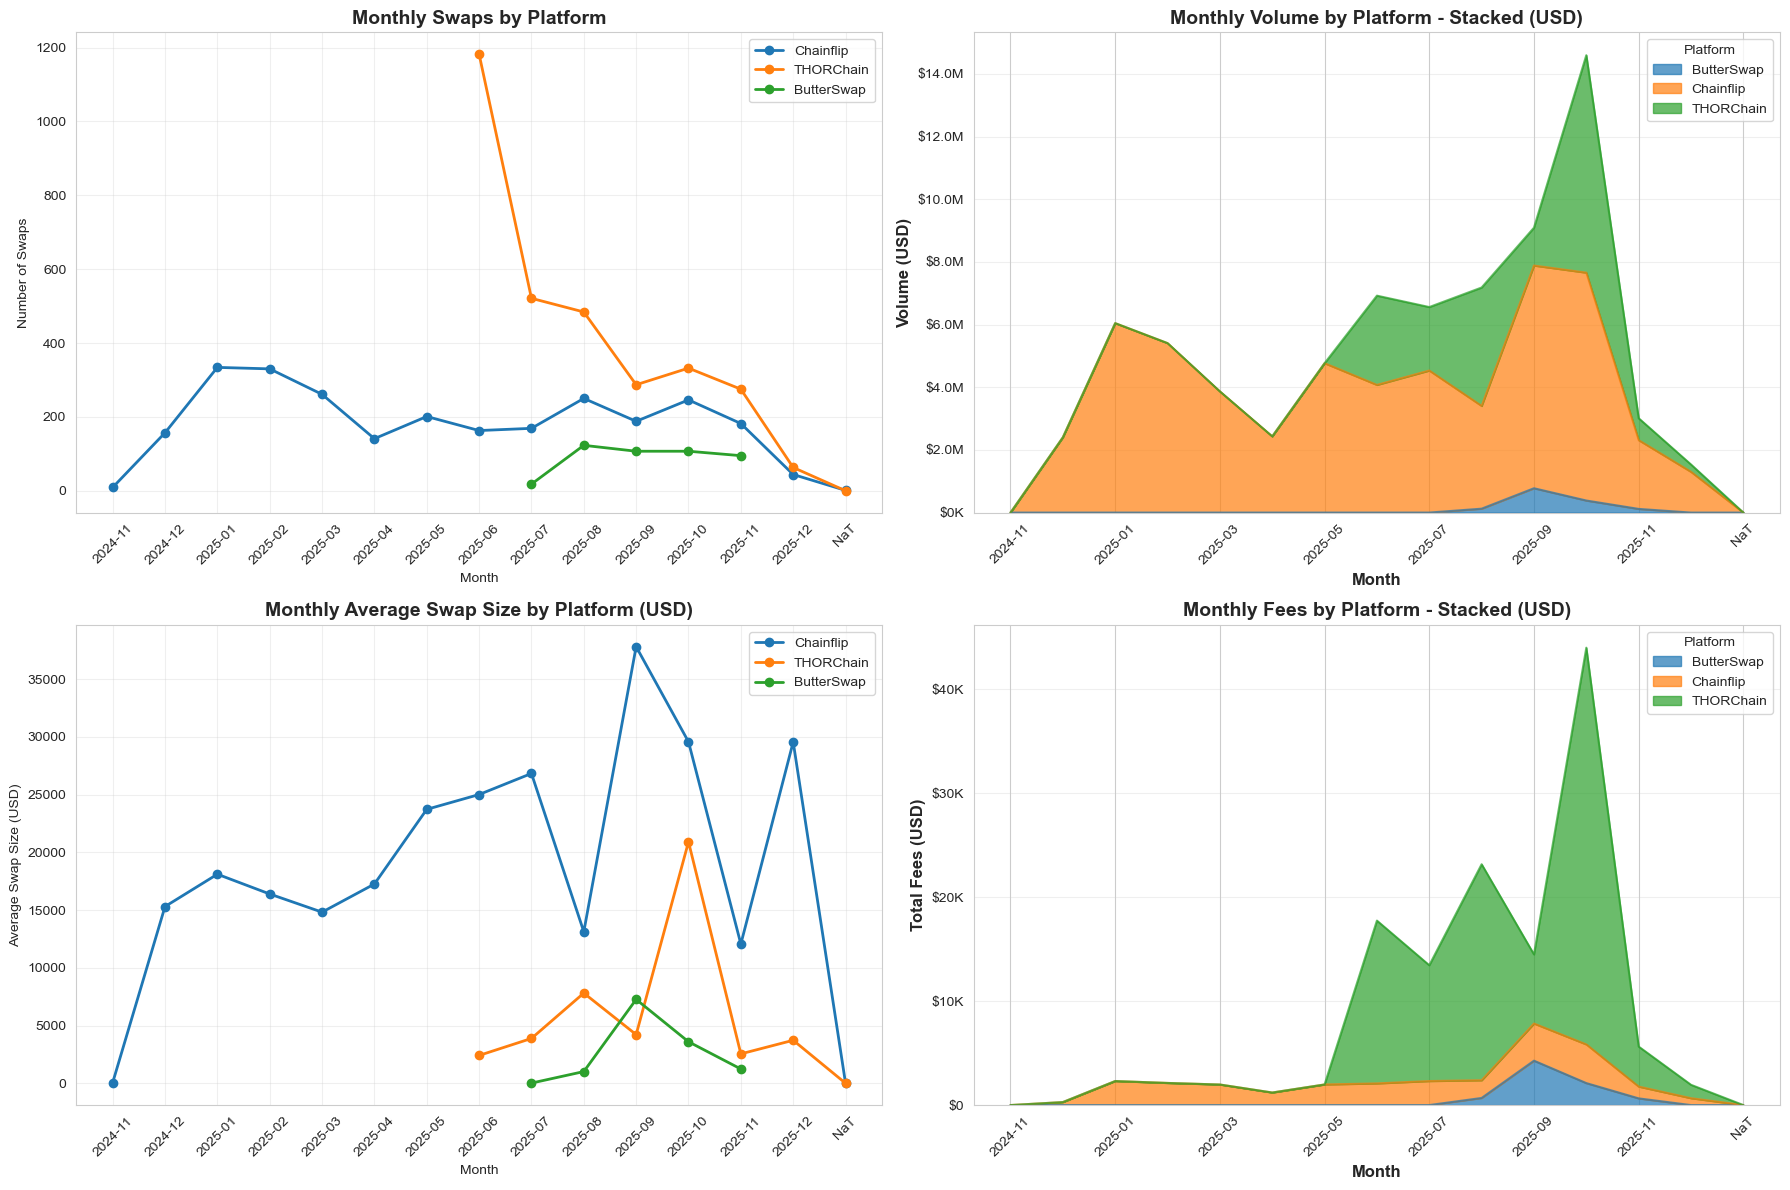

In [12]:
# Platform comparison summary - MONTH BY MONTH
print("=" * 70)
print("PLATFORM COMPARISON SUMMARY - MONTH BY MONTH")
print("=" * 70)

# Check if we have year_month column
if 'year_month' not in combined_df.columns:
    print("⚠ No year_month column found. Creating from timestamp...")
    if 'timestamp' in combined_df.columns:
        combined_df['year_month'] = pd.to_datetime(combined_df['timestamp']).dt.to_period('M').astype(str)
    else:
        print("✗ Cannot create monthly breakdown - no timestamp column")
        year_month = None
else:
    year_month = 'year_month'

if year_month:
    # Check what columns are available
    print(f"\nAvailable columns for aggregation:")
    print(f"  swap_size: {'swap_size' in combined_df.columns}")
    print(f"  fee_usd: {'fee_usd' in combined_df.columns}")
    print(f"  from_amount_usd: {'from_amount_usd' in combined_df.columns}")
    
    # Build aggregation dictionary - ALWAYS use swap_size (which is from_amount_usd)
    agg_dict = {'tx_hash': 'count'}
    
    # Always use swap_size which is based on from_amount_usd
    if 'swap_size' in combined_df.columns:
        agg_dict['swap_size'] = ['sum', 'mean', 'median']
    else:
        print("  ⚠ Warning: swap_size column not found, using fallback")
        if 'from_amount_usd' in combined_df.columns:
            agg_dict['from_amount_usd'] = ['sum', 'mean', 'median']
        elif 'from_amount' in combined_df.columns:
            agg_dict['from_amount'] = ['sum', 'mean', 'median']
    
    # Always include fee_usd (should be calculated for all platforms now)
    if 'fee_usd' in combined_df.columns:
        agg_dict['fee_usd'] = ['sum', 'mean']
    else:
        print("  ⚠ Warning: fee_usd column not found")
    
    # Group by platform AND month
    platform_summary = combined_df.groupby(['platform', year_month]).agg(agg_dict).round(2)

    # Flatten column names
    if isinstance(platform_summary.columns, pd.MultiIndex):
        platform_summary.columns = ['_'.join(col).strip() for col in platform_summary.columns.values]
    else:
        platform_summary.columns = [str(col) for col in platform_summary.columns]
    
    # Rename for clarity
    column_rename = {
        'tx_hash_count': 'Total Swaps',
        'swap_size_sum': 'Total Volume',
        'swap_size_mean': 'Avg Swap Size',
        'swap_size_median': 'Median Swap Size',
        'from_amount_usd_sum': 'Total Volume',
        'from_amount_usd_mean': 'Avg Swap Size',
        'from_amount_usd_median': 'Median Swap Size',
        'from_amount_sum': 'Total Volume',
        'from_amount_mean': 'Avg Swap Size',
        'from_amount_median': 'Median Swap Size',
        'fee_usd_sum': 'Total Fees',
        'fee_usd_mean': 'Avg Fee'
    }
    
    platform_summary = platform_summary.rename(columns=column_rename)
    
    # Reset index to show month and platform as columns
    platform_summary = platform_summary.reset_index()
    
    print("\nMonthly Platform Comparison:")
    print(platform_summary.to_string(index=False))
    
    # Also show summary pivot table
    if 'Total Swaps' in platform_summary.columns:
        print("\n\nMonthly Swaps by Platform (Pivot):")
        swaps_pivot = platform_summary.pivot(index=year_month, columns='platform', values='Total Swaps').fillna(0)
        print(swaps_pivot)
    
    if 'Total Volume' in platform_summary.columns:
        print("\n\nMonthly Volume by Platform (Pivot):")
        volume_pivot = platform_summary.pivot(index=year_month, columns='platform', values='Total Volume').fillna(0)
        print(volume_pivot)
    
    if 'Total Fees' in platform_summary.columns:
        print("\n\nMonthly Fees by Platform (Pivot):")
        fees_pivot = platform_summary.pivot(index=year_month, columns='platform', values='Total Fees').fillna(0)
        print(fees_pivot)
else:
    print("⚠ Cannot create monthly breakdown")

# Visualize platform comparison - MONTH BY MONTH
if year_month and year_month in combined_df.columns:
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    
    # Prepare monthly data
    monthly_data = combined_df.groupby([year_month, 'platform']).agg({
        'tx_hash': 'count'
    }).reset_index()
    monthly_data.columns = ['month', 'platform', 'swaps']
    
    # Get volume column - ALWAYS use swap_size (from_amount_usd)
    volume_col = 'swap_size' if 'swap_size' in combined_df.columns else None
    if not volume_col:
        print("  ⚠ Warning: swap_size not found, using fallback")
        if 'from_amount_usd' in combined_df.columns:
            volume_col = 'from_amount_usd'
        elif 'from_amount' in combined_df.columns:
            volume_col = 'from_amount'
    
    if volume_col:
        monthly_volume = combined_df.groupby([year_month, 'platform'])[volume_col].sum().reset_index()
        monthly_volume.columns = ['month', 'platform', 'volume']
        monthly_avg = combined_df.groupby([year_month, 'platform'])[volume_col].mean().reset_index()
        monthly_avg.columns = ['month', 'platform', 'avg_size']
    
    if 'fee_usd' in combined_df.columns:
        monthly_fees = combined_df.groupby([year_month, 'platform'])['fee_usd'].sum().reset_index()
        monthly_fees.columns = ['month', 'platform', 'fees']
    
    # 1. Monthly swaps by platform (line chart)
    for platform in monthly_data['platform'].unique():
        platform_data = monthly_data[monthly_data['platform'] == platform]
        axes[0, 0].plot(platform_data['month'], platform_data['swaps'], marker='o', label=platform, linewidth=2)
    axes[0, 0].set_title('Monthly Swaps by Platform', fontsize=14, fontweight='bold')
    axes[0, 0].set_ylabel('Number of Swaps')
    axes[0, 0].set_xlabel('Month')
    axes[0, 0].legend()
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Monthly volume by platform (STACKED area chart)
    if volume_col and 'monthly_volume' in locals():
        # Create pivot table for stacking
        volume_pivot = monthly_volume.pivot(index='month', columns='platform', values='volume').fillna(0)
        volume_pivot.plot(kind='area', stacked=True, ax=axes[0, 1], 
                         color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7)
        axes[0, 1].set_title('Monthly Volume by Platform - Stacked (USD)', fontsize=14, fontweight='bold')
        axes[0, 1].set_ylabel('Volume (USD)', fontsize=12, fontweight='bold')
        axes[0, 1].set_xlabel('Month', fontsize=12, fontweight='bold')
        axes[0, 1].legend(title='Platform')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M' if x >= 1e6 else f'${x/1e3:.0f}K'))
        axes[0, 1].grid(True, alpha=0.3, axis='y')
    else:
        axes[0, 1].text(0.5, 0.5, 'Volume data not available', ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('Monthly Volume by Platform (USD)', fontsize=14, fontweight='bold')
    
    # 3. Monthly average swap size by platform
    if volume_col and 'monthly_avg' in locals():
        for platform in monthly_avg['platform'].unique():
            platform_data = monthly_avg[monthly_avg['platform'] == platform]
            axes[1, 0].plot(platform_data['month'], platform_data['avg_size'], marker='o', label=platform, linewidth=2)
        axes[1, 0].set_title('Monthly Average Swap Size by Platform (USD)', fontsize=14, fontweight='bold')
        axes[1, 0].set_ylabel('Average Swap Size (USD)')
        axes[1, 0].set_xlabel('Month')
        axes[1, 0].legend()
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].grid(True, alpha=0.3)
    else:
        axes[1, 0].text(0.5, 0.5, 'Volume data not available', ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Monthly Average Swap Size by Platform (USD)', fontsize=14, fontweight='bold')
    
    # 4. Monthly fees by platform (STACKED area chart)
    if 'fee_usd' in combined_df.columns and 'monthly_fees' in locals():
        # Create pivot table for stacking
        fees_pivot = monthly_fees.pivot(index='month', columns='platform', values='fees').fillna(0)
        fees_pivot.plot(kind='area', stacked=True, ax=axes[1, 1], 
                       color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7)
        axes[1, 1].set_title('Monthly Fees by Platform - Stacked (USD)', fontsize=14, fontweight='bold')
        axes[1, 1].set_ylabel('Total Fees (USD)', fontsize=12, fontweight='bold')
        axes[1, 1].set_xlabel('Month', fontsize=12, fontweight='bold')
        axes[1, 1].legend(title='Platform')
        axes[1, 1].tick_params(axis='x', rotation=45)
        axes[1, 1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e3:.0f}K' if x >= 1000 else f'${x:.0f}'))
        axes[1, 1].grid(True, alpha=0.3, axis='y')
    else:
        axes[1, 1].text(0.5, 0.5, 'Fee data not available', ha='center', va='center', transform=axes[1, 1].transAxes)
        axes[1, 1].set_title('Monthly Fees by Platform (USD)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "=" * 70)


## Stacked Area Chart: Monthly Volume by Top 10 Asset Pairs


STACKED AREA CHART: MONTHLY VOLUME BY TOP 10 ASSET PAIRS

Top 10 Asset Pairs for Stacked Chart:
  1. BTC → USDT: $10,168,805
  2. BTC → USDC: $7,785,212
  3. BTC → ETH: $6,915,406
  4. BTC → BTC: $5,913,275
  5. ETH → BTC: $5,625,300
  6. FOX → USDC: $4,995,185
  7. USDT → ETH: $4,034,393
  8. USDC → BTC: $3,963,603
  9. TCY → ETH: $2,829,924
  10. ETH → USDT: $2,678,099


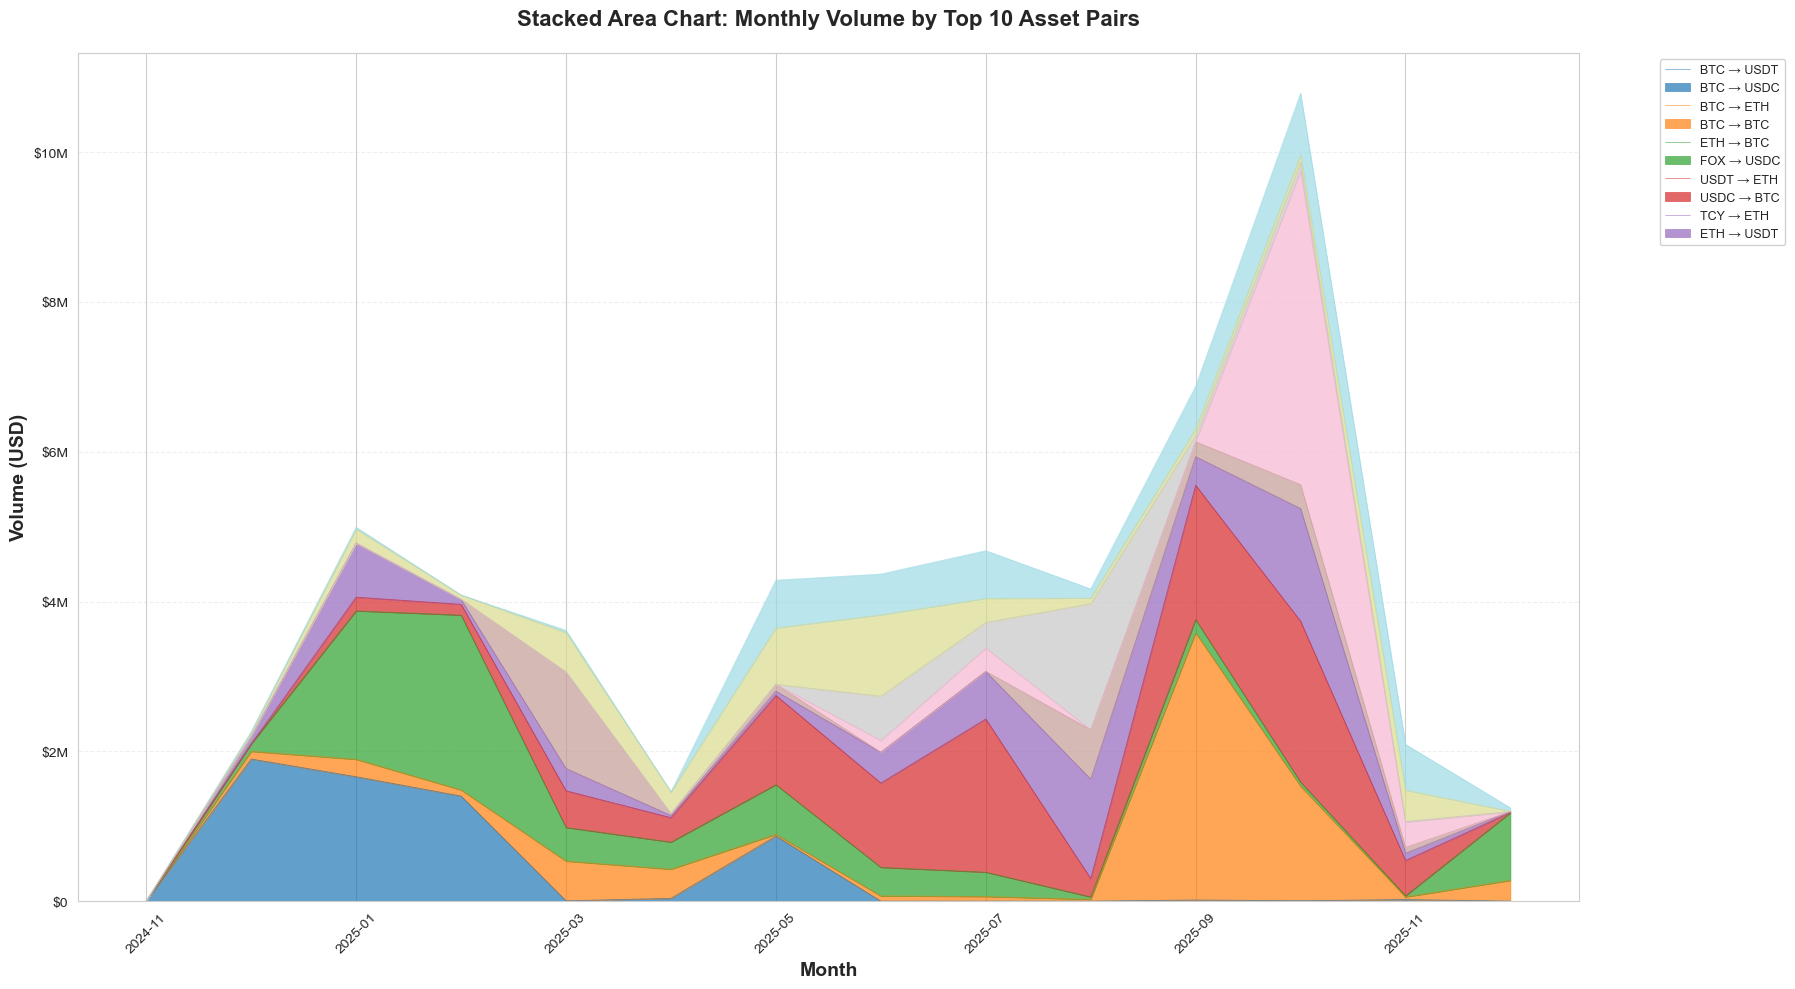


✓ Stacked area chart created successfully


In [13]:
# Stacked Area Chart - Monthly Volume by Top 10 Asset Pairs
print("=" * 70)
print("STACKED AREA CHART: MONTHLY VOLUME BY TOP 10 ASSET PAIRS")
print("=" * 70)

if 'asset_pair' in combined_df.columns and 'year_month' in combined_df.columns:
    # Get top 10 pairs by total volume
    volume_col = 'swap_size' if 'swap_size' in combined_df.columns else 'from_amount_usd'
    
    top_10_pairs = combined_df.groupby('asset_pair')[volume_col].sum().nlargest(10).index.tolist()
    
    # Filter out unknown pairs
    top_10_pairs = [p for p in top_10_pairs if 'Unknown' not in str(p) and str(p) != 'Unknown → Unknown']
    
    print(f"\nTop 10 Asset Pairs for Stacked Chart:")
    for i, pair in enumerate(top_10_pairs, 1):
        total_vol = combined_df[combined_df['asset_pair'] == pair][volume_col].sum()
        print(f"  {i}. {pair}: {format_currency(total_vol)}")
    
    # Create monthly aggregation for top 10 pairs
    monthly_pairs_stacked = combined_df[combined_df['asset_pair'].isin(top_10_pairs)].groupby(
        ['year_month', 'asset_pair']
    )[volume_col].sum().reset_index()
    monthly_pairs_stacked.columns = ['month', 'asset_pair', 'volume']
    
    # Create pivot table
    monthly_pivot = monthly_pairs_stacked.pivot(index='month', columns='asset_pair', values='volume').fillna(0)
    monthly_pivot = monthly_pivot.sort_index()
    
    # Create stacked area chart
    fig, ax = plt.subplots(1, 1, figsize=(18, 10))
    
    # Use distinct colors for each pair
    colors = plt.cm.tab20(np.linspace(0, 1, len(top_10_pairs)))
    
    # Plot stacked area chart
    monthly_pivot.plot(kind='area', stacked=True, ax=ax, 
                      color=colors, alpha=0.7, linewidth=0.5)
    
    # Formatting
    ax.set_title('Stacked Area Chart: Monthly Volume by Top 10 Asset Pairs', fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Month', fontsize=14, fontweight='bold')
    ax.set_ylabel('Volume (USD)', fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9, ncol=1, framealpha=0.9, 
             labels=[pair[:30] for pair in top_10_pairs])
    ax.tick_params(axis='x', rotation=45)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(currency_formatter))
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Stacked area chart created successfully")
    print("=" * 70)
else:
    print("⚠ Missing required columns for stacked chart")


## Whale Concentration Comparison by Affiliate


WHALE CONCENTRATION COMPARISON BY AFFILIATE

Whale Concentration Comparison by Affiliate:
----------------------------------------------------------------------
 Affiliate  Total Users Total Volume Top 10 Users % Top 20 Users % Top 100 Users % Risk Level
 chainflip         1394  $54,682,579         34.14%         50.94%          81.20%     MEDIUM
 thorchain         1288  $17,627,036         59.97%         74.79%          97.35%       HIGH
butterswap          174   $1,403,273         68.08%         81.22%          99.85%       HIGH


Whale Tier Distribution by Affiliate:

CHAINFLIP:
                    user_count  total_volume  avg_volume_per_user  pct_of_total
whale_tier                                                                     
Tier1 (>$1M)                12   20765940.19           1730495.02         37.98
Tier2 ($100k-$1M)           72   22139034.37            307486.59         40.49
Tier3 ($10k-$100k)         286    9592405.55             33539.88         17.54
Tier4 (<$10

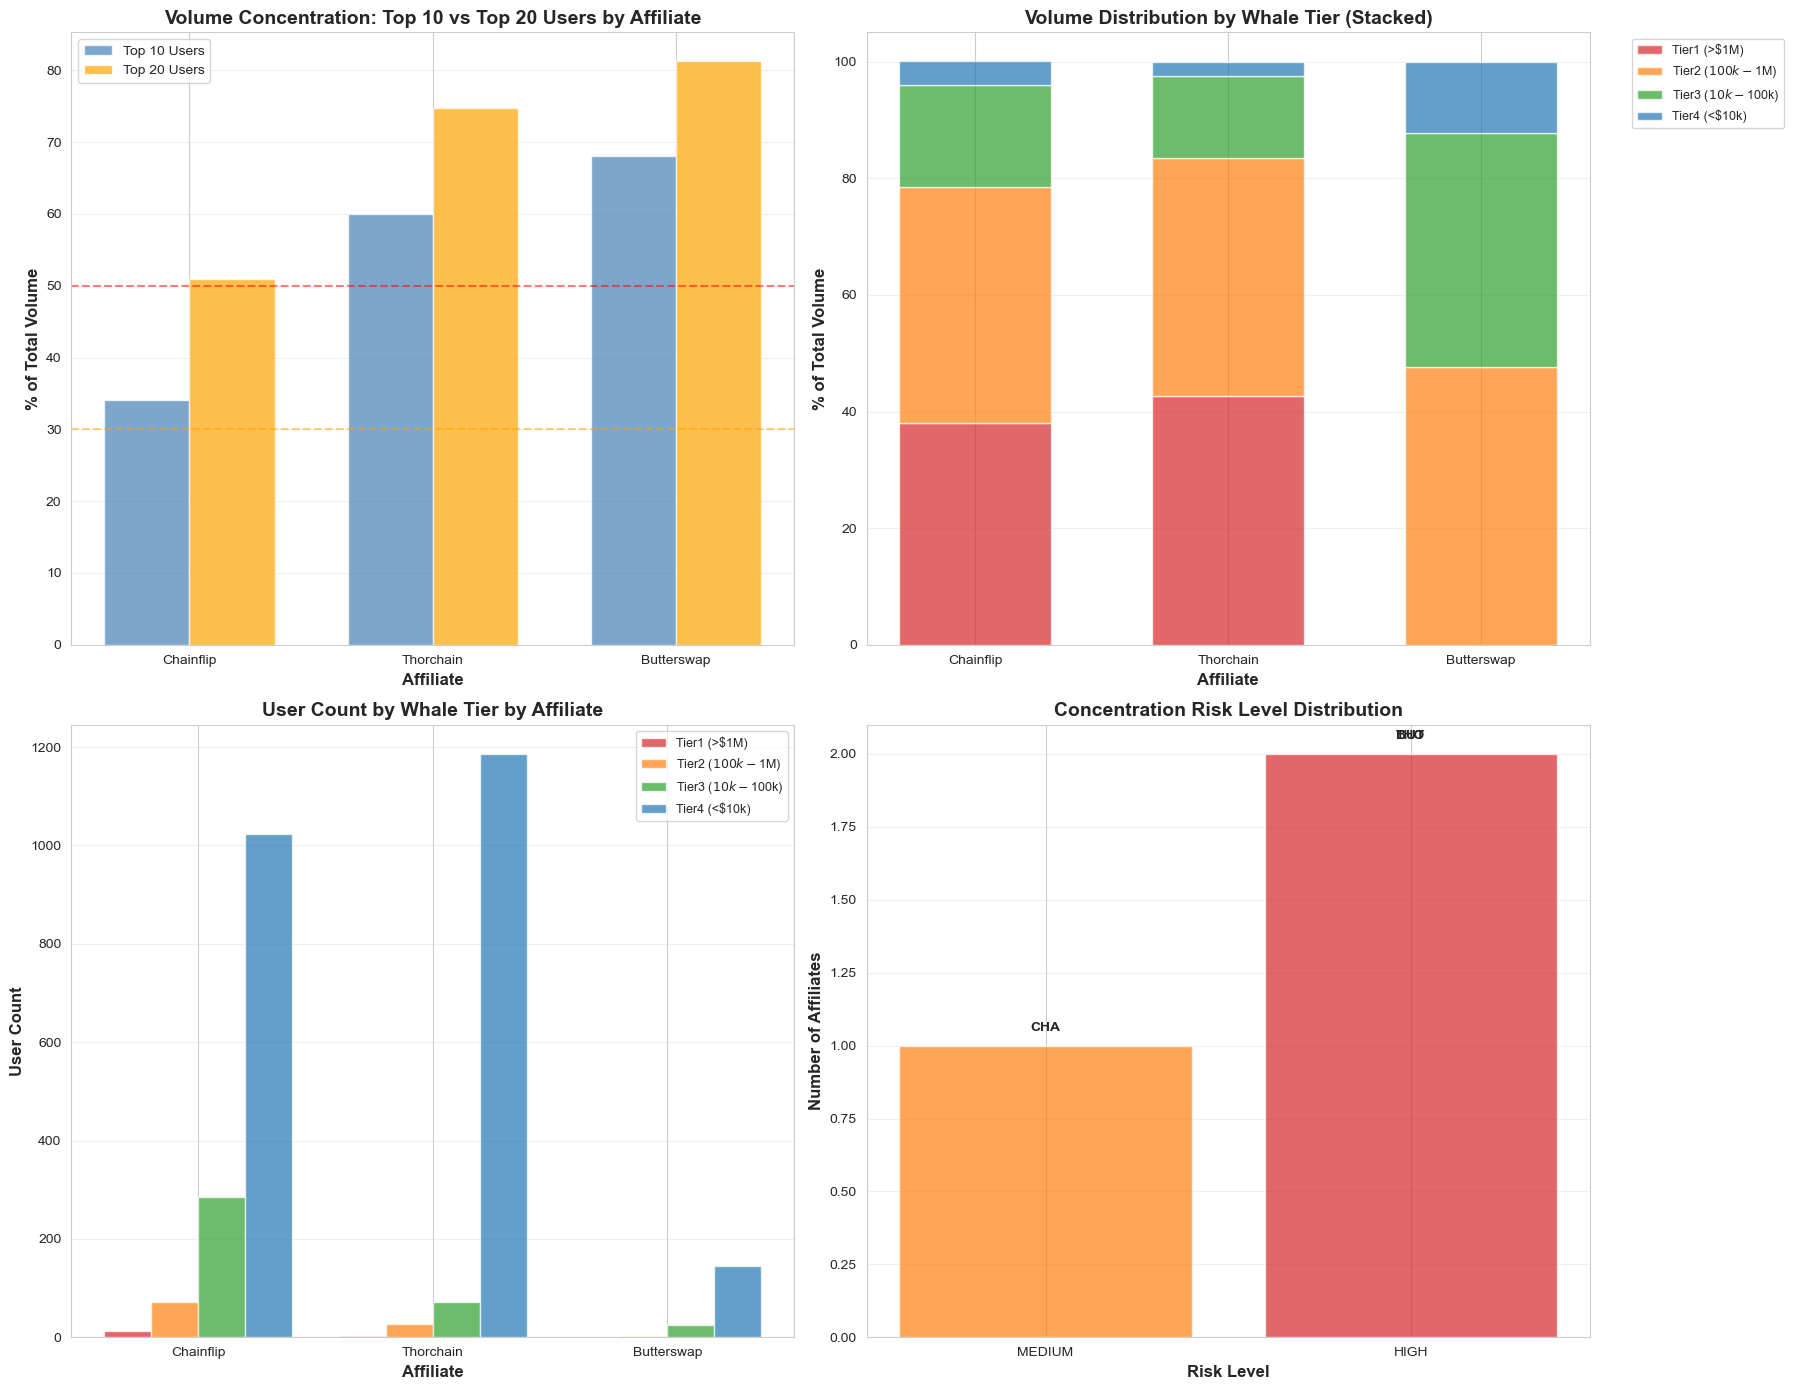



Summary by Affiliate:

CHAINFLIP:
  Total users: 1,394
  Total volume: $54,682,579
  Top 10 users = 34.14% of volume
  Top 20 users = 50.94% of volume
  Concentration risk: MEDIUM

THORCHAIN:
  Total users: 1,288
  Total volume: $17,627,036
  Top 10 users = 59.97% of volume
  Top 20 users = 74.79% of volume
  Concentration risk: HIGH

BUTTERSWAP:
  Total users: 174
  Total volume: $1,403,273
  Top 10 users = 68.08% of volume
  Top 20 users = 81.22% of volume
  Concentration risk: HIGH



In [14]:
# Whale Concentration Comparison by Affiliate
print("=" * 70)
print("WHALE CONCENTRATION COMPARISON BY AFFILIATE")
print("=" * 70)

required_cols = ['user_address', 'swap_size', 'affiliate']
if all(col in combined_df.columns for col in required_cols):
    # Calculate whale metrics by affiliate
    affiliate_whale_data = []
    
    for affiliate in ['chainflip', 'thorchain', 'butterswap']:
        affiliate_df = combined_df[combined_df['affiliate'] == affiliate].copy()
        
        if len(affiliate_df) > 0:
            # Calculate user metrics for this affiliate
            user_metrics_aff = affiliate_df.groupby('user_address').agg({
                'swap_size': ['sum', 'count', 'mean'],
                'timestamp': ['min', 'max']
            }).round(2)
            
            user_metrics_aff.columns = ['total_volume', 'swap_count', 'avg_size', 'first_trade_date', 'last_trade_date']
            user_metrics_aff = user_metrics_aff.reset_index()
            
            # Rank users by total volume
            user_metrics_aff = user_metrics_aff.sort_values('total_volume', ascending=False).reset_index(drop=True)
            user_metrics_aff['rank'] = range(1, len(user_metrics_aff) + 1)
            
            # Calculate concentration metrics
            total_volume_aff = user_metrics_aff['total_volume'].sum()
            top_10_volume_aff = user_metrics_aff.head(10)['total_volume'].sum()
            top_20_volume_aff = user_metrics_aff.head(20)['total_volume'].sum()
            top_100_volume_aff = user_metrics_aff.head(100)['total_volume'].sum() if len(user_metrics_aff) >= 100 else total_volume_aff
            
            top_10_pct_aff = (top_10_volume_aff / total_volume_aff * 100) if total_volume_aff > 0 else 0
            top_20_pct_aff = (top_20_volume_aff / total_volume_aff * 100) if total_volume_aff > 0 else 0
            top_100_pct_aff = (top_100_volume_aff / total_volume_aff * 100) if total_volume_aff > 0 else 0
            
            # Classify whale tiers
            def classify_tier(volume):
                if volume >= 1_000_000:
                    return 'Tier1 (>$1M)'
                elif volume >= 100_000:
                    return 'Tier2 ($100k-$1M)'
                elif volume >= 10_000:
                    return 'Tier3 ($10k-$100k)'
                else:
                    return 'Tier4 (<$10k)'
            
            user_metrics_aff['whale_tier'] = user_metrics_aff['total_volume'].apply(classify_tier)
            
            # Tier statistics
            tier_stats_aff = user_metrics_aff.groupby('whale_tier').agg({
                'user_address': 'count',
                'total_volume': ['sum', 'mean']
            }).round(2)
            tier_stats_aff.columns = ['user_count', 'total_volume', 'avg_volume_per_user']
            tier_stats_aff['pct_of_total'] = (tier_stats_aff['total_volume'] / total_volume_aff * 100).round(2)
            
            # Risk assessment
            if top_10_pct_aff >= 50:
                risk_level = "HIGH"
            elif top_10_pct_aff >= 30:
                risk_level = "MEDIUM"
            else:
                risk_level = "LOW"
            
            affiliate_whale_data.append({
                'affiliate': affiliate,
                'total_users': len(user_metrics_aff),
                'total_volume': total_volume_aff,
                'top_10_pct': top_10_pct_aff,
                'top_20_pct': top_20_pct_aff,
                'top_100_pct': top_100_pct_aff,
                'risk_level': risk_level,
                'tier_stats': tier_stats_aff,
                'user_metrics': user_metrics_aff
            })
    
    # Print comparison summary
    print("\nWhale Concentration Comparison by Affiliate:")
    print("-" * 70)
    
    comparison_df = pd.DataFrame([{
        'Affiliate': d['affiliate'],
        'Total Users': d['total_users'],
        'Total Volume': format_currency(d['total_volume']),
        'Top 10 Users %': f"{d['top_10_pct']:.2f}%",
        'Top 20 Users %': f"{d['top_20_pct']:.2f}%",
        'Top 100 Users %': f"{d['top_100_pct']:.2f}%",
        'Risk Level': d['risk_level']
    } for d in affiliate_whale_data])
    
    print(comparison_df.to_string(index=False))
    
    # Print tier distribution by affiliate
    print("\n\nWhale Tier Distribution by Affiliate:")
    for data in affiliate_whale_data:
        print(f"\n{data['affiliate'].upper()}:")
        print(data['tier_stats'].to_string())
    
    # Create comparison visualization
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # 1. Top 10 users % comparison (bar chart)
    affiliates = [d['affiliate'] for d in affiliate_whale_data]
    top_10_pcts = [d['top_10_pct'] for d in affiliate_whale_data]
    top_20_pcts = [d['top_20_pct'] for d in affiliate_whale_data]
    
    x = np.arange(len(affiliates))
    width = 0.35
    axes[0, 0].bar(x - width/2, top_10_pcts, width, label='Top 10 Users', color='steelblue', alpha=0.7)
    axes[0, 0].bar(x + width/2, top_20_pcts, width, label='Top 20 Users', color='orange', alpha=0.7)
    axes[0, 0].set_xlabel('Affiliate', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('% of Total Volume', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Volume Concentration: Top 10 vs Top 20 Users by Affiliate', fontsize=14, fontweight='bold')
    axes[0, 0].set_xticks(x)
    axes[0, 0].set_xticklabels([a.capitalize() for a in affiliates])
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    axes[0, 0].axhline(y=50, color='red', linestyle='--', alpha=0.5, label='High Risk Threshold')
    axes[0, 0].axhline(y=30, color='orange', linestyle='--', alpha=0.5, label='Medium Risk Threshold')
    
    # 2. Whale tier distribution comparison (stacked bar)
    tier_order = ['Tier1 (>$1M)', 'Tier2 ($100k-$1M)', 'Tier3 ($10k-$100k)', 'Tier4 (<$10k)']
    tier_data = {}
    for tier in tier_order:
        tier_data[tier] = []
        for data in affiliate_whale_data:
            if tier in data['tier_stats'].index:
                tier_data[tier].append(data['tier_stats'].loc[tier, 'pct_of_total'])
            else:
                tier_data[tier].append(0)
    
    x = np.arange(len(affiliates))
    bottom = np.zeros(len(affiliates))
    colors_tier = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4']
    
    for i, tier in enumerate(tier_order):
        axes[0, 1].bar(x, tier_data[tier], width=0.6, bottom=bottom, label=tier, 
                       color=colors_tier[i], alpha=0.7)
        bottom += tier_data[tier]
    
    axes[0, 1].set_xlabel('Affiliate', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('% of Total Volume', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Volume Distribution by Whale Tier (Stacked)', fontsize=14, fontweight='bold')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels([a.capitalize() for a in affiliates])
    axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # 3. User count by tier comparison (grouped bar)
    tier_user_counts = {}
    for tier in tier_order:
        tier_user_counts[tier] = []
        for data in affiliate_whale_data:
            if tier in data['tier_stats'].index:
                tier_user_counts[tier].append(data['tier_stats'].loc[tier, 'user_count'])
            else:
                tier_user_counts[tier].append(0)
    
    x = np.arange(len(affiliates))
    width = 0.2
    for i, tier in enumerate(tier_order):
        offset = (i - 1.5) * width
        axes[1, 0].bar(x + offset, tier_user_counts[tier], width, label=tier, 
                      color=colors_tier[i], alpha=0.7)
    
    axes[1, 0].set_xlabel('Affiliate', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('User Count', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('User Count by Whale Tier by Affiliate', fontsize=14, fontweight='bold')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels([a.capitalize() for a in affiliates])
    axes[1, 0].legend(fontsize=9)
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 4. Risk level comparison
    risk_colors = {'HIGH': '#d62728', 'MEDIUM': '#ff7f0e', 'LOW': '#2ca02c'}
    risk_counts = {}
    for data in affiliate_whale_data:
        risk = data['risk_level']
        risk_counts[risk] = risk_counts.get(risk, 0) + 1
    
    axes[1, 1].bar(risk_counts.keys(), risk_counts.values(), 
                   color=[risk_colors.get(r, 'gray') for r in risk_counts.keys()], alpha=0.7)
    axes[1, 1].set_xlabel('Risk Level', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Number of Affiliates', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Concentration Risk Level Distribution', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Add text annotations for each affiliate's risk level
    for i, data in enumerate(affiliate_whale_data):
        risk = data['risk_level']
        y_pos = risk_counts.get(risk, 0)
        axes[1, 1].text(list(risk_counts.keys()).index(risk), y_pos + 0.05, 
                       data['affiliate'][:3].upper(), ha='center', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Summary by affiliate
    print("\n\nSummary by Affiliate:")
    for data in affiliate_whale_data:
        print(f"\n{data['affiliate'].upper()}:")
        print(f"  Total users: {data['total_users']:,}")
        print(f"  Total volume: {format_currency(data['total_volume'])}")
        print(f"  Top 10 users = {data['top_10_pct']:.2f}% of volume")
        print(f"  Top 20 users = {data['top_20_pct']:.2f}% of volume")
        print(f"  Concentration risk: {data['risk_level']}")
    
    print("\n" + "=" * 70)
else:
    print("⚠ Missing required columns for affiliate whale comparison")


## Step 7: Combined Cohort Analysis


In [15]:
# Validation: Check analysis dataframe before aggregations
if VALIDATION_AVAILABLE and 'analysis_df' in locals():
    print("\n" + "="*60)
    print("DATA VALIDATION - Analysis DataFrame")
    print("="*60)
    
    # Run all validations for combined swappers
    validation_results = {}
    
    if 'from_amount_usd' in analysis_df.columns:
        validation_results['amounts'] = validate_amounts(analysis_df, 'from_amount_usd', max_amount=1e9)
    
    if 'fee_usd' in analysis_df.columns and 'from_amount_usd' in analysis_df.columns:
        validation_results['fees'] = validate_fee_percentage(analysis_df, 'fee_usd', 'from_amount_usd')
    
    if 'from_asset' in analysis_df.columns and 'to_asset' in analysis_df.columns:
        validation_results['asset_pairs'] = validate_asset_pairs(analysis_df)
    
    if 'timestamp' in analysis_df.columns:
        validation_results['timestamps'] = validate_timestamps(analysis_df)
    
    print_validation_results(validation_results)
    print("="*60 + "\n")

COMBINED USER RETENTION & COHORT ANALYSIS


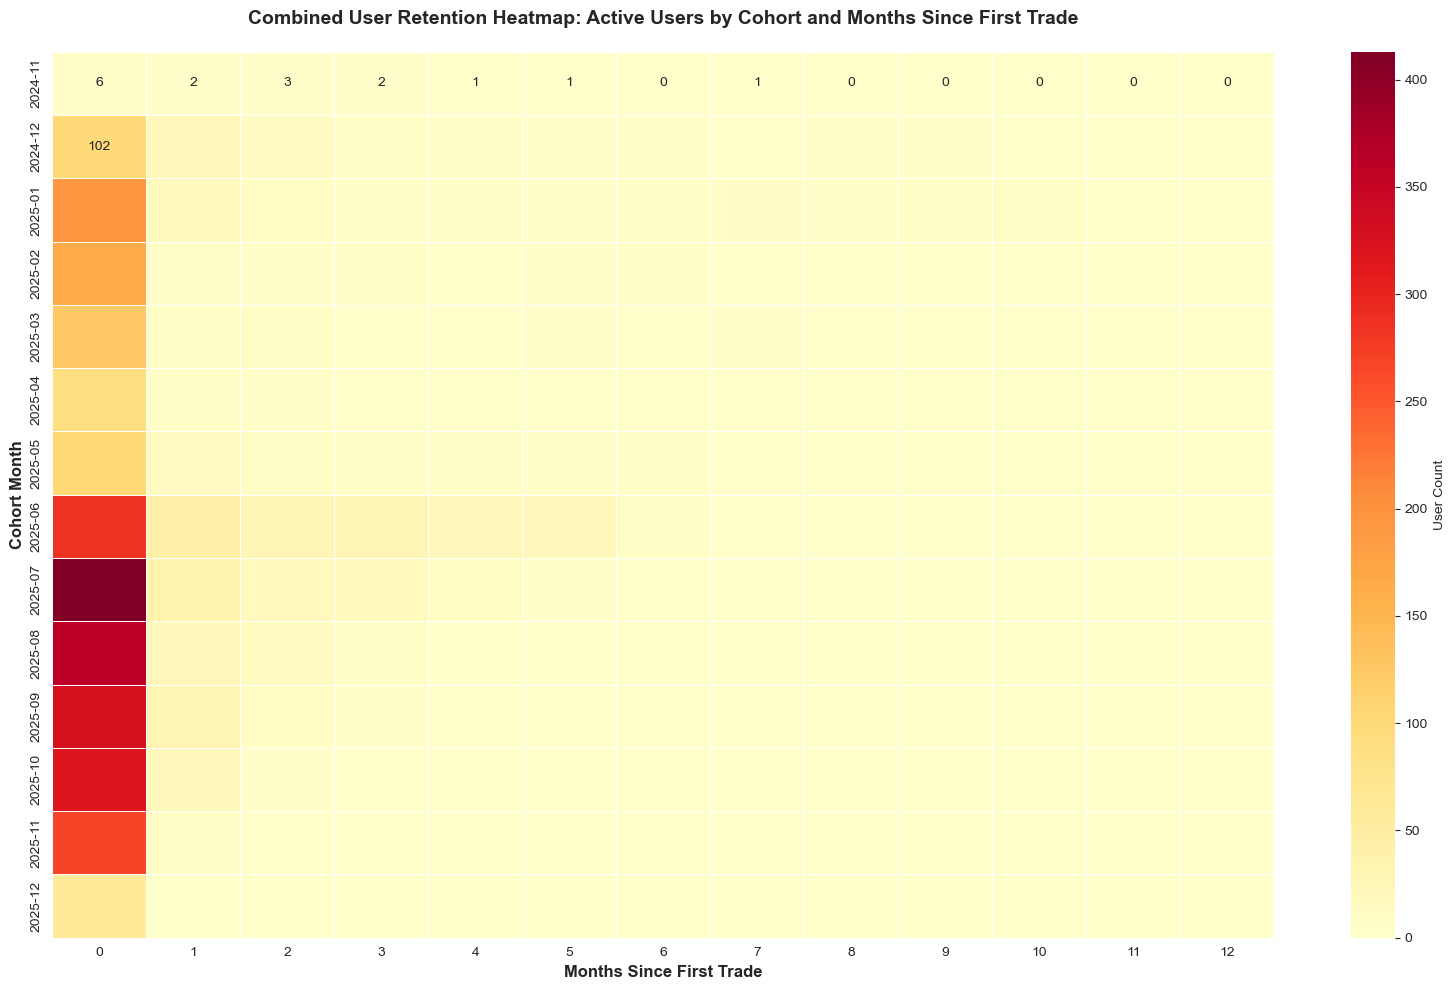


Total unique users (all platforms): 2,814
Repeat traders (>1 trade): 709 (25.2%)
Sticky users (10+ trades): 60 (2.1%)

Average trades per user: 2.22
Median trades per user: 1.00


In [16]:
# Combined cohort analysis across all platforms
if 'user_address' in combined_df.columns and 'timestamp' in combined_df.columns:
    print("=" * 70)
    print("COMBINED USER RETENTION & COHORT ANALYSIS")
    print("=" * 70)
    
    # Identify user's first trade across all platforms
    user_first_trade = combined_df.groupby('user_address')['timestamp'].min().reset_index()
    user_first_trade.columns = ['user_address', 'first_trade_date']
    user_first_trade['cohort_month'] = pd.to_datetime(user_first_trade['first_trade_date']).dt.to_period('M').astype(str)
    
    # Merge back to main dataframe
    analysis_df = combined_df.copy()
    analysis_df_with_cohort = analysis_df.merge(user_first_trade, on='user_address', how='left')
    analysis_df_with_cohort['trade_month'] = pd.to_datetime(analysis_df_with_cohort['timestamp']).dt.to_period('M').astype(str)
    
    # Calculate months since first trade
    def calculate_months_diff(row):
        try:
            if pd.isna(row['trade_month']) or pd.isna(row['cohort_month']):
                return 0
            trade_period = pd.Period(row['trade_month'])
            cohort_period = pd.Period(row['cohort_month'])
            return (trade_period - cohort_period).n
        except:
            return 0
    
    analysis_df_with_cohort['months_since_first'] = analysis_df_with_cohort.apply(calculate_months_diff, axis=1)
    
    # Create cohort retention table
    cohort_retention = analysis_df_with_cohort.groupby(['cohort_month', 'months_since_first'])['user_address'].nunique().reset_index()
    cohort_retention.columns = ['cohort_month', 'months_since_first', 'user_count']
    
    # Pivot for heatmap
    cohort_pivot = cohort_retention.pivot(index='cohort_month', columns='months_since_first', values='user_count').fillna(0)
    
    # Calculate engagement metrics
    user_trade_counts = analysis_df.groupby('user_address').size().reset_index(name='trade_count')
    repeat_traders = len(user_trade_counts[user_trade_counts['trade_count'] > 1])
    sticky_users = len(user_trade_counts[user_trade_counts['trade_count'] >= 10])
    total_users = len(user_trade_counts)
    
    repeat_pct = (repeat_traders / total_users * 100) if total_users > 0 else 0
    sticky_pct = (sticky_users / total_users * 100) if total_users > 0 else 0
    
    # Create heatmap visualization
    fig, ax = plt.subplots(figsize=(16, 10))
    sns.heatmap(cohort_pivot, annot=True, fmt='.0f', cmap='YlOrRd', 
                cbar_kws={'label': 'User Count'}, ax=ax, linewidths=0.5)
    ax.set_xlabel('Months Since First Trade', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cohort Month', fontsize=12, fontweight='bold')
    ax.set_title('Combined User Retention Heatmap: Active Users by Cohort and Months Since First Trade', 
                fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    print(f"\nTotal unique users (all platforms): {total_users:,}")
    print(f"Repeat traders (>1 trade): {repeat_traders:,} ({repeat_pct:.1f}%)")
    print(f"Sticky users (10+ trades): {sticky_users:,} ({sticky_pct:.1f}%)")
    print(f"\nAverage trades per user: {user_trade_counts['trade_count'].mean():.2f}")
    print(f"Median trades per user: {user_trade_counts['trade_count'].median():.2f}")
    print("=" * 70)
else:
    print("⚠ Cannot perform cohort analysis - missing user_address or timestamp columns")


## Step 8: Cross-Platform User Analysis


CROSS-PLATFORM USER ANALYSIS

Users by number of platforms used:
  1 platform(s): 2,772 users (98.5%)
  2 platform(s): 42 users (1.5%)

Multi-platform users: 42 (1.5%)

Platform combinations used by multi-platform users:
  ButterSwap, THORChain: 42 users


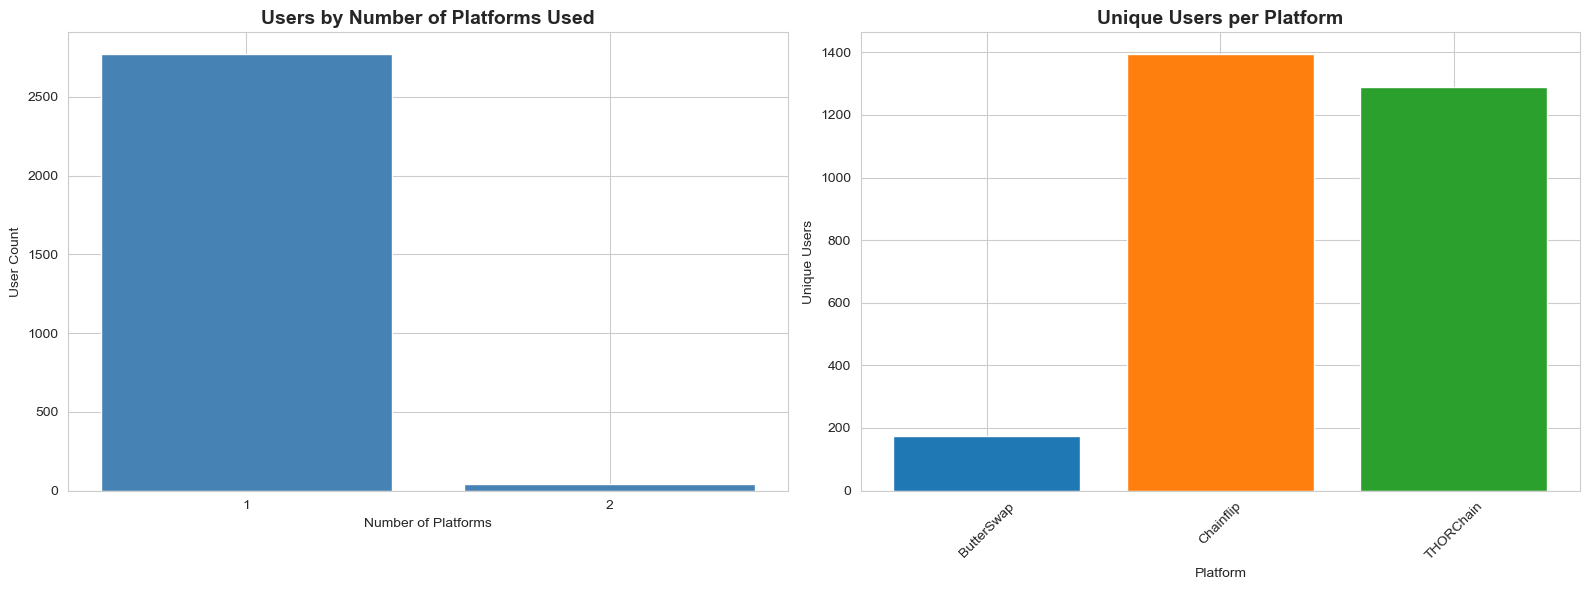

In [17]:
# Analyze users who trade across multiple platforms
if 'user_address' in combined_df.columns:
    print("=" * 70)
    print("CROSS-PLATFORM USER ANALYSIS")
    print("=" * 70)
    
    # Count platforms per user
    user_platforms = combined_df.groupby('user_address')['platform'].nunique().reset_index()
    user_platforms.columns = ['user_address', 'platform_count']
    
    # Users by platform count
    platform_dist = user_platforms['platform_count'].value_counts().sort_index()
    print("\nUsers by number of platforms used:")
    for count, users in platform_dist.items():
        pct = (users / len(user_platforms)) * 100
        print(f"  {count} platform(s): {users:,} users ({pct:.1f}%)")
    
    # Multi-platform users
    multi_platform_users = user_platforms[user_platforms['platform_count'] > 1]
    print(f"\nMulti-platform users: {len(multi_platform_users):,} ({len(multi_platform_users)/len(user_platforms)*100:.1f}%)")
    
    # Which platforms do multi-platform users use?
    if len(multi_platform_users) > 0:
        multi_user_addresses = multi_platform_users['user_address'].tolist()
        multi_user_trades = combined_df[combined_df['user_address'].isin(multi_user_addresses)]
        platform_combinations = multi_user_trades.groupby('user_address')['platform'].apply(lambda x: ', '.join(sorted(x.unique()))).reset_index()
        platform_combinations.columns = ['user_address', 'platforms_used']
        
        combo_counts = platform_combinations['platforms_used'].value_counts()
        print("\nPlatform combinations used by multi-platform users:")
        for combo, count in combo_counts.head(10).items():
            print(f"  {combo}: {count:,} users")
    
    # Visualize
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Platform distribution
    axes[0].bar(platform_dist.index.astype(str), platform_dist.values, color='steelblue')
    axes[0].set_title('Users by Number of Platforms Used', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Number of Platforms')
    axes[0].set_ylabel('User Count')
    
    # Platform usage breakdown
    platform_usage = combined_df.groupby('platform')['user_address'].nunique()
    axes[1].bar(platform_usage.index, platform_usage.values, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[1].set_title('Unique Users per Platform', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Platform')
    axes[1].set_ylabel('Unique Users')
    axes[1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
else:
    print("⚠ Cannot perform cross-platform analysis - missing user_address column")


## Step 9: Combined Asset Pair Trends & Revenue Analysis


COMBINED ASSET PAIR & REVENUE ANALYSIS - MONTH BY MONTH

Top 20 Asset Pairs by Volume (All Platforms, All Months):
             total_volume  swap_count  total_fees
asset_pair                                       
BTC → USDT    10168804.56         286     5112.34
BTC → USDC     7785212.37         298     3923.43
BTC → ETH      6915406.13         412     3580.69
BTC → BTC      5913274.74          20        0.22
ETH → BTC      5625300.00         437     3167.78
FOX → USDC     4995185.12          12    27473.51
USDT → ETH     4034393.41          67     2040.93
USDC → BTC     3963603.10         316     2647.09
TCY → ETH      2829924.28          78    15564.58
ETH → USDT     2678099.09          96     1602.93
USDT → BTC     2453693.59         245     1829.55
ETH → SOL      2002274.73         149     1049.52
RUNE → ETH     1565024.31          56     8607.62
TCY → BTC      1289560.56          48     7092.59
BTC → SOL      1113486.55         205      623.26
TCY → USDT      754080.78          

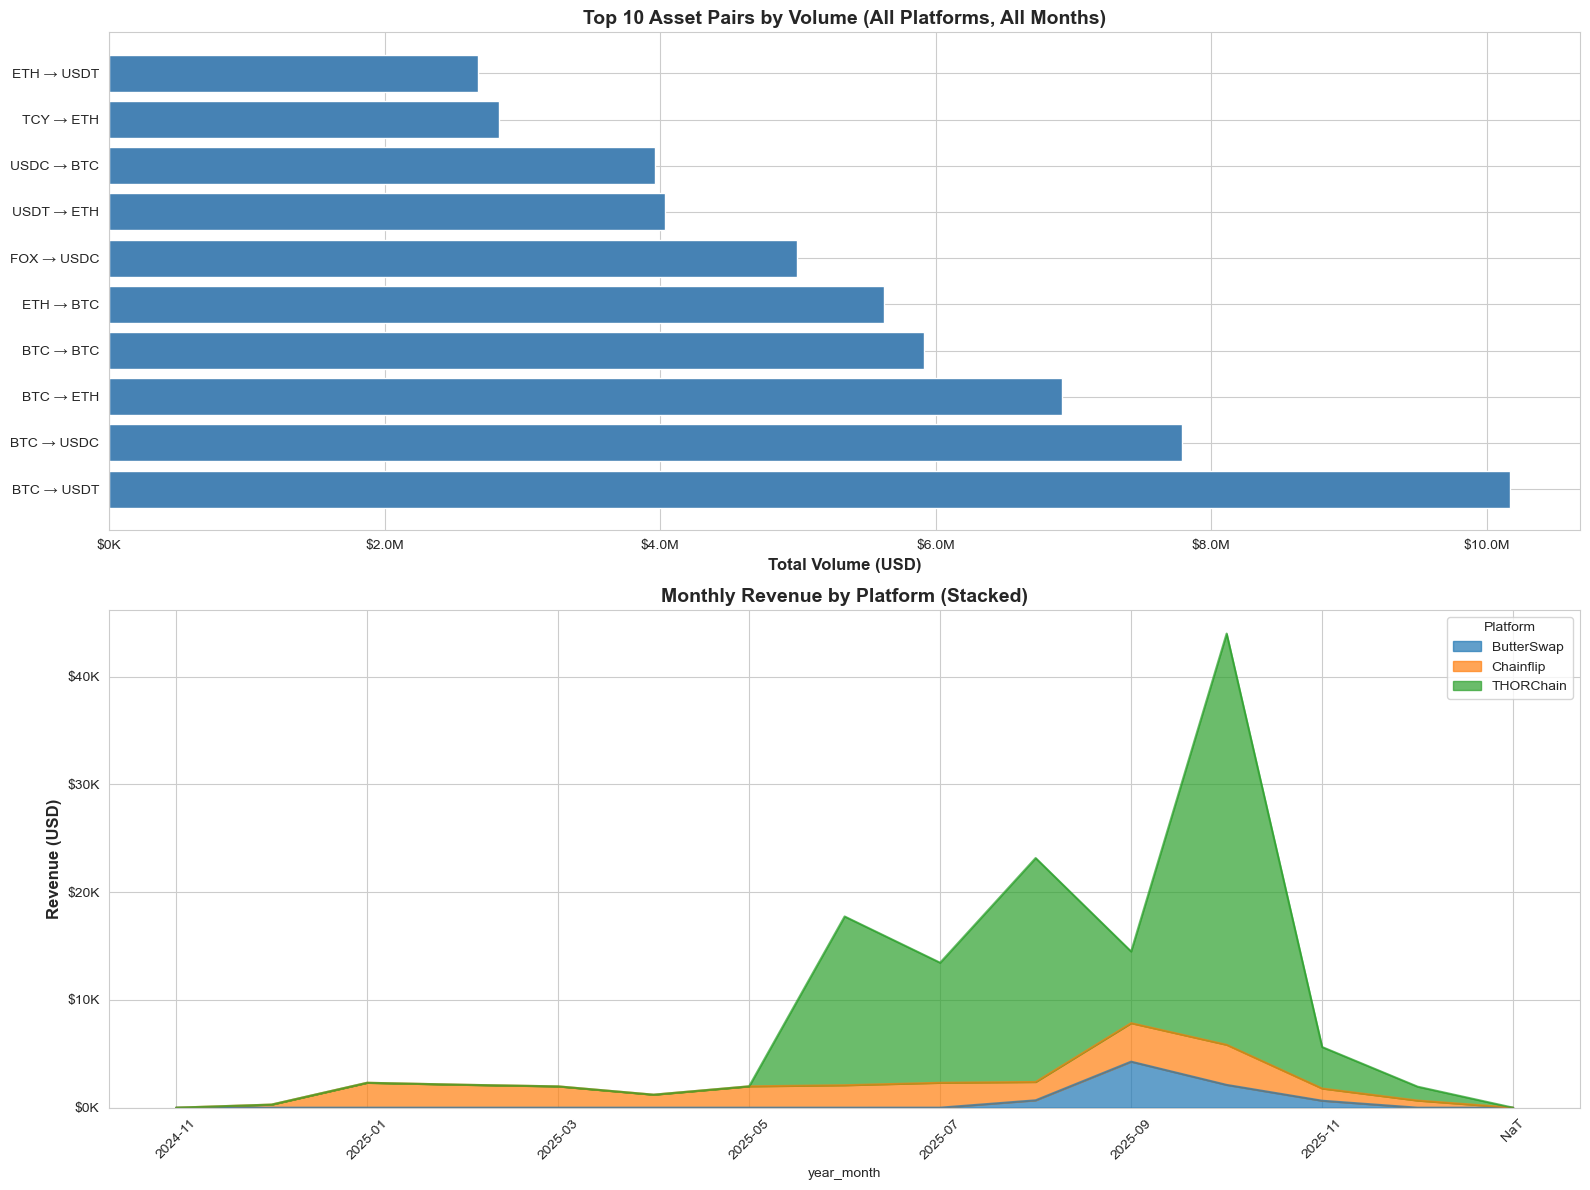


MONTHLY SUMMARY STATISTICS
            Total Revenue  Total Volume  Total Swaps  Unique Users
year_month                                                        
2024-11              1.34        447.27            9             6
2024-12            288.39    2402202.99          157           104
2025-01           2312.69    6045275.03          334           219
2025-02           2129.63    5407782.26          330           200
2025-03           1977.95    3866533.11          261           150
2025-04           1207.78    2432354.56          141           107
2025-05           1982.51    4766986.32          201           130
2025-06          17747.65    6922543.54         1345           312
2025-07          13454.25    6558942.92          708           475
2025-08          23170.47    7182678.79          857           451
2025-09          14495.08    9092291.20          582           408
2025-10          44002.36   14595974.08          685           418
2025-11           5630.07    30113

In [18]:
# Combined asset pair and revenue analysis - MONTH BY MONTH
if 'asset_pair' in combined_df.columns and 'fee_usd' in combined_df.columns:
    print("=" * 70)
    print("COMBINED ASSET PAIR & REVENUE ANALYSIS - MONTH BY MONTH")
    print("=" * 70)
    
    # Ensure year_month exists
    if 'year_month' not in combined_df.columns and 'timestamp' in combined_df.columns:
        combined_df['year_month'] = pd.to_datetime(combined_df['timestamp']).dt.to_period('M').astype(str)
    
    if 'year_month' in combined_df.columns:
        # Top asset pairs by volume - monthly breakdown
        # ALWAYS use swap_size which is from_amount_usd
        volume_col = 'swap_size' if 'swap_size' in combined_df.columns else 'from_amount_usd'
        
        monthly_pairs = combined_df.groupby(['year_month', 'asset_pair']).agg({
            volume_col: ['sum', 'count', 'mean'],
            'fee_usd': 'sum'
        }).round(2)
        
        # Flatten column names
        if isinstance(monthly_pairs.columns, pd.MultiIndex):
            monthly_pairs.columns = ['_'.join(col).strip() for col in monthly_pairs.columns.values]
        else:
            monthly_pairs.columns = [str(col) for col in monthly_pairs.columns]
        
        monthly_pairs = monthly_pairs.reset_index()
        monthly_pairs.columns = ['month', 'asset_pair', 'total_volume', 'swap_count', 'avg_size', 'total_fees']
        
        # Top pairs overall (across all months)
        top_pairs_overall = monthly_pairs.groupby('asset_pair').agg({
            'total_volume': 'sum',
            'swap_count': 'sum',
            'total_fees': 'sum'
        }).round(2).sort_values('total_volume', ascending=False).head(20)
        
        print("\nTop 20 Asset Pairs by Volume (All Platforms, All Months):")
        print(top_pairs_overall)
        
        # Monthly top pairs
        print("\n\nTop 5 Asset Pairs by Month:")
        for month in sorted(monthly_pairs['month'].unique()):
            month_data = monthly_pairs[monthly_pairs['month'] == month].sort_values('total_volume', ascending=False).head(5)
            print(f"\n{month}:")
            print(month_data[['asset_pair', 'total_volume', 'swap_count', 'total_fees']].to_string(index=False))
    
        # Monthly revenue by platform
        monthly_revenue = combined_df.groupby(['year_month', 'platform'])['fee_usd'].sum().reset_index()
        monthly_revenue_pivot = monthly_revenue.pivot(index='year_month', columns='platform', values='fee_usd').fillna(0)
        
        print("\n\nMonthly Revenue by Platform:")
        print(monthly_revenue_pivot)
        
        # Visualize
        fig, axes = plt.subplots(2, 1, figsize=(16, 12))
        
        # Top pairs by volume (overall)
        top_10 = top_pairs_overall.head(10)
        axes[0].barh(range(len(top_10)), top_10['total_volume'], color='steelblue')
        axes[0].set_yticks(range(len(top_10)))
        axes[0].set_yticklabels(top_10.index, fontsize=10)
        axes[0].set_xlabel('Total Volume (USD)', fontsize=12, fontweight='bold')
        axes[0].set_title('Top 10 Asset Pairs by Volume (All Platforms, All Months)', fontsize=14, fontweight='bold')
        axes[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e6:.1f}M' if x >= 1e6 else f'${x/1e3:.0f}K'))
        
        # Monthly revenue stacked area
        monthly_revenue_pivot.plot(kind='area', stacked=True, ax=axes[1], 
                                  color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7)
        axes[1].set_title('Monthly Revenue by Platform (Stacked)', fontsize=14, fontweight='bold')
        axes[1].set_ylabel('Revenue (USD)', fontsize=12, fontweight='bold')
        axes[1].legend(title='Platform')
        axes[1].tick_params(axis='x', rotation=45)
        axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1e3:.0f}K'))
        
        plt.tight_layout()
        plt.show()
        
        # Monthly summary statistics
        print(f"\n{'='*70}")
        print(f"MONTHLY SUMMARY STATISTICS")
        print(f"{'='*70}")
        
        monthly_stats = combined_df.groupby('year_month').agg({
            'fee_usd': 'sum',
            volume_col: 'sum',
            'tx_hash': 'count',
            'user_address': 'nunique'
        }).round(2)
        monthly_stats.columns = ['Total Revenue', 'Total Volume', 'Total Swaps', 'Unique Users']
        print(monthly_stats)
        
        print(f"\n{'='*70}")
        print(f"OVERALL SUMMARY STATISTICS (ALL PLATFORMS, ALL MONTHS)")
        print(f"{'='*70}")
        total_revenue = combined_df['fee_usd'].sum()
        total_volume = combined_df[volume_col].sum() if volume_col in combined_df.columns else 0
        total_users = combined_df['user_address'].nunique()
        print(f"Total Revenue: ${total_revenue:,.2f}")
        print(f"Total Volume: ${total_volume:,.2f}")
        print(f"Total Swaps: {len(combined_df):,}")
        print(f"Total Unique Users: {total_users:,}")
        print(f"{'='*70}")
else:
    print("⚠ Cannot perform asset pair/revenue analysis - missing required columns")


## Step 10: Save Combined Results


In [19]:
# Save combined dataframe (master file with all swaps)
output_filename = f"combined_swappers_master_{datetime.now().strftime('%Y%m%d_%H%M%S')}.csv"
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

# Save to Downloads (original location)
downloads_path = data_directory / output_filename
combined_df.to_csv(downloads_path, index=False)
print(f"✓ Saved combined master file to Downloads: {downloads_path}")
print(f"  Total rows: {len(combined_df):,}")
print(f"  Total columns: {len(combined_df.columns)}")
print(f"  File size: {downloads_path.stat().st_size / 1024 / 1024:.2f} MB")

# Also save to repo data directory for easy access
repo_data_dir = Path('../data').resolve()
repo_output_path = repo_data_dir / output_filename
combined_df.to_csv(repo_output_path, index=False)
print(f"\n✓ Also saved to repo data directory: {repo_output_path}")

# Save a "latest" version without timestamp for easy access
latest_filename = "combined_swappers_master_latest.csv"
latest_downloads = data_directory / latest_filename
latest_repo = repo_data_dir / latest_filename

combined_df.to_csv(latest_downloads, index=False)
combined_df.to_csv(latest_repo, index=False)
print(f"\n✓ Saved as 'latest' version:")
print(f"  Downloads: {latest_downloads}")
print(f"  Repo data: {latest_repo}")


✓ Saved combined master file to Downloads: /Users/chrismccarthy/Downloads/combined_swappers_master_20251210_213955.csv
  Total rows: 6,273
  Total columns: 68
  File size: 4.76 MB

✓ Also saved to repo data directory: /Users/chrismccarthy/defi-analysis-repo/data/combined_swappers_master_20251210_213955.csv

✓ Saved as 'latest' version:
  Downloads: /Users/chrismccarthy/Downloads/combined_swappers_master_latest.csv
  Repo data: /Users/chrismccarthy/defi-analysis-repo/data/combined_swappers_master_latest.csv


## Step 11: Improvement 1 - Whale/User Concentration Analysis


WHALE/USER CONCENTRATION ANALYSIS

Top 10 Users:
 rank                                                             user_address  total_volume  swap_count   whale_tier
    1                               0xba2cbccf92a726cfc7591119b487f51b4c1b39dc    4249042.09          10 Tier1 (>$1M)
    2 https://mempool.space/address/bc1qe7ukk9h32q0697hgxvjl6mp8yrwda4cx9rxqyf    3494852.70           3 Tier1 (>$1M)
    3  https://etherscan.io/address/0xe0be78934648e7d774a6a22221d3b6753570669c    2796064.91           8 Tier1 (>$1M)
    4  https://etherscan.io/address/0xb49b8bb583126eb60ec1c9dff9ce2b0478a3e10c    2199332.13           5 Tier1 (>$1M)
    5                              thor1jxglhe7n9u2t02cdpls2vgzl3a7392kmwzm4sl    1936540.76          52 Tier1 (>$1M)
    6 https://mempool.space/address/bc1qrwace4msmvgt6fw3w72dwew9vt7hxvzxx5m9a9    1897896.90           1 Tier1 (>$1M)
    7 https://mempool.space/address/bc1q66wume7v885nwt577e555xhft4ettcu58m9va0    1604830.20           1 Tier1 (>$1M)
    8 h

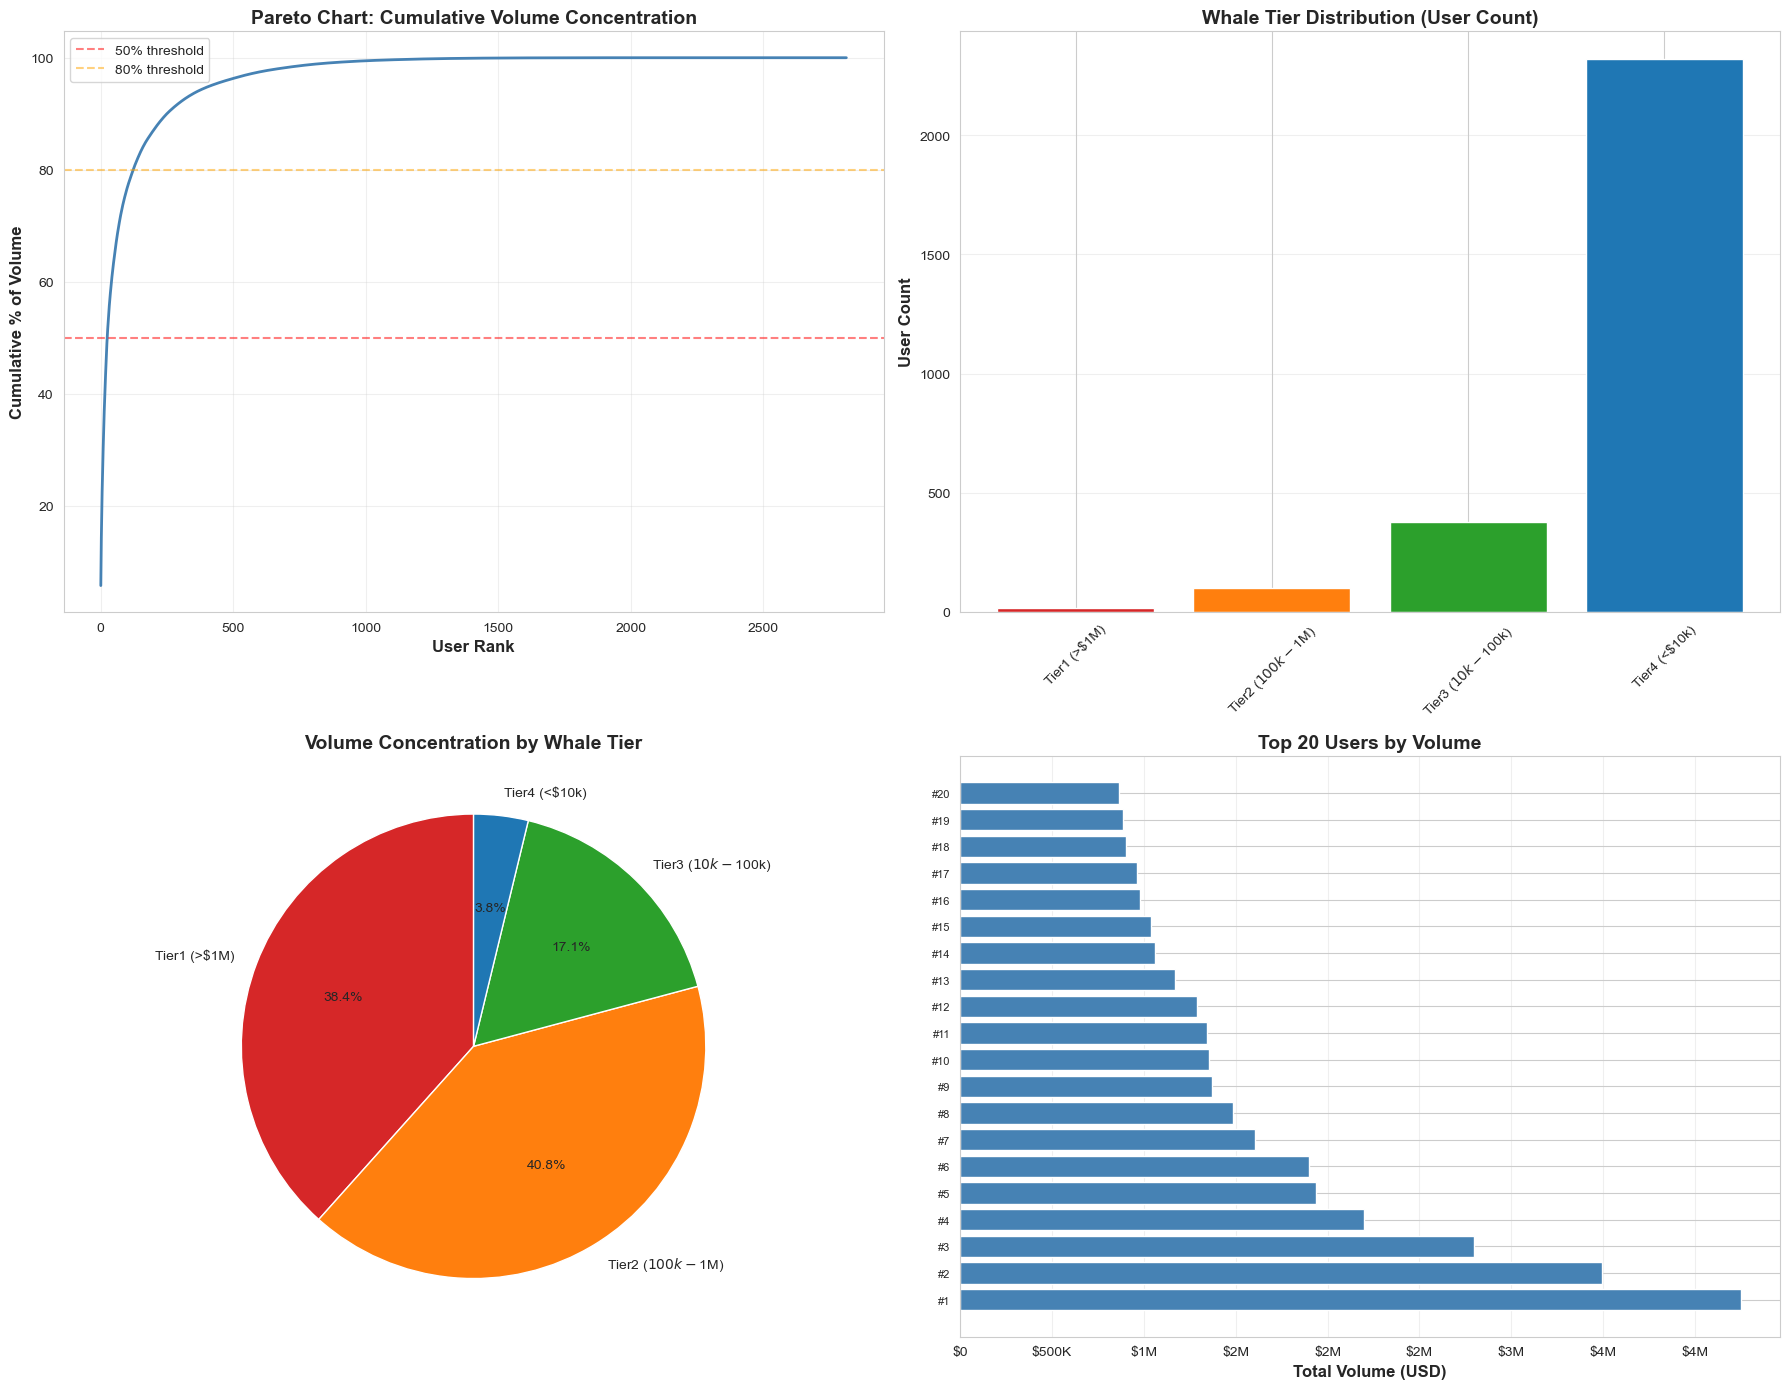

In [20]:
# Whale/User Concentration Analysis
print("=" * 70)
print("WHALE/USER CONCENTRATION ANALYSIS")
print("=" * 70)

# Required columns check
required_cols = ['user_address', 'swap_size', 'platform']
if all(col in combined_df.columns for col in required_cols):
    # 1. Calculate user metrics
    user_metrics = combined_df.groupby('user_address').agg({
        'swap_size': ['sum', 'count', 'mean'],
        'timestamp': ['min', 'max']
    }).round(2)
    
    user_metrics.columns = ['total_volume', 'swap_count', 'avg_size', 'first_trade_date', 'last_trade_date']
    user_metrics = user_metrics.reset_index()
    
    # Calculate days active
    user_metrics['lifetime_days'] = (pd.to_datetime(user_metrics['last_trade_date']) - 
                                    pd.to_datetime(user_metrics['first_trade_date'])).dt.days + 1
    
    # 2. Rank users by total volume
    user_metrics = user_metrics.sort_values('total_volume', ascending=False).reset_index(drop=True)
    user_metrics['rank'] = range(1, len(user_metrics) + 1)
    
    # 3. Calculate concentration metrics
    total_volume_all = user_metrics['total_volume'].sum()
    top_10_volume = user_metrics.head(10)['total_volume'].sum()
    top_20_volume = user_metrics.head(20)['total_volume'].sum()
    top_100_volume = user_metrics.head(100)['total_volume'].sum()
    
    top_10_pct = (top_10_volume / total_volume_all * 100) if total_volume_all > 0 else 0
    top_20_pct = (top_20_volume / total_volume_all * 100) if total_volume_all > 0 else 0
    top_100_pct = (top_100_volume / total_volume_all * 100) if total_volume_all > 0 else 0
    
    # 4. Classify whale tiers
    def classify_tier(volume):
        if volume >= 1_000_000:
            return 'Tier1 (>$1M)'
        elif volume >= 100_000:
            return 'Tier2 ($100k-$1M)'
        elif volume >= 10_000:
            return 'Tier3 ($10k-$100k)'
        else:
            return 'Tier4 (<$10k)'
    
    user_metrics['whale_tier'] = user_metrics['total_volume'].apply(classify_tier)
    
    # 5. Tier statistics
    tier_stats = user_metrics.groupby('whale_tier').agg({
        'user_address': 'count',
        'total_volume': ['sum', 'mean']
    }).round(2)
    tier_stats.columns = ['user_count', 'total_volume', 'avg_volume_per_user']
    tier_stats['pct_of_total'] = (tier_stats['total_volume'] / total_volume_all * 100).round(2)
    tier_stats = tier_stats.sort_values('total_volume', ascending=False)
    
    print("\nTop 10 Users:")
    print(user_metrics[['rank', 'user_address', 'total_volume', 'swap_count', 'whale_tier']].head(10).to_string(index=False))
    
    print(f"\n\nConcentration Metrics:")
    print(f"  Top 10 users = {top_10_pct:.2f}% of total volume")
    print(f"  Top 20 users = {top_20_pct:.2f}% of total volume")
    print(f"  Top 100 users = {top_100_pct:.2f}% of total volume")
    
    print(f"\n\nWhale Tier Distribution:")
    print(tier_stats.to_string())
    
    # 6. Risk assessment
    if top_10_pct >= 50:
        risk_level = "HIGH"
    elif top_10_pct >= 30:
        risk_level = "MEDIUM"
    else:
        risk_level = "LOW"
    
    print(f"\n\nConcentration Risk: {risk_level}")
    print(f"  If top 10 users leave, channel loses {top_10_pct:.1f}% of volume")
    
    # 7. Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Pareto chart (cumulative % volume by user rank)
    user_metrics['cumulative_volume'] = user_metrics['total_volume'].cumsum()
    user_metrics['cumulative_pct'] = (user_metrics['cumulative_volume'] / total_volume_all * 100)
    
    axes[0, 0].plot(user_metrics['rank'], user_metrics['cumulative_pct'], linewidth=2, color='steelblue')
    axes[0, 0].axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50% threshold')
    axes[0, 0].axhline(y=80, color='orange', linestyle='--', alpha=0.5, label='80% threshold')
    axes[0, 0].set_xlabel('User Rank', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Cumulative % of Volume', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Pareto Chart: Cumulative Volume Concentration', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Bar chart (whale tier distribution - user count)
    tier_order = ['Tier1 (>$1M)', 'Tier2 ($100k-$1M)', 'Tier3 ($10k-$100k)', 'Tier4 (<$10k)']
    tier_counts = [tier_stats.loc[tier, 'user_count'] if tier in tier_stats.index else 0 for tier in tier_order]
    axes[0, 1].bar(tier_order, tier_counts, color=['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4'])
    axes[0, 1].set_ylabel('User Count', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Whale Tier Distribution (User Count)', fontsize=14, fontweight='bold')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Pie chart (volume concentration by tier)
    tier_volumes = [tier_stats.loc[tier, 'total_volume'] if tier in tier_stats.index else 0 for tier in tier_order]
    axes[1, 0].pie(tier_volumes, labels=tier_order, autopct='%1.1f%%', startangle=90,
                   colors=['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4'])
    axes[1, 0].set_title('Volume Concentration by Whale Tier', fontsize=14, fontweight='bold')
    
    # Top 20 users bar chart
    top_20 = user_metrics.head(20)
    axes[1, 1].barh(range(len(top_20)), top_20['total_volume'], color='steelblue')
    axes[1, 1].set_yticks(range(len(top_20)))
    axes[1, 1].set_yticklabels([f"#{r}" for r in top_20['rank']], fontsize=8)
    axes[1, 1].set_xlabel('Total Volume (USD)', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Top 20 Users by Volume', fontsize=14, fontweight='bold')
    axes[1, 1].xaxis.set_major_formatter(plt.FuncFormatter(currency_formatter))
    axes[1, 1].grid(True, alpha=0.3, axis='x')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
else:
    print("⚠ Missing required columns for whale analysis")


CROSS-PLATFORM USER SWITCHING & LOYALTY ANALYSIS

Platform Switching Flow:
from_platform to_platform  count
    THORChain  ButterSwap     67
   ButterSwap   THORChain     57


Loyalty Classification:
  Loyal (1 platform): 2,772 users (98.5%)
  Explorer (2 platforms): 42 users (1.5%)


Platform Exclusivity:
  Chainflip: 99.9% exclusive users (1394/1395)
    Multi-platform users: 0
  THORChain: 96.7% exclusive users (1246/1289)
    Multi-platform users: 42
  ButterSwap: 75.9% exclusive users (132/174)
    Multi-platform users: 42


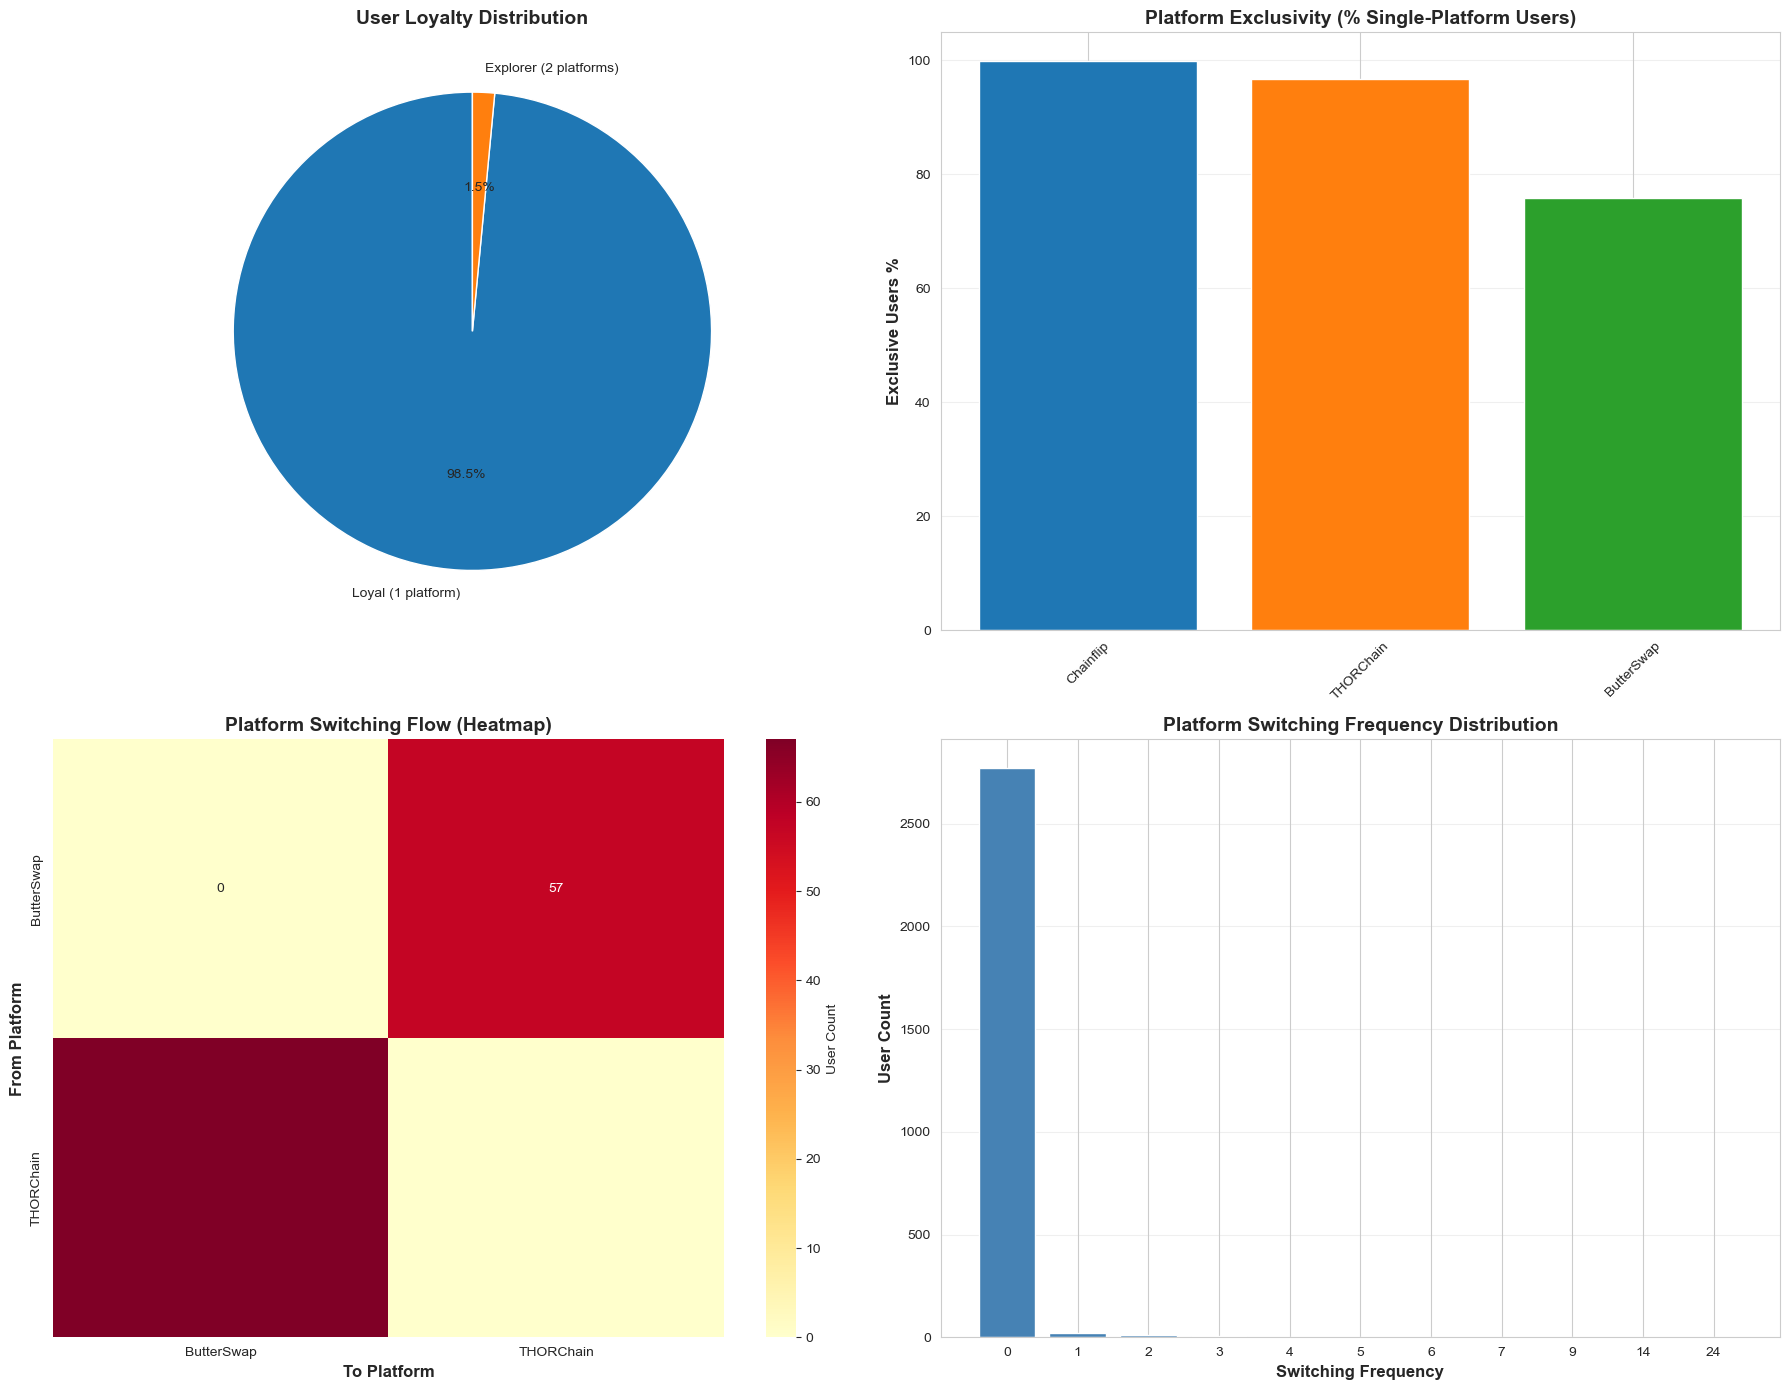



Summary:
  Average platforms per user: 1.01
  Users who switched platforms: 42 (1.5%)



In [21]:
# Cross-Platform User Switching & Loyalty Analysis
print("=" * 70)
print("CROSS-PLATFORM USER SWITCHING & LOYALTY ANALYSIS")
print("=" * 70)

required_cols = ['user_address', 'platform', 'timestamp']
if all(col in combined_df.columns for col in required_cols):
    # 1. For each user, identify platforms used and sequence
    user_platform_analysis = combined_df.groupby('user_address').agg({
        'platform': lambda x: list(x.unique()),
        'timestamp': ['min', 'max']
    })
    user_platform_analysis.columns = ['platforms_used', 'first_trade', 'last_trade']
    user_platform_analysis = user_platform_analysis.reset_index()
    
    user_platform_analysis['platform_count'] = user_platform_analysis['platforms_used'].apply(len)
    user_platform_analysis['platforms_str'] = user_platform_analysis['platforms_used'].apply(lambda x: ', '.join(sorted(x)))
    
    # 2. Calculate days on each platform per user
    user_platform_days = []
    for _, row in user_platform_analysis.iterrows():
        user_addr = row['user_address']
        user_trades = combined_df[combined_df['user_address'] == user_addr].sort_values('timestamp')
        platforms = user_trades['platform'].unique()
        
        for platform in platforms:
            platform_trades = user_trades[user_trades['platform'] == platform]
            days_on_platform = (platform_trades['timestamp'].max() - platform_trades['timestamp'].min()).days + 1
            user_platform_days.append({
                'user_address': user_addr,
                'platform': platform,
                'days_on_platform': days_on_platform,
                'trade_count': len(platform_trades)
            })
    
    platform_days_df = pd.DataFrame(user_platform_days)
    
    # 3. Classify loyalty
    def classify_loyalty(platform_count):
        if platform_count == 1:
            return 'Loyal (1 platform)'
        elif platform_count == 2:
            return 'Explorer (2 platforms)'
        else:
            return 'Arbitrageur (3+ platforms)'
    
    user_platform_analysis['loyalty_class'] = user_platform_analysis['platform_count'].apply(classify_loyalty)
    
    # 4. Identify platform sequence and switching
    user_platform_analysis['last_platform'] = combined_df.groupby('user_address')['platform'].last().values
    user_platform_analysis['first_platform'] = combined_df.groupby('user_address')['platform'].first().values
    
    # Calculate switching frequency
    user_switches = []
    for user_addr in user_platform_analysis['user_address'].unique():
        user_trades = combined_df[combined_df['user_address'] == user_addr].sort_values('timestamp')
        platform_changes = (user_trades['platform'] != user_trades['platform'].shift()).sum() - 1
        user_switches.append({
            'user_address': user_addr,
            'switching_frequency': max(0, platform_changes)
        })
    
    switches_df = pd.DataFrame(user_switches)
    user_platform_analysis = user_platform_analysis.merge(switches_df, on='user_address', how='left')
    
    # 5. Platform exclusivity analysis
    platform_exclusivity = {}
    for platform in combined_df['platform'].unique():
        platform_users = set(combined_df[combined_df['platform'] == platform]['user_address'].unique())
        exclusive_users = user_platform_analysis[
            (user_platform_analysis['platform_count'] == 1) & 
            (user_platform_analysis['platforms_str'] == platform)
        ]['user_address'].nunique()
        total_platform_users = len(platform_users)
        exclusivity_pct = (exclusive_users / total_platform_users * 100) if total_platform_users > 0 else 0
        
        # Find competitors (other platforms used by same users)
        multi_platform_users = user_platform_analysis[
            (user_platform_analysis['platform_count'] > 1) &
            (user_platform_analysis['platforms_str'].str.contains(platform))
        ]['user_address'].nunique()
        
        platform_exclusivity[platform] = {
            'exclusive_users': exclusive_users,
            'total_users': total_platform_users,
            'exclusivity_pct': exclusivity_pct,
            'multi_platform_users': multi_platform_users
        }
    
    # 6. Platform switching flow (A -> B)
    platform_switches = []
    for user_addr in user_platform_analysis[user_platform_analysis['platform_count'] > 1]['user_address'].unique():
        user_trades = combined_df[combined_df['user_address'] == user_addr].sort_values('timestamp')
        platforms = user_trades['platform'].values
        for i in range(len(platforms) - 1):
            if platforms[i] != platforms[i+1]:
                platform_switches.append({
                    'from_platform': platforms[i],
                    'to_platform': platforms[i+1]
                })
    
    if platform_switches:
        switch_flow = pd.DataFrame(platform_switches)
        switch_matrix = switch_flow.groupby(['from_platform', 'to_platform']).size().reset_index(name='count')
        
        print("\nPlatform Switching Flow:")
        print(switch_matrix.sort_values('count', ascending=False).head(20).to_string(index=False))
    
    # 7. Loyalty distribution
    loyalty_dist = user_platform_analysis['loyalty_class'].value_counts()
    print(f"\n\nLoyalty Classification:")
    for loyalty_type, count in loyalty_dist.items():
        pct = (count / len(user_platform_analysis) * 100)
        print(f"  {loyalty_type}: {count:,} users ({pct:.1f}%)")
    
    print(f"\n\nPlatform Exclusivity:")
    for platform, stats in platform_exclusivity.items():
        print(f"  {platform}: {stats['exclusivity_pct']:.1f}% exclusive users ({stats['exclusive_users']}/{stats['total_users']})")
        print(f"    Multi-platform users: {stats['multi_platform_users']}")
    
    # 8. Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Loyalty distribution pie chart
    axes[0, 0].pie(loyalty_dist.values, labels=loyalty_dist.index, autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('User Loyalty Distribution', fontsize=14, fontweight='bold')
    
    # Platform exclusivity bar chart
    platforms = list(platform_exclusivity.keys())
    exclusivity_pcts = [platform_exclusivity[p]['exclusivity_pct'] for p in platforms]
    axes[0, 1].bar(platforms, exclusivity_pcts, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[0, 1].set_ylabel('Exclusive Users %', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Platform Exclusivity (% Single-Platform Users)', fontsize=14, fontweight='bold')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Platform co-usage heatmap
    if platform_switches:
        pivot_switch = switch_matrix.pivot(index='from_platform', columns='to_platform', values='count').fillna(0)
        sns.heatmap(pivot_switch, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[1, 0], cbar_kws={'label': 'User Count'})
        axes[1, 0].set_title('Platform Switching Flow (Heatmap)', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('To Platform', fontsize=12, fontweight='bold')
        axes[1, 0].set_ylabel('From Platform', fontsize=12, fontweight='bold')
    else:
        axes[1, 0].text(0.5, 0.5, 'No platform switches detected', ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Platform Switching Flow', fontsize=14, fontweight='bold')
    
    # Switching frequency distribution
    switch_freq_dist = user_platform_analysis['switching_frequency'].value_counts().sort_index()
    axes[1, 1].bar(switch_freq_dist.index.astype(str), switch_freq_dist.values, color='steelblue')
    axes[1, 1].set_xlabel('Switching Frequency', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('User Count', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Platform Switching Frequency Distribution', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    avg_platforms = user_platform_analysis['platform_count'].mean()
    switchers_30d = user_platform_analysis[user_platform_analysis['switching_frequency'] > 0]
    switcher_pct = (len(switchers_30d) / len(user_platform_analysis) * 100) if len(user_platform_analysis) > 0 else 0
    
    print(f"\n\nSummary:")
    print(f"  Average platforms per user: {avg_platforms:.2f}")
    print(f"  Users who switched platforms: {len(switchers_30d):,} ({switcher_pct:.1f}%)")
    
    print("\n" + "=" * 70)
else:
    print("⚠ Missing required columns for switching analysis")


NEW USER ACQUISITION & COHORT GROWTH TRENDS

Weekly New User Acquisition:
                 week  new_users_count  wow_growth_pct
2024-11-25/2024-12-01                6        0.000000
2024-12-02/2024-12-08                9       50.000000
2024-12-09/2024-12-15               21      133.333333
2024-12-16/2024-12-22               29       38.095238
2024-12-23/2024-12-29               22      -24.137931
2024-12-30/2025-01-05               53      140.909091
2025-01-06/2025-01-12               48       -9.433962
2025-01-13/2025-01-19               42      -12.500000
2025-01-20/2025-01-26               46        9.523810
2025-01-27/2025-02-02               44       -4.347826
2025-02-03/2025-02-09               58       31.818182
2025-02-10/2025-02-16               46      -20.689655
2025-02-17/2025-02-23               38      -17.391304
2025-02-24/2025-03-02                9      -76.315789
2025-03-03/2025-03-09               25      177.777778
2025-03-10/2025-03-16               54      11

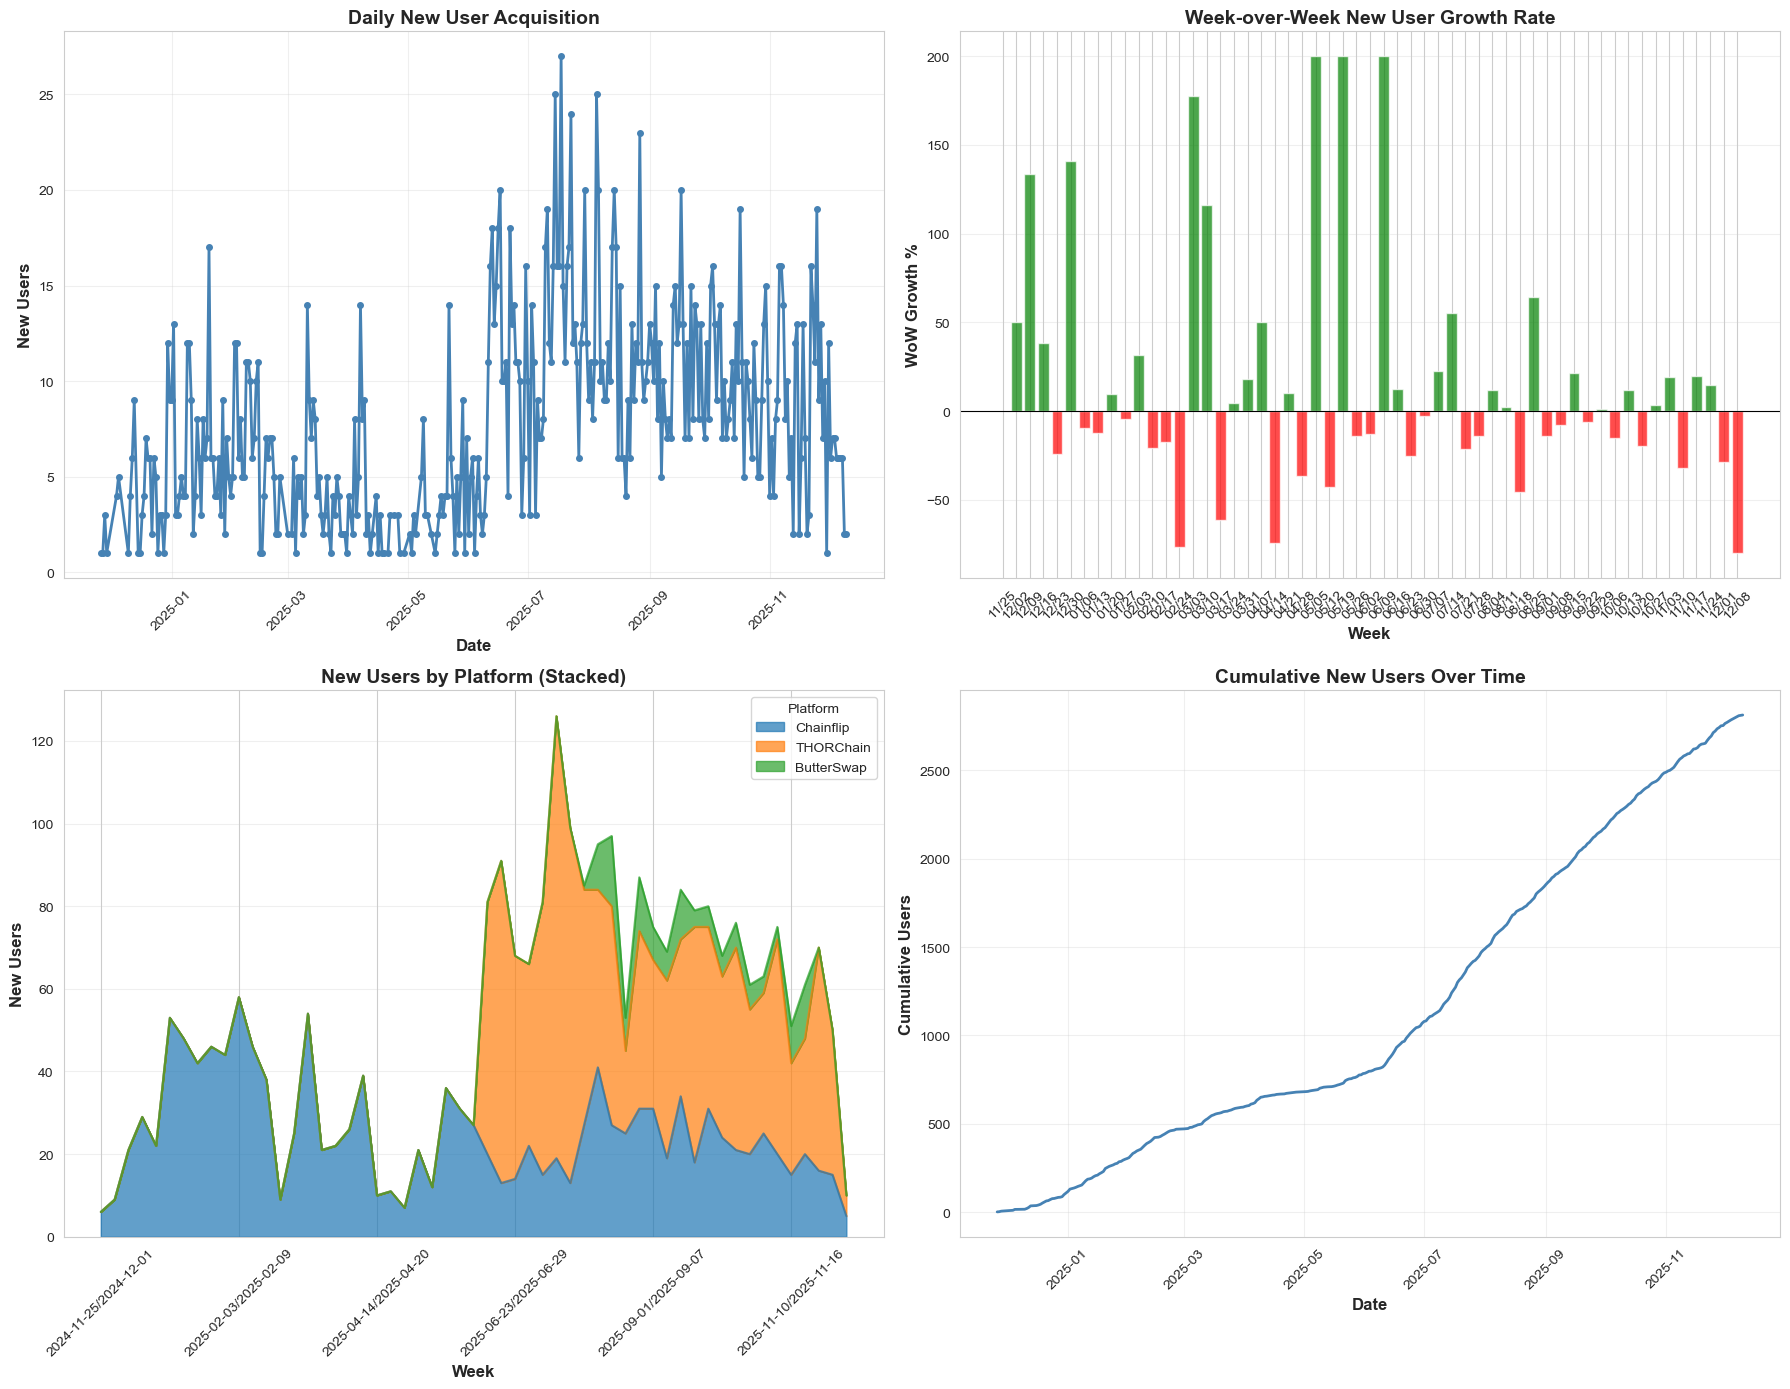

In [22]:
# New User Acquisition & Cohort Growth Trends
print("=" * 70)
print("NEW USER ACQUISITION & COHORT GROWTH TRENDS")
print("=" * 70)

required_cols = ['user_address', 'timestamp', 'platform']
if all(col in combined_df.columns for col in required_cols):
    # 1. Identify first trade date and first platform for each user
    user_first_trade = combined_df.groupby('user_address').agg({
        'timestamp': 'min',
        'platform': 'first'
    }).reset_index()
    user_first_trade.columns = ['user_address', 'first_trade_date', 'first_platform']
    
    # 2. Aggregate by week
    user_first_trade['first_trade_week'] = pd.to_datetime(user_first_trade['first_trade_date']).dt.to_period('W').astype(str)
    user_first_trade['first_trade_date_only'] = pd.to_datetime(user_first_trade['first_trade_date']).dt.date
    
    # Weekly new user acquisition
    weekly_new_users = user_first_trade.groupby('first_trade_week').agg({
        'user_address': 'count',
        'first_platform': lambda x: x.value_counts().to_dict()
    }).reset_index()
    weekly_new_users.columns = ['week', 'new_users_count', 'platform_breakdown']
    
    # Also aggregate by day
    daily_new_users = user_first_trade.groupby('first_trade_date_only').agg({
        'user_address': 'count'
    }).reset_index()
    daily_new_users.columns = ['date', 'new_users_count']
    daily_new_users = daily_new_users.sort_values('date')
    
    # 3. Calculate week-over-week growth
    weekly_new_users = weekly_new_users.sort_values('week')
    weekly_new_users['prev_week_users'] = weekly_new_users['new_users_count'].shift(1)
    weekly_new_users['wow_growth_pct'] = ((weekly_new_users['new_users_count'] - weekly_new_users['prev_week_users']) / 
                                          weekly_new_users['prev_week_users'] * 100).fillna(0)
    
    # 4. Platform breakdown of new users
    platform_acquisition = {}
    for platform in combined_df['platform'].unique():
        platform_first_trades = user_first_trade[user_first_trade['first_platform'] == platform]
        platform_acquisition[platform] = platform_first_trades.groupby('first_trade_week')['user_address'].count()
    
    # 5. Cumulative new users
    daily_new_users['cumulative_users'] = daily_new_users['new_users_count'].cumsum()
    weekly_new_users['cumulative_users'] = weekly_new_users['new_users_count'].cumsum()
    
    # 6. Print summary
    print("\nWeekly New User Acquisition:")
    print(weekly_new_users[['week', 'new_users_count', 'wow_growth_pct']].to_string(index=False))
    
    print(f"\n\nLatest Week Stats:")
    latest_week = weekly_new_users.iloc[-1]
    print(f"  New users this week: {latest_week['new_users_count']:.0f}")
    print(f"  Week-over-week growth: {latest_week['wow_growth_pct']:.1f}%")
    
    # Determine trend
    recent_growth = weekly_new_users['wow_growth_pct'].tail(4).mean()
    if recent_growth > 10:
        trend = "ACCELERATING"
    elif recent_growth > -5:
        trend = "STABLE"
    else:
        trend = "DECLINING"
    
    print(f"  Trend: {trend}")
    
    # Platform mix for latest period
    if len(weekly_new_users) > 0:
        latest_platform_breakdown = weekly_new_users.iloc[-1]['platform_breakdown']
        if isinstance(latest_platform_breakdown, dict):
            total_latest = sum(latest_platform_breakdown.values())
            print(f"\n  Platform mix (latest week):")
            for platform, count in latest_platform_breakdown.items():
                pct = (count / total_latest * 100) if total_latest > 0 else 0
                print(f"    {platform}: {count} ({pct:.1f}%)")
    
    # 7. Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Daily new user count over time
    axes[0, 0].plot(pd.to_datetime(daily_new_users['date']), daily_new_users['new_users_count'], 
                    marker='o', linewidth=2, markersize=4, color='steelblue')
    axes[0, 0].set_xlabel('Date', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('New Users', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Daily New User Acquisition', fontsize=14, fontweight='bold')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Week-over-week growth rate (bar chart)
    colors = ['green' if x > 0 else 'red' for x in weekly_new_users['wow_growth_pct']]
    axes[0, 1].bar(range(len(weekly_new_users)), weekly_new_users['wow_growth_pct'], color=colors, alpha=0.7)
    axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    axes[0, 1].set_xlabel('Week', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('WoW Growth %', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Week-over-Week New User Growth Rate', fontsize=14, fontweight='bold')
    axes[0, 1].set_xticks(range(len(weekly_new_users)))
    # Extract week labels - handle date range format (e.g., '2024-11-25/2024-12-01')
    def extract_week_label(week_str):
        if '/' in week_str:
            # Date range format: extract start date and format as MM/DD
            start_date = week_str.split('/')[0]
            try:
                date_obj = pd.to_datetime(start_date)
                return date_obj.strftime('%m/%d')
            except:
                return start_date[:5]  # Fallback to first 5 chars
        elif '-W' in week_str:
            # ISO week format: extract week number
            return week_str.split('-W')[1]
        else:
            # Fallback: use first part of string
            return week_str[:10]
    week_labels = [extract_week_label(w) for w in weekly_new_users['week']]
    axes[0, 1].set_xticklabels(week_labels, rotation=45)
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Stacked area chart - new users by platform per week
    if platform_acquisition:
        platform_weeks_df = pd.DataFrame(platform_acquisition).fillna(0)
        platform_weeks_df.plot(kind='area', stacked=True, ax=axes[1, 0], 
                               color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.7)
        axes[1, 0].set_xlabel('Week', fontsize=12, fontweight='bold')
        axes[1, 0].set_ylabel('New Users', fontsize=12, fontweight='bold')
        axes[1, 0].set_title('New Users by Platform (Stacked)', fontsize=14, fontweight='bold')
        axes[1, 0].legend(title='Platform')
        axes[1, 0].tick_params(axis='x', rotation=45)
        axes[1, 0].grid(True, alpha=0.3, axis='y')
    else:
        axes[1, 0].text(0.5, 0.5, 'No platform data available', ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('New Users by Platform', fontsize=14, fontweight='bold')
    
    # Cumulative new users
    axes[1, 1].plot(pd.to_datetime(daily_new_users['date']), daily_new_users['cumulative_users'], 
                   linewidth=2, color='steelblue')
    axes[1, 1].set_xlabel('Date', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Cumulative Users', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Cumulative New Users Over Time', fontsize=14, fontweight='bold')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
else:
    print("⚠ Missing required columns for acquisition analysis")


## Step 14: Improvement 4 - User Churn & Inactivity Detection


USER CHURN & INACTIVITY DETECTION

User Status Distribution:
  ACTIVE: 61 users (2.2%)
  AT_RISK: 256 users (9.1%)
  DORMANT: 692 users (24.6%)
  CHURNED: 1,805 users (64.1%)


Lifetime Value by Status:
         user_count  total_ltv  avg_ltv  median_ltv  total_volume  avg_trades
status                                                                       
CHURNED        1805   52167.98    28.90        0.90   40040908.28        2.15
DORMANT         692   59897.38    86.56        0.55   26730694.30        1.85
AT_RISK         256   14655.35    57.25        0.54    5012756.38        2.71
ACTIVE           61    3041.40    49.86        0.60    1928529.98        6.30


Churned User Analysis:
  Average trades before churn: 2.15
  Average last trade value by platform:
    ButterSwap: $3,863.68
    Chainflip: $31,218.85
    THORChain: $9,783.35


Churn Metrics:
  At-risk users: 256
  Daily churn rate: 0.08 users/day
  Average user lifetime: 11.6 days


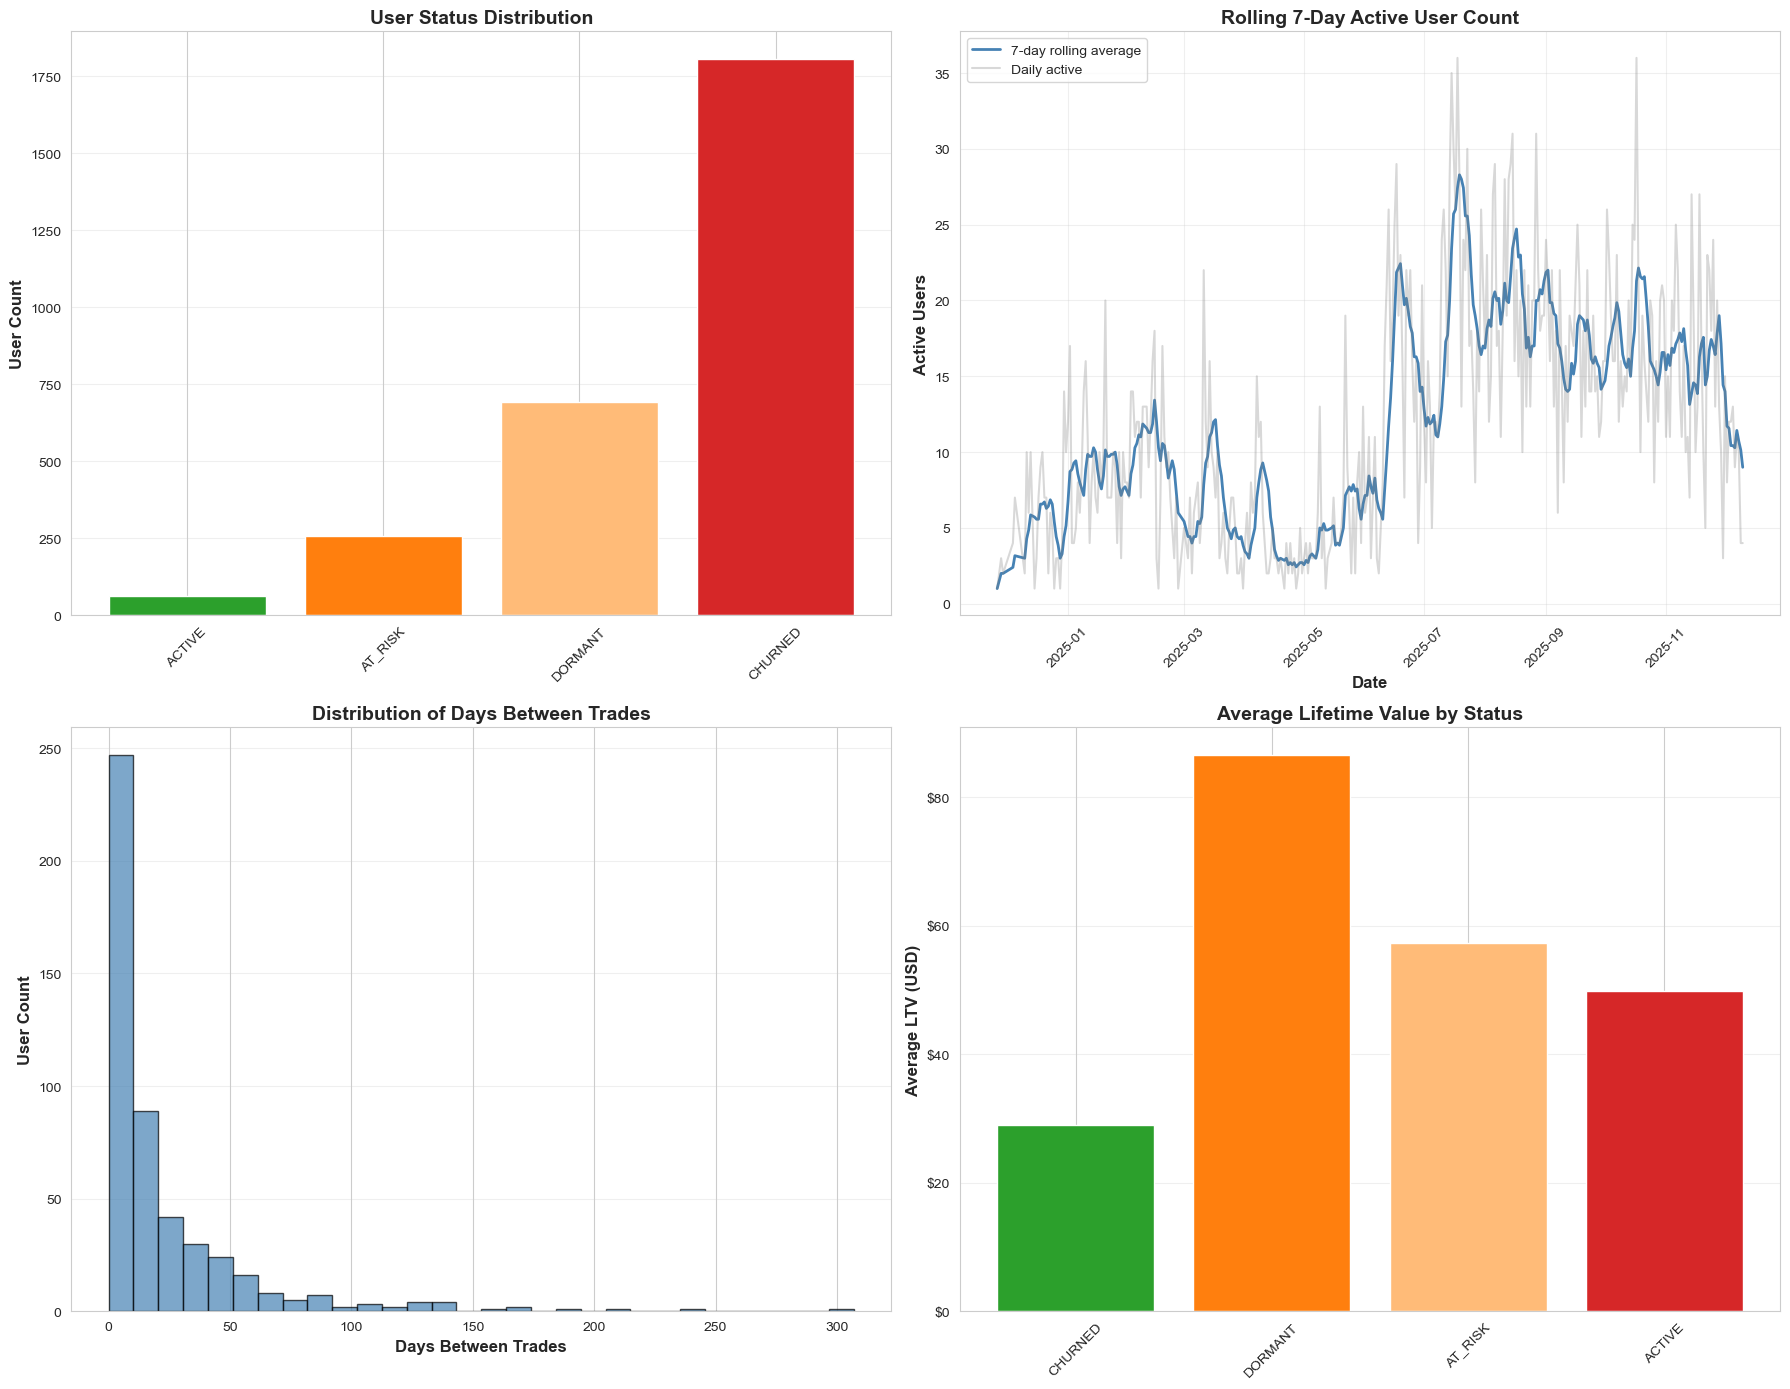

In [23]:
# User Churn & Inactivity Detection
print("=" * 70)
print("USER CHURN & INACTIVITY DETECTION")
print("=" * 70)

required_cols = ['user_address', 'timestamp', 'platform', 'swap_size']
if all(col in combined_df.columns for col in required_cols):
    # Get current date (use max timestamp as proxy)
    current_date = pd.to_datetime(combined_df['timestamp'].max())
    
    # 1. Calculate user metrics
    user_activity = combined_df.groupby('user_address').agg({
        'timestamp': ['max', 'min', 'count'],
        'swap_size': 'sum',
        'fee_usd': 'sum',
        'platform': 'last'
    })
    user_activity.columns = ['last_trade_date', 'first_trade_date', 'trade_count', 'total_volume', 'total_fees', 'last_platform']
    user_activity = user_activity.reset_index()
    
    # Calculate days since last trade
    user_activity['days_since_last_trade'] = (current_date - pd.to_datetime(user_activity['last_trade_date'])).dt.days
    
    # Calculate average days between trades
    def calc_avg_days_between(trades_df):
        if len(trades_df) < 2:
            return 0
        trades_sorted = trades_df.sort_values('timestamp')
        days_between = (trades_sorted['timestamp'].shift(-1) - trades_sorted['timestamp']).dt.days
        return days_between.mean()
    
    user_trade_intervals = combined_df.groupby('user_address').apply(
        lambda x: calc_avg_days_between(x[['timestamp']])
    ).reset_index(name='avg_days_between_trades')
    user_activity = user_activity.merge(user_trade_intervals, on='user_address', how='left')
    user_activity['avg_days_between_trades'] = user_activity['avg_days_between_trades'].fillna(0)
    
    # 2. Classify users by status
    def classify_status(days_since):
        if days_since < 7:
            return 'ACTIVE'
        elif days_since < 30:
            return 'AT_RISK'
        elif days_since < 90:
            return 'DORMANT'
        else:
            return 'CHURNED'
    
    user_activity['status'] = user_activity['days_since_last_trade'].apply(classify_status)
    
    # 3. Analyze churned users
    churned_users = user_activity[user_activity['status'] == 'CHURNED']
    
    # 4. Calculate LTV by status
    ltv_by_status = user_activity.groupby('status').agg({
        'user_address': 'count',
        'total_fees': ['sum', 'mean', 'median'],
        'total_volume': 'sum',
        'trade_count': 'mean'
    }).round(2)
    ltv_by_status.columns = ['user_count', 'total_ltv', 'avg_ltv', 'median_ltv', 'total_volume', 'avg_trades']
    ltv_by_status = ltv_by_status.sort_values('user_count', ascending=False)
    
    # 5. Print summary
    print("\nUser Status Distribution:")
    status_dist = user_activity['status'].value_counts()
    for status in ['ACTIVE', 'AT_RISK', 'DORMANT', 'CHURNED']:
        count = status_dist.get(status, 0)
        pct = (count / len(user_activity) * 100) if len(user_activity) > 0 else 0
        print(f"  {status}: {count:,} users ({pct:.1f}%)")
    
    print(f"\n\nLifetime Value by Status:")
    print(ltv_by_status.to_string())
    
    # Churn statistics
    if len(churned_users) > 0:
        avg_trades_before_churn = churned_users['trade_count'].mean()
        avg_last_trade_value = churned_users.groupby('last_platform')['total_volume'].mean()
        
        print(f"\n\nChurned User Analysis:")
        print(f"  Average trades before churn: {avg_trades_before_churn:.2f}")
        print(f"  Average last trade value by platform:")
        for platform, value in avg_last_trade_value.items():
            print(f"    {platform}: ${value:,.2f}")
    
    # Calculate daily churn rate
    churned_recent = user_activity[
        (user_activity['status'] == 'CHURNED') & 
        (user_activity['days_since_last_trade'] <= 90)
    ]
    daily_churn_rate = len(churned_recent) / 90 if len(churned_recent) > 0 else 0
    
    # Average user lifetime
    user_activity['lifetime_days'] = (pd.to_datetime(user_activity['last_trade_date']) - 
                                      pd.to_datetime(user_activity['first_trade_date'])).dt.days + 1
    avg_lifetime = user_activity['lifetime_days'].mean()
    
    print(f"\n\nChurn Metrics:")
    print(f"  At-risk users: {len(user_activity[user_activity['status'] == 'AT_RISK']):,}")
    print(f"  Daily churn rate: {daily_churn_rate:.2f} users/day")
    print(f"  Average user lifetime: {avg_lifetime:.1f} days")
    
    # 6. Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Waterfall chart (status flow)
    status_order = ['ACTIVE', 'AT_RISK', 'DORMANT', 'CHURNED']
    status_counts = [status_dist.get(s, 0) for s in status_order]
    colors_status = ['#2ca02c', '#ff7f0e', '#ffbb78', '#d62728']
    axes[0, 0].bar(status_order, status_counts, color=colors_status)
    axes[0, 0].set_ylabel('User Count', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('User Status Distribution', fontsize=14, fontweight='bold')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # Rolling 7-day active user count
    combined_df['date'] = pd.to_datetime(combined_df['timestamp']).dt.date
    daily_active = combined_df.groupby('date')['user_address'].nunique().reset_index()
    daily_active['rolling_7d'] = daily_active['user_address'].rolling(window=7, min_periods=1).mean()
    
    axes[0, 1].plot(pd.to_datetime(daily_active['date']), daily_active['rolling_7d'], 
                   linewidth=2, color='steelblue', label='7-day rolling average')
    axes[0, 1].plot(pd.to_datetime(daily_active['date']), daily_active['user_address'], 
                   alpha=0.3, color='gray', label='Daily active')
    axes[0, 1].set_xlabel('Date', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Active Users', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Rolling 7-Day Active User Count', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Histogram of days between trades
    non_zero_intervals = user_activity[user_activity['avg_days_between_trades'] > 0]['avg_days_between_trades']
    axes[1, 0].hist(non_zero_intervals, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[1, 0].set_xlabel('Days Between Trades', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('User Count', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Distribution of Days Between Trades', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # LTV by status
    axes[1, 1].bar(ltv_by_status.index, ltv_by_status['avg_ltv'], color=colors_status[:len(ltv_by_status)])
    axes[1, 1].set_ylabel('Average LTV (USD)', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Average Lifetime Value by Status', fontsize=14, fontweight='bold')
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].yaxis.set_major_formatter(plt.FuncFormatter(currency_formatter))
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
else:
    print("⚠ Missing required columns for churn analysis")


## Step 15: Improvement 5 - Asset Pair Performance Evolution & Growth Trends


ASSET PAIR PERFORMANCE EVOLUTION & GROWTH TRENDS

Top 10 Pairs by Current Volume:
     asset_pair  volume  mom_growth_pct         quadrant
RUNE → ETH.THOR    0.05      -96.062992 Declining (Dogs)


Rising Pairs (MoM growth >20%):
  None


Declining Pairs (MoM growth <-5%):
     asset_pair  volume  mom_growth_pct
RUNE → ETH.THOR    0.05      -96.062992


Most Stable Pairs (low volatility):
                                         asset_pair  volatility_pct  avg_volume
0x881Ba05de1E78f549cC63a8f6Cabb1d4AD32250D → PROMPT             0.0      116.01
   0x89d24A6b4CcB1B6fAA2625fE562bDD9a23260359 → ETH             0.0      117.16
                                       AAVE → ASTER             0.0    29919.03
                                         AAVE → BTC             0.0     9820.92
                                        AAVE → DOGE             0.0        0.16
                                        AAVE → LINK             0.0        0.00
                                         ABT → C

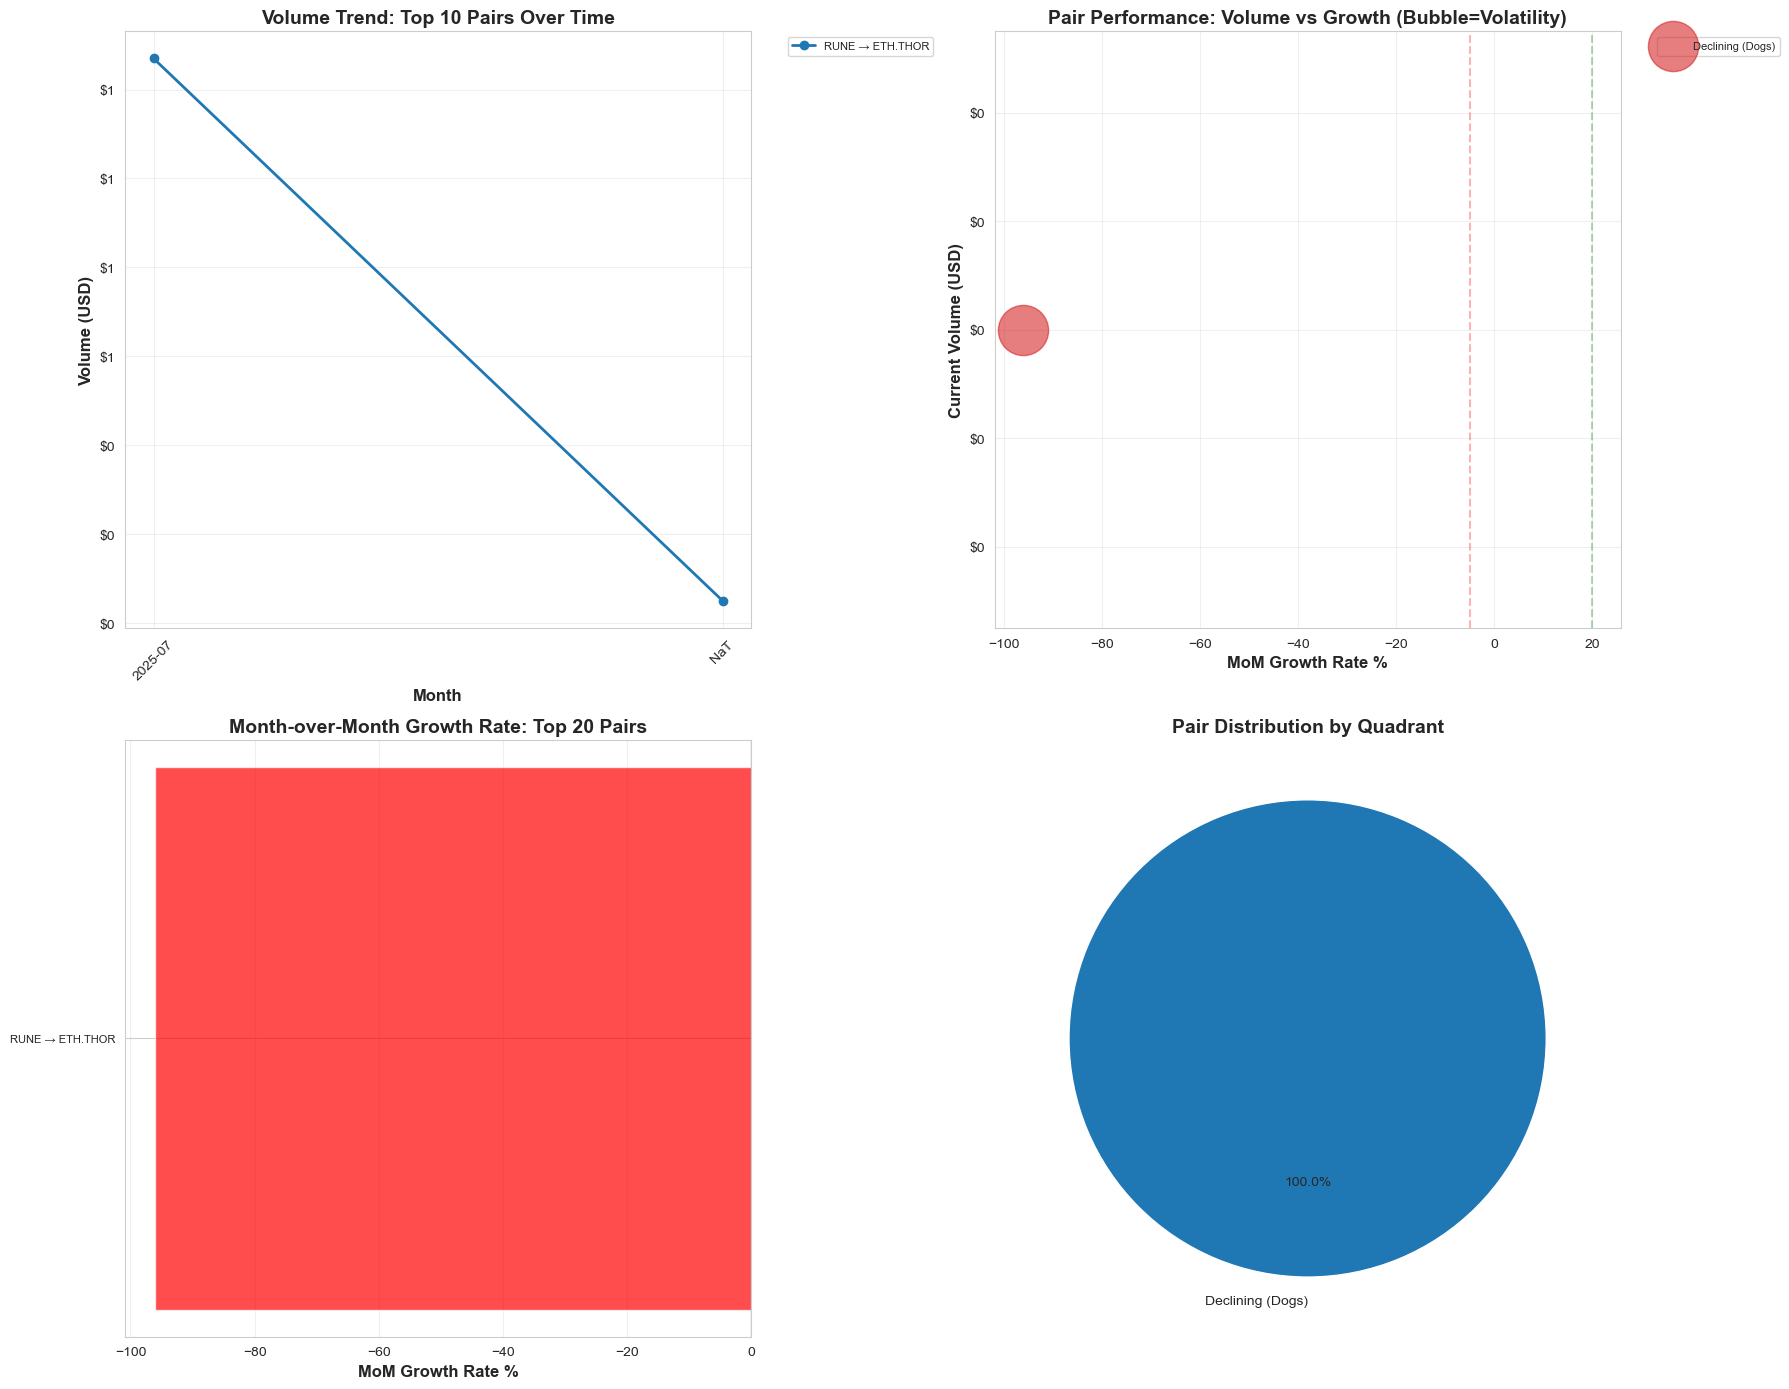

In [24]:
# Asset Pair Performance Evolution & Growth Trends
print("=" * 70)
print("ASSET PAIR PERFORMANCE EVOLUTION & GROWTH TRENDS")
print("=" * 70)

required_cols = ['asset_pair', 'timestamp', 'swap_size', 'fee_usd']
if all(col in combined_df.columns for col in required_cols):
    # Filter out invalid/unknown asset pairs
    valid_pairs_df = combined_df[
        (~combined_df['asset_pair'].str.contains('Unknown', case=False, na=False)) &
        (combined_df['asset_pair'] != 'Unknown → Unknown') &
        (combined_df['asset_pair'].notna())
    ].copy()
    
    # Ensure year_month exists
    if 'year_month' not in valid_pairs_df.columns:
        valid_pairs_df['year_month'] = pd.to_datetime(valid_pairs_df['timestamp']).dt.to_period('M').astype(str)
    
    # 1. Calculate monthly metrics for each pair
    monthly_pairs = valid_pairs_df.groupby(['year_month', 'asset_pair']).agg({
        'swap_size': ['sum', 'count', 'mean'],
        'fee_usd': 'sum'
    }).round(2)
    
    monthly_pairs.columns = ['volume', 'swap_count', 'avg_swap_size', 'revenue']
    monthly_pairs = monthly_pairs.reset_index()
    
    # Calculate fee bps (basis points)
    monthly_pairs['avg_fee_bps'] = (monthly_pairs['revenue'] / monthly_pairs['volume'] * 10000).fillna(0)
    
    # 2. Calculate month-over-month growth rates
    monthly_pairs = monthly_pairs.sort_values(['asset_pair', 'year_month'])
    monthly_pairs['prev_month_volume'] = monthly_pairs.groupby('asset_pair')['volume'].shift(1)
    monthly_pairs['mom_growth_pct'] = ((monthly_pairs['volume'] - monthly_pairs['prev_month_volume']) / 
                                       monthly_pairs['prev_month_volume'] * 100).fillna(0)
    
    # 3. Classify pairs by growth trend
    def classify_growth(mom_growth):
        if mom_growth > 20:
            return 'RISING'
        elif mom_growth < -5:
            return 'DECLINING'
        else:
            return 'STABLE'
    
    monthly_pairs['growth_class'] = monthly_pairs['mom_growth_pct'].apply(classify_growth)
    
    # 4. Calculate volatility (std dev of monthly volume)
    pair_volatility = monthly_pairs.groupby('asset_pair')['volume'].agg(['mean', 'std']).reset_index()
    pair_volatility['volatility_pct'] = (pair_volatility['std'] / pair_volatility['mean'] * 100).fillna(0)
    pair_volatility.columns = ['asset_pair', 'avg_volume', 'vol_std', 'volatility_pct']
    
    # Classify volatility
    def classify_volatility(vol_pct):
        if vol_pct > 50:
            return 'High'
        else:
            return 'Low'
    
    pair_volatility['volatility_class'] = pair_volatility['volatility_pct'].apply(classify_volatility)
    
    # Merge volatility back into monthly_pairs
    monthly_pairs = monthly_pairs.merge(pair_volatility[['asset_pair', 'volatility_class']], on='asset_pair', how='left')
    
    # 5. Create quadrants
    latest_month = monthly_pairs['year_month'].max()
    latest_pairs = monthly_pairs[monthly_pairs['year_month'] == latest_month].copy()
    
    # Ensure volatility_class exists - merge again if needed (handle duplicate column names)
    if 'volatility_class' not in latest_pairs.columns:
        latest_pairs = latest_pairs.merge(pair_volatility[['asset_pair', 'volatility_class']], on='asset_pair', how='left')
    # Handle case where merge created duplicate columns with suffixes
    if 'volatility_class_x' in latest_pairs.columns:
        latest_pairs['volatility_class'] = latest_pairs['volatility_class_x'].fillna(latest_pairs.get('volatility_class_y', 'Low'))
        latest_pairs = latest_pairs.drop(columns=[col for col in latest_pairs.columns if 'volatility_class_' in col and col != 'volatility_class'])
    elif 'volatility_class_y' in latest_pairs.columns:
        latest_pairs['volatility_class'] = latest_pairs['volatility_class_y'].fillna('Low')
        latest_pairs = latest_pairs.drop(columns=[col for col in latest_pairs.columns if 'volatility_class_' in col])
    
    # Fill any missing volatility_class values
    latest_pairs['volatility_class'] = latest_pairs['volatility_class'].fillna('Low')
    
    # Also merge volatility_pct for visualization
    if 'volatility_pct' not in latest_pairs.columns:
        latest_pairs = latest_pairs.merge(pair_volatility[['asset_pair', 'volatility_pct']], on='asset_pair', how='left')
        latest_pairs['volatility_pct'] = latest_pairs['volatility_pct'].fillna(0)
    
    def assign_quadrant(row):
        growth = row.get('growth_class', 'STABLE')
        vol = row.get('volatility_class', 'Low')
        if pd.isna(vol):
            vol = 'Low'
        if growth == 'RISING' and vol == 'Low':
            return 'Rising+Stable (Stars)'
        elif growth == 'RISING' and vol == 'High':
            return 'Rising+Volatile (Risky Growth)'
        elif growth == 'STABLE':
            return 'Stable (Cash Cows)'
        else:
            return 'Declining (Dogs)'
    
    latest_pairs['quadrant'] = latest_pairs.apply(assign_quadrant, axis=1)
    
    # 6. Identify new pairs (first appeared in last 3 months)
    pair_first_appearance = valid_pairs_df.groupby('asset_pair')['year_month'].min().reset_index()
    pair_first_appearance.columns = ['asset_pair', 'first_month']
    
    # Filter out unknown pairs from new pairs
    pair_first_appearance = pair_first_appearance[
        (~pair_first_appearance['asset_pair'].str.contains('Unknown', case=False, na=False)) &
        (pair_first_appearance['asset_pair'] != 'Unknown → Unknown')
    ]
    
    recent_months = sorted(valid_pairs_df['year_month'].unique())[-3:]
    new_pairs = pair_first_appearance[pair_first_appearance['first_month'].isin(recent_months)]
    
    # Filter out unknown pairs from latest_pairs for display
    latest_pairs_clean = latest_pairs[
        (~latest_pairs['asset_pair'].str.contains('Unknown', case=False, na=False)) &
        (latest_pairs['asset_pair'] != 'Unknown → Unknown')
    ].copy()
    
    print("\nTop 10 Pairs by Current Volume:")
    top_10_current = latest_pairs_clean.nlargest(10, 'volume')[['asset_pair', 'volume', 'mom_growth_pct', 'quadrant']]
    print(top_10_current.to_string(index=False))
    
    print(f"\n\nRising Pairs (MoM growth >20%):")
    rising = latest_pairs_clean[latest_pairs_clean['growth_class'] == 'RISING'].sort_values('mom_growth_pct', ascending=False)
    if len(rising) > 0:
        print(rising[['asset_pair', 'volume', 'mom_growth_pct']].head(10).to_string(index=False))
    else:
        print("  None")
    
    print(f"\n\nDeclining Pairs (MoM growth <-5%):")
    declining = latest_pairs_clean[latest_pairs_clean['growth_class'] == 'DECLINING'].sort_values('mom_growth_pct')
    if len(declining) > 0:
        print(declining[['asset_pair', 'volume', 'mom_growth_pct']].head(10).to_string(index=False))
    else:
        print("  None")
    
    print(f"\n\nMost Stable Pairs (low volatility):")
    # Filter out unknown pairs from volatility data
    pair_volatility_clean = pair_volatility[
        (~pair_volatility['asset_pair'].str.contains('Unknown', case=False, na=False)) &
        (pair_volatility['asset_pair'] != 'Unknown → Unknown')
    ]
    stable_pairs = pair_volatility_clean.nsmallest(10, 'volatility_pct')[['asset_pair', 'volatility_pct', 'avg_volume']]
    print(stable_pairs.to_string(index=False))
    
    if len(rising) > 0:
        highest_growth = rising.iloc[0]
        print(f"\n\nHighest Growth: {highest_growth['asset_pair']} (+{highest_growth['mom_growth_pct']:.1f}% MoM)")
    
    if len(new_pairs) > 0:
        print(f"\n\nNew Pairs (last 3 months): {len(new_pairs)} pairs")
        print(new_pairs[['asset_pair', 'first_month']].head(10).to_string(index=False))
    
    # 7. Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Line chart: volume trend for top 10 pairs over time (exclude unknown pairs)
    top_10_pairs_list = latest_pairs_clean.nlargest(10, 'volume')['asset_pair'].tolist()
    top_10_monthly = monthly_pairs[monthly_pairs['asset_pair'].isin(top_10_pairs_list)]
    
    for pair in top_10_pairs_list[:10]:
        pair_data = top_10_monthly[top_10_monthly['asset_pair'] == pair].sort_values('year_month')
        axes[0, 0].plot(pair_data['year_month'], pair_data['volume'], marker='o', label=pair[:20], linewidth=2)
    
    axes[0, 0].set_xlabel('Month', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Volume (USD)', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Volume Trend: Top 10 Pairs Over Time', fontsize=14, fontweight='bold')
    axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(currency_formatter))
    axes[0, 0].grid(True, alpha=0.3)
    
    # Bubble chart: current volume vs growth rate (exclude unknown pairs)
    if len(latest_pairs_clean) > 0:
        quadrant_colors = {
            'Rising+Stable (Stars)': '#2ca02c',
            'Rising+Volatile (Risky Growth)': '#ff7f0e',
            'Stable (Cash Cows)': '#1f77b4',
            'Declining (Dogs)': '#d62728'
        }
        
        for quadrant in latest_pairs_clean['quadrant'].unique():
            quadrant_data = latest_pairs_clean[latest_pairs_clean['quadrant'] == quadrant]
            axes[0, 1].scatter(quadrant_data['mom_growth_pct'], quadrant_data['volume'], 
                             s=quadrant_data['volatility_pct']*10, 
                             c=quadrant_colors.get(quadrant, 'gray'),
                             alpha=0.6, label=quadrant)
        
        axes[0, 1].set_xlabel('MoM Growth Rate %', fontsize=12, fontweight='bold')
        axes[0, 1].set_ylabel('Current Volume (USD)', fontsize=12, fontweight='bold')
        axes[0, 1].set_title('Pair Performance: Volume vs Growth (Bubble=Volatility)', fontsize=14, fontweight='bold')
        axes[0, 1].axvline(x=20, color='green', linestyle='--', alpha=0.3)
        axes[0, 1].axvline(x=-5, color='red', linestyle='--', alpha=0.3)
        axes[0, 1].legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        axes[0, 1].yaxis.set_major_formatter(plt.FuncFormatter(currency_formatter))
        axes[0, 1].grid(True, alpha=0.3)
    
    # Bar chart: MoM growth rate for each pair (top 20, exclude unknown pairs)
    top_20_growth = latest_pairs_clean.nlargest(20, 'volume')
    colors_growth = ['green' if x > 20 else 'orange' if x > -5 else 'red' for x in top_20_growth['mom_growth_pct']]
    axes[1, 0].barh(range(len(top_20_growth)), top_20_growth['mom_growth_pct'], color=colors_growth, alpha=0.7)
    axes[1, 0].set_yticks(range(len(top_20_growth)))
    axes[1, 0].set_yticklabels([p[:30] for p in top_20_growth['asset_pair']], fontsize=8)
    axes[1, 0].set_xlabel('MoM Growth Rate %', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Month-over-Month Growth Rate: Top 20 Pairs', fontsize=14, fontweight='bold')
    axes[1, 0].axvline(x=0, color='black', linestyle='-', linewidth=0.8)
    axes[1, 0].grid(True, alpha=0.3, axis='x')
    
    # Quadrant distribution (exclude unknown pairs)
    quadrant_dist = latest_pairs_clean['quadrant'].value_counts()
    axes[1, 1].pie(quadrant_dist.values, labels=quadrant_dist.index, autopct='%1.1f%%', startangle=90)
    axes[1, 1].set_title('Pair Distribution by Quadrant', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
else:
    print("⚠ Missing required columns for pair performance analysis")


## Step 16: Improvement 6 - Platform Performance Comparison by Execution Quality


PLATFORM PERFORMANCE COMPARISON BY EXECUTION QUALITY

Platform Slippage Statistics:
     platform  median_slippage  mean_slippage  std_slippage  trade_count  pct_low_slippage
0  ButterSwap           0.0000         0.0000        0.0000          450        100.000000
1   Chainflip           0.8312         1.3854        2.9838         2675          1.682243
2   THORChain          -0.6928        -0.7888       10.0012          957          7.314525


Best Execution (lowest median slippage):
  0: 0.0000% median slippage


Worst Execution (highest median slippage):
  1: 0.8312% median slippage


Slippage by Swap Size Bucket:
size_bucket  $100-1k  $1k-10k   <$100   >$10k
platform                                     
ButterSwap    0.0000   0.0000  0.0000  0.0000
Chainflip     0.8842   0.7780  2.3029  0.7565
THORChain    -0.8730  -0.3296  0.8847  0.6790


Outliers (>5% slippage):
 platform  outlier_count
Chainflip            109
THORChain            132


Peak Hour Impact:
            Off-Peak  

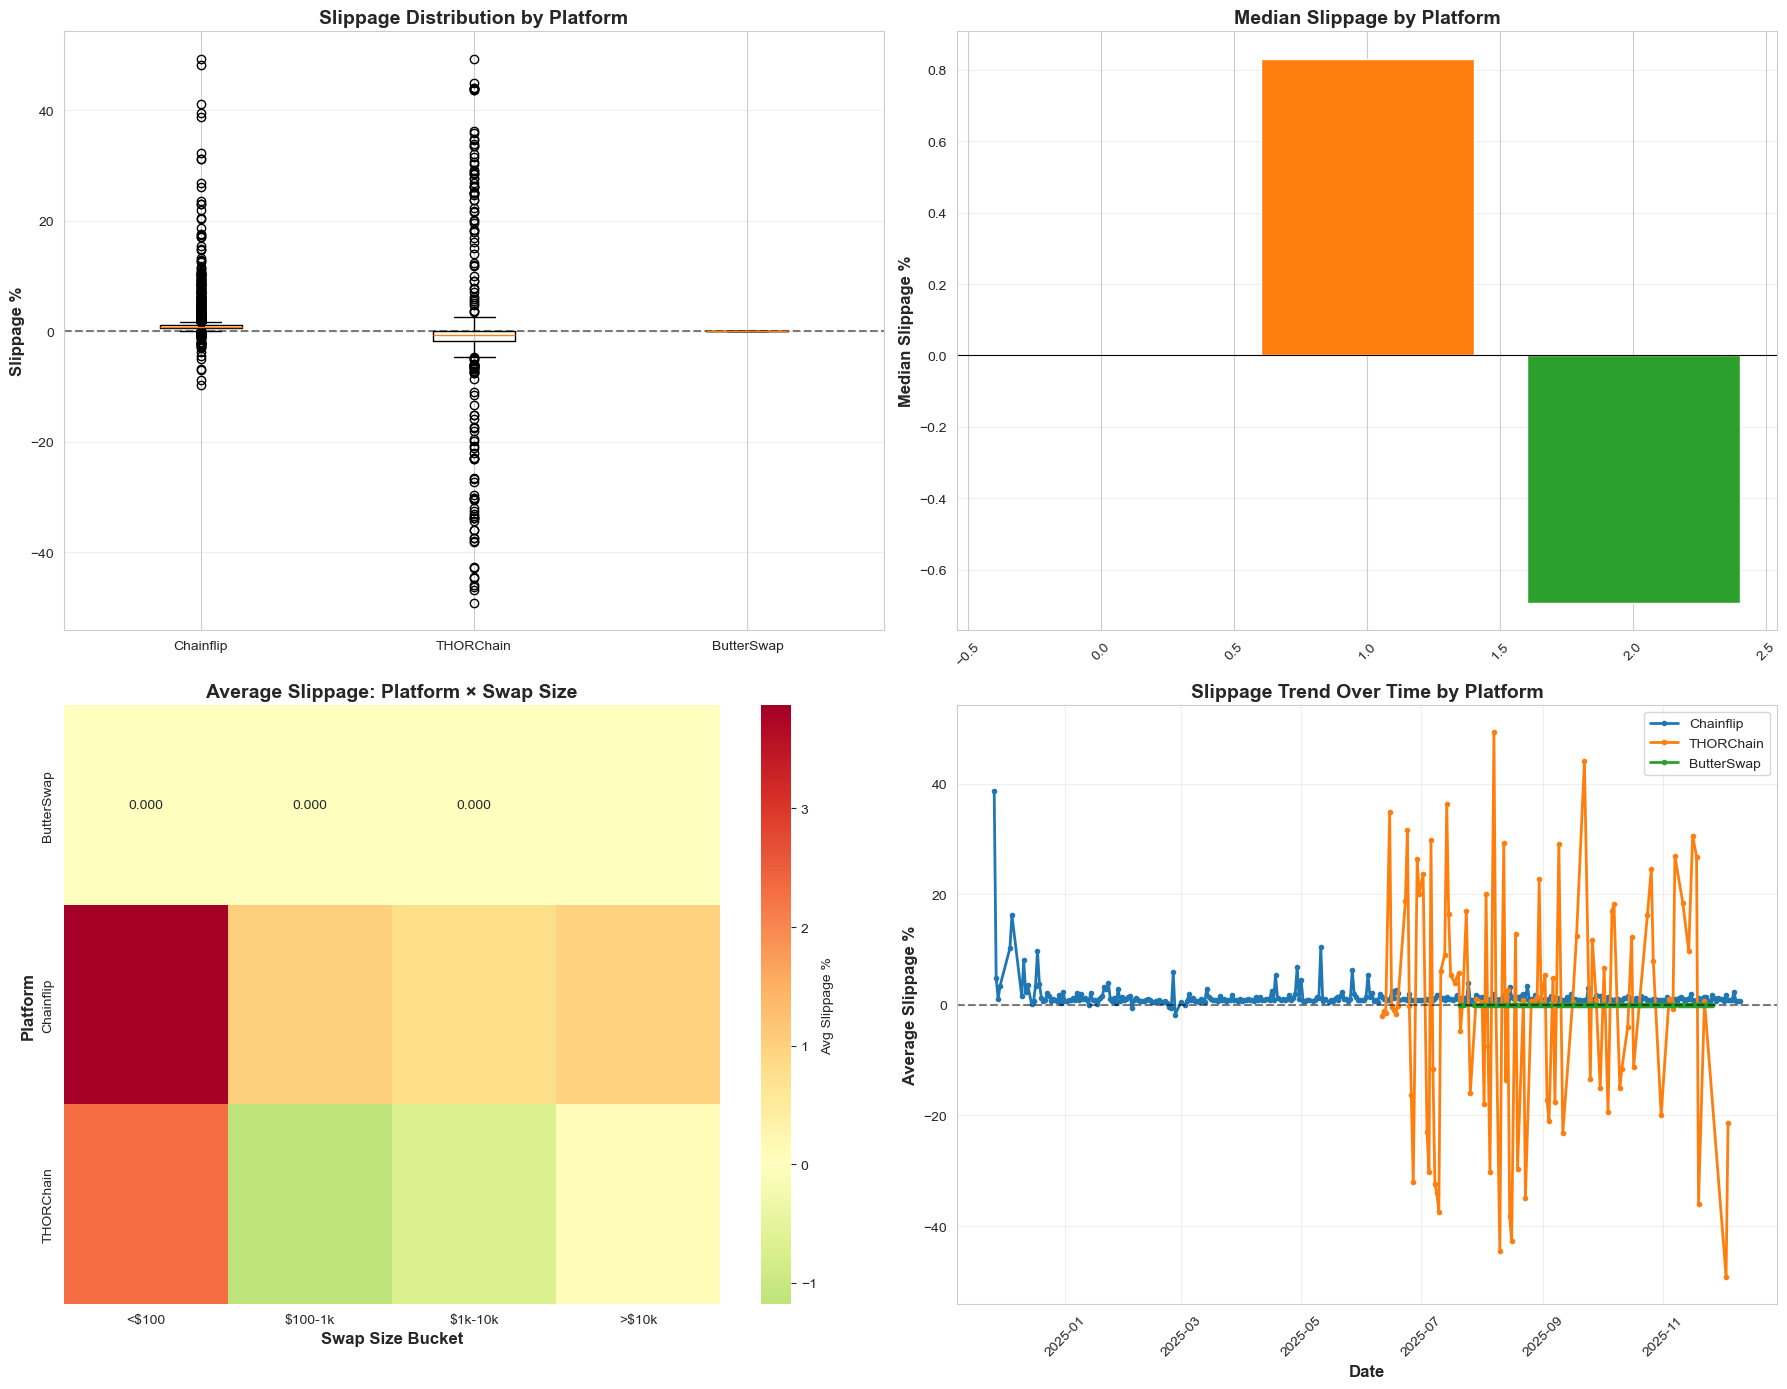

In [25]:
# Platform Performance Comparison by Execution Quality
print("=" * 70)
print("PLATFORM PERFORMANCE COMPARISON BY EXECUTION QUALITY")
print("=" * 70)

required_cols = ['platform', 'from_amount_usd', 'to_amount_usd', 'swap_size', 'timestamp']
if all(col in combined_df.columns for col in required_cols):
    # 1. Calculate slippage for each swap
    # Slippage = (from_amount - to_amount) / from_amount * 100
    # Note: This assumes from_amount_usd and to_amount_usd are comparable
    # In reality, slippage should account for exchange rates, but we'll use this as proxy
    
    execution_df = combined_df.copy()
    
    # Use swap_size as from_amount_usd if available
    if 'swap_size' in execution_df.columns:
        execution_df['from_amt'] = execution_df['swap_size']
    else:
        execution_df['from_amt'] = execution_df['from_amount_usd']
    
    # Calculate slippage (simplified - assumes to_amount_usd represents value received)
    execution_df['slippage_pct'] = ((execution_df['from_amt'] - execution_df['to_amount_usd']) / 
                                    execution_df['from_amt'] * 100).fillna(0)
    
    # Remove extreme outliers (likely data errors)
    execution_df = execution_df[(execution_df['slippage_pct'] >= -50) & (execution_df['slippage_pct'] <= 50)]
    
    # 2. Platform-level slippage statistics
    platform_slippage = execution_df.groupby('platform')['slippage_pct'].agg([
        'median', 'mean', 'std', 'count'
    ]).round(4)
    platform_slippage.columns = ['median_slippage', 'mean_slippage', 'std_slippage', 'trade_count']
    
    # Calculate % trades with <0.1% slippage
    low_slippage_pct = execution_df.groupby('platform').apply(
        lambda x: (x['slippage_pct'].abs() < 0.1).sum() / len(x) * 100
    ).reset_index(name='pct_low_slippage')
    platform_slippage = platform_slippage.merge(low_slippage_pct, on='platform', how='left')
    
    # 3. Slippage by swap size bucket
    def bucket_size(size):
        if size < 100:
            return '<$100'
        elif size < 1000:
            return '$100-1k'
        elif size < 10000:
            return '$1k-10k'
        else:
            return '>$10k'
    
    execution_df['size_bucket'] = execution_df['from_amt'].apply(bucket_size)
    
    size_bucket_slippage = execution_df.groupby(['platform', 'size_bucket'])['slippage_pct'].agg([
        'median', 'mean', 'count'
    ]).round(4)
    size_bucket_slippage.columns = ['median_slippage', 'mean_slippage', 'trade_count']
    size_bucket_slippage = size_bucket_slippage.reset_index()
    
    # 4. Calculate avg transaction cost as % of volume
    if 'fee_usd' in execution_df.columns:
        execution_df['cost_pct'] = (execution_df['fee_usd'] / execution_df['from_amt'] * 100).fillna(0)
        platform_cost = execution_df.groupby('platform')['cost_pct'].mean().reset_index(name='avg_cost_pct')
    else:
        platform_cost = pd.DataFrame()
    
    # 5. Identify outliers (>5% slippage)
    outliers = execution_df[execution_df['slippage_pct'].abs() > 5]
    outlier_summary = outliers.groupby('platform').size().reset_index(name='outlier_count')
    
    # 6. Time-based analysis (peak hours)
    execution_df['hour'] = pd.to_datetime(execution_df['timestamp']).dt.hour
    execution_df['is_peak'] = execution_df['hour'].between(9, 17)  # 9am-5pm as peak
    
    peak_slippage = execution_df.groupby(['platform', 'is_peak'])['slippage_pct'].mean().reset_index(name='avg_slippage')
    peak_slippage_pivot = peak_slippage.pivot(index='platform', columns='is_peak', values='avg_slippage')
    peak_slippage_pivot.columns = ['Off-Peak', 'Peak']
    peak_slippage_pivot['peak_increase_pct'] = ((peak_slippage_pivot['Peak'] - peak_slippage_pivot['Off-Peak']) / 
                                                 peak_slippage_pivot['Off-Peak'].abs() * 100).fillna(0)
    
    # Print summary
    print("\nPlatform Slippage Statistics:")
    print(platform_slippage.to_string())
    
    print(f"\n\nBest Execution (lowest median slippage):")
    best_platform = platform_slippage.loc[platform_slippage['median_slippage'].abs().idxmin()]
    print(f"  {best_platform.name}: {best_platform['median_slippage']:.4f}% median slippage")
    
    print(f"\n\nWorst Execution (highest median slippage):")
    worst_platform = platform_slippage.loc[platform_slippage['median_slippage'].abs().idxmax()]
    print(f"  {worst_platform.name}: {worst_platform['median_slippage']:.4f}% median slippage")
    
    print(f"\n\nSlippage by Swap Size Bucket:")
    print(size_bucket_slippage.pivot(index='platform', columns='size_bucket', values='median_slippage').to_string())
    
    if len(outlier_summary) > 0:
        print(f"\n\nOutliers (>5% slippage):")
        print(outlier_summary.to_string(index=False))
    
    if len(peak_slippage_pivot) > 0:
        print(f"\n\nPeak Hour Impact:")
        print(peak_slippage_pivot.to_string())
        for platform in peak_slippage_pivot.index:
            increase = peak_slippage_pivot.loc[platform, 'peak_increase_pct']
            print(f"  {platform}: Peak hour slippage increases by {increase:.1f}%")
    
    # 7. Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Box plot: platform vs slippage distribution
    platform_list = execution_df['platform'].unique()
    box_data = [execution_df[execution_df['platform'] == p]['slippage_pct'].values for p in platform_list]
    axes[0, 0].boxplot(box_data, labels=platform_list)
    axes[0, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[0, 0].set_ylabel('Slippage %', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Slippage Distribution by Platform', fontsize=14, fontweight='bold')
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    
    # Bar chart: median slippage by platform
    axes[0, 1].bar(platform_slippage.index, platform_slippage['median_slippage'], 
                   color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    axes[0, 1].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    axes[0, 1].set_ylabel('Median Slippage %', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Median Slippage by Platform', fontsize=14, fontweight='bold')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Heatmap: platform × swap_size vs avg slippage
    if len(size_bucket_slippage) > 0:
        heatmap_data = size_bucket_slippage.pivot(index='platform', columns='size_bucket', values='mean_slippage')
        bucket_order = ['<$100', '$100-1k', '$1k-10k', '>$10k']
        heatmap_data = heatmap_data[[b for b in bucket_order if b in heatmap_data.columns]]
        sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn_r', center=0, 
                   ax=axes[1, 0], cbar_kws={'label': 'Avg Slippage %'})
        axes[1, 0].set_title('Average Slippage: Platform × Swap Size', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Swap Size Bucket', fontsize=12, fontweight='bold')
        axes[1, 0].set_ylabel('Platform', fontsize=12, fontweight='bold')
    else:
        axes[1, 0].text(0.5, 0.5, 'No size bucket data available', ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Slippage by Size Bucket', fontsize=14, fontweight='bold')
    
    # Line chart: slippage trend over time by platform
    execution_df['date'] = pd.to_datetime(execution_df['timestamp']).dt.date
    daily_slippage = execution_df.groupby(['date', 'platform'])['slippage_pct'].mean().reset_index()
    
    for platform in platform_list:
        platform_data = daily_slippage[daily_slippage['platform'] == platform].sort_values('date')
        axes[1, 1].plot(pd.to_datetime(platform_data['date']), platform_data['slippage_pct'], 
                       marker='o', label=platform, linewidth=2, markersize=3)
    
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].set_xlabel('Date', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Average Slippage %', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Slippage Trend Over Time by Platform', fontsize=14, fontweight='bold')
    axes[1, 1].legend()
    axes[1, 1].tick_params(axis='x', rotation=45)
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
else:
    print("⚠ Missing required columns for execution quality analysis")


## Step 17: Improvement 7 - User Segmentation by Lifetime Value (LTV) & Profitability


USER SEGMENTATION BY LIFETIME VALUE (LTV) & PROFITABILITY

User Segmentation by Tier:
             tier  user_count  total_volume  total_revenue  avg_ltv  median_ltv  pct_of_users  pct_of_revenue  retention_pct
    Tier0 (<$100)        1152      14779.84          62.21     0.05        0.00         40.94            0.05       9.982639
  Tier1 ($100-1k)         529     222299.64         796.86     1.51        1.23         18.80            0.61      20.982987
  Tier2 ($1k-10k)         639    2554068.15        4338.47     6.79        3.18         22.71            3.34      36.306729
Tier3 ($10k-100k)         377   12568947.53       21076.54    55.91       18.57         13.40           16.24      47.480106
   Tier4 (>$100k)         117   58352793.80      103488.03   884.51      193.30          4.16           79.75      61.538462


Tier Summary:
  Tier0 (<$100): 1152 users (40.9% of base), $62.21 revenue (0.1% of total)
    Avg LTV: $0.05, Retention: 10.0%
  Tier1 ($100-1k): 529 users (18.8%

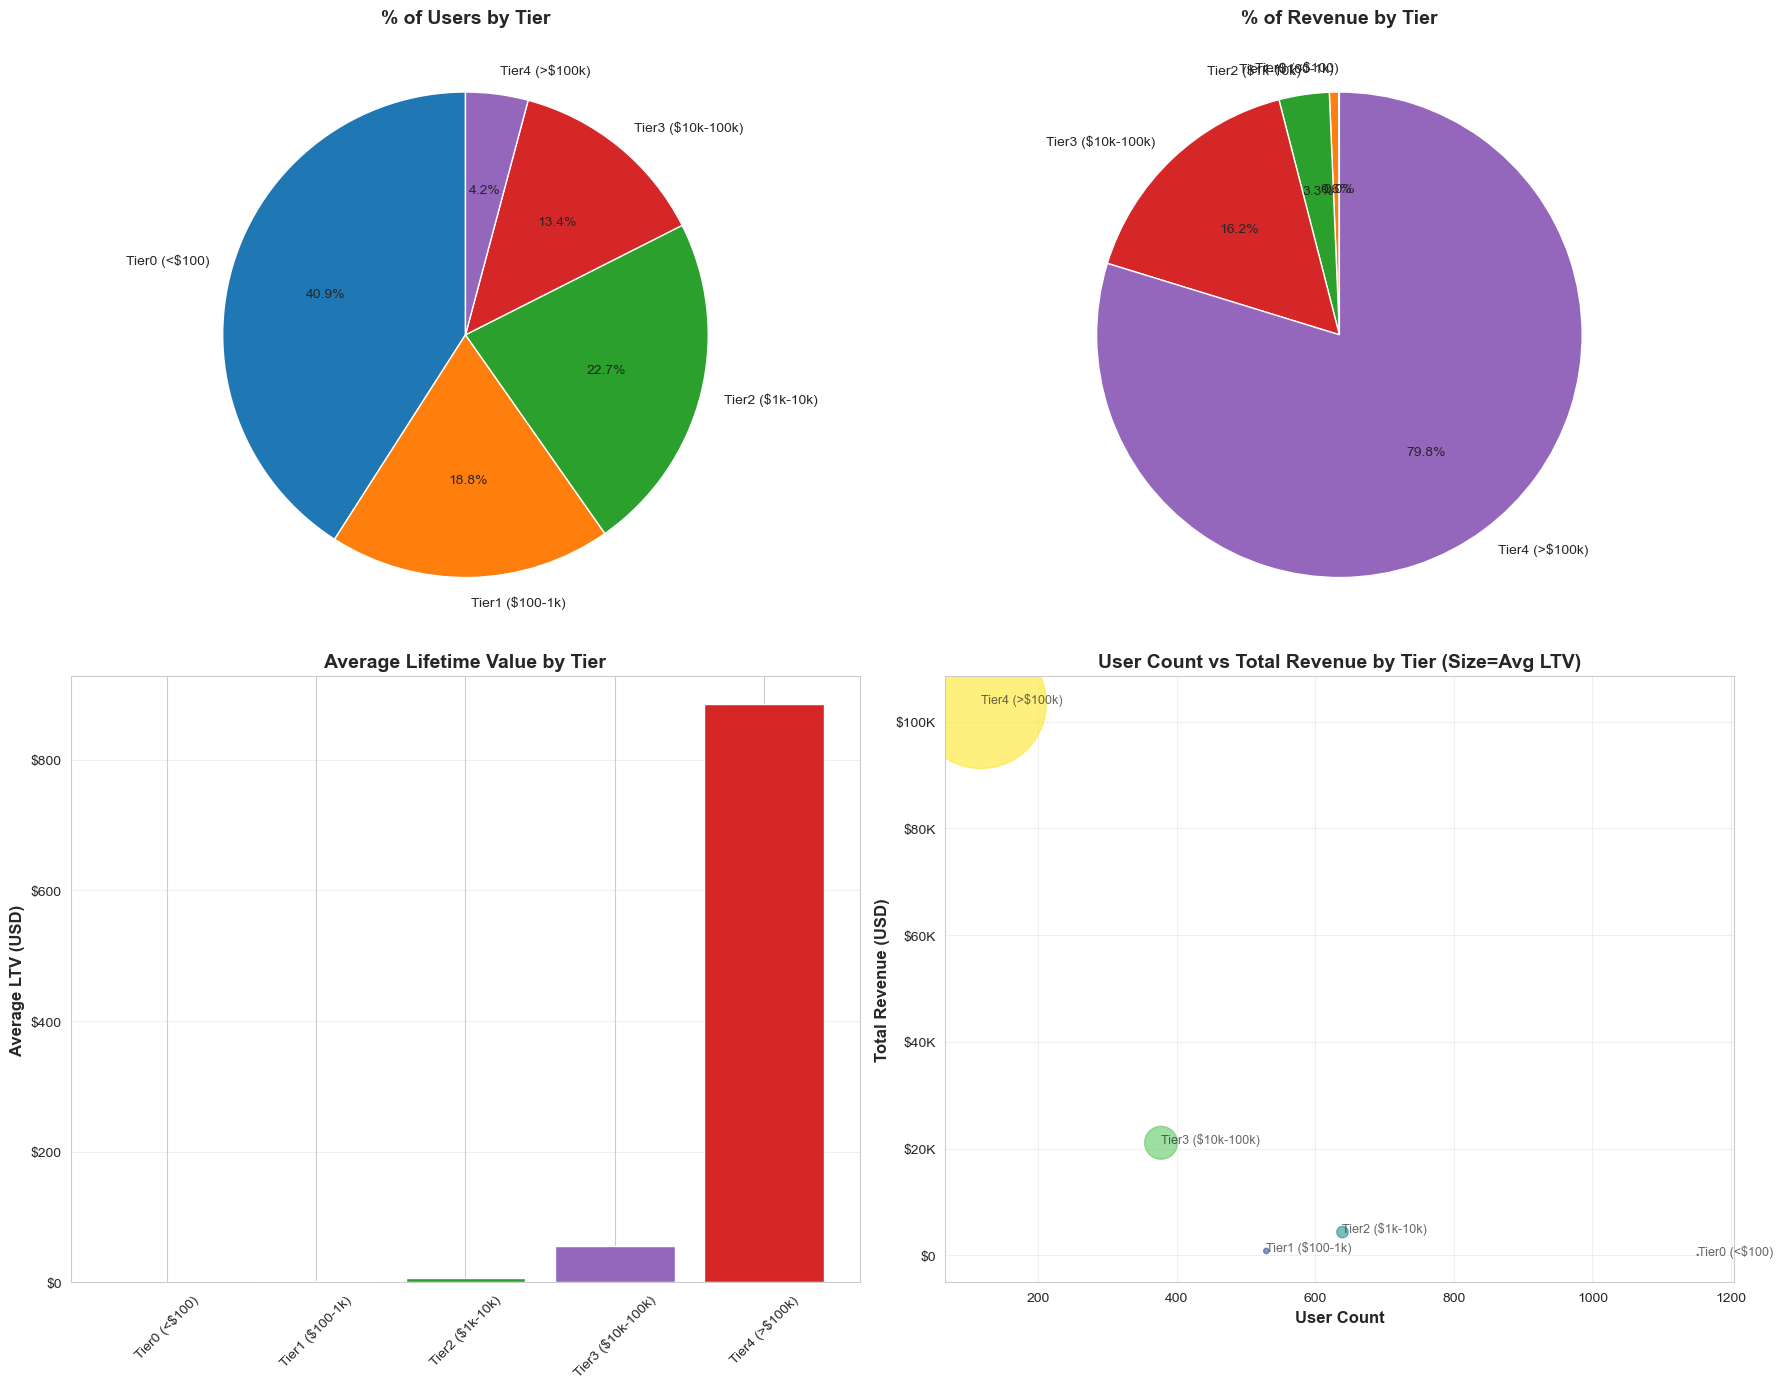

In [26]:
# User Segmentation by Lifetime Value (LTV) & Profitability
print("=" * 70)
print("USER SEGMENTATION BY LIFETIME VALUE (LTV) & PROFITABILITY")
print("=" * 70)

required_cols = ['user_address', 'swap_size', 'fee_usd', 'timestamp', 'platform']
if all(col in combined_df.columns for col in required_cols):
    # 1. Calculate user lifetime metrics
    user_ltv = combined_df.groupby('user_address').agg({
        'swap_size': 'sum',
        'fee_usd': 'sum',
        'timestamp': ['min', 'max', 'count'],
        'platform': lambda x: x.iloc[-1]  # last platform used
    })
    user_ltv.columns = ['lifetime_volume', 'lifetime_fees', 'first_trade_date', 'last_trade_date', 'trade_count', 'last_platform']
    user_ltv = user_ltv.reset_index()
    
    # Calculate lifetime days
    user_ltv['lifetime_days'] = (pd.to_datetime(user_ltv['last_trade_date']) - 
                                 pd.to_datetime(user_ltv['first_trade_date'])).dt.days + 1
    
    # Calculate averages
    user_ltv['avg_fee_per_trade'] = user_ltv['lifetime_fees'] / user_ltv['trade_count']
    user_ltv['ltv_per_day'] = user_ltv['lifetime_fees'] / user_ltv['lifetime_days'].replace(0, 1)
    
    # 2. Create user segments by lifetime_volume
    def classify_tier(volume):
        if volume < 100:
            return 'Tier0 (<$100)'
        elif volume < 1000:
            return 'Tier1 ($100-1k)'
        elif volume < 10000:
            return 'Tier2 ($1k-10k)'
        elif volume < 100000:
            return 'Tier3 ($10k-100k)'
        else:
            return 'Tier4 (>$100k)'
    
    user_ltv['tier'] = user_ltv['lifetime_volume'].apply(classify_tier)
    
    # 3. Tier statistics
    tier_stats = user_ltv.groupby('tier').agg({
        'user_address': 'count',
        'lifetime_volume': 'sum',
        'lifetime_fees': ['sum', 'mean', 'median']
    }).round(2)
    tier_stats.columns = ['user_count', 'total_volume', 'total_revenue', 'avg_ltv', 'median_ltv']
    tier_stats = tier_stats.reset_index()
    
    total_users = len(user_ltv)
    total_revenue_all = user_ltv['lifetime_fees'].sum()
    
    tier_stats['pct_of_users'] = (tier_stats['user_count'] / total_users * 100).round(2)
    tier_stats['pct_of_revenue'] = (tier_stats['total_revenue'] / total_revenue_all * 100).round(2)
    
    # Calculate retention % (users who traded more than once)
    tier_retention = user_ltv.groupby('tier').apply(
        lambda x: (x['trade_count'] > 1).sum() / len(x) * 100
    ).reset_index(name='retention_pct')
    tier_stats = tier_stats.merge(tier_retention, on='tier', how='left')
    
    # 4. Identify "whales who left" (high LTV, no trade in 60+ days)
    current_date = pd.to_datetime(combined_df['timestamp'].max())
    user_ltv['days_since_last'] = (current_date - pd.to_datetime(user_ltv['last_trade_date'])).dt.days
    user_ltv['is_at_risk'] = (user_ltv['days_since_last'] >= 60) & (user_ltv['lifetime_fees'] >= 1000)
    
    at_risk_whales = user_ltv[user_ltv['is_at_risk']].sort_values('lifetime_fees', ascending=False)
    
    print("\nUser Segmentation by Tier:")
    print(tier_stats.to_string(index=False))
    
    print(f"\n\nTier Summary:")
    for _, row in tier_stats.iterrows():
        print(f"  {row['tier']}: {row['user_count']:.0f} users ({row['pct_of_users']:.1f}% of base), "
              f"${row['total_revenue']:,.2f} revenue ({row['pct_of_revenue']:.1f}% of total)")
        print(f"    Avg LTV: ${row['avg_ltv']:,.2f}, Retention: {row['retention_pct']:.1f}%")
    
    # Identify focus tier (high value + many users)
    tier_stats['value_score'] = tier_stats['pct_of_revenue'] * tier_stats['user_count'] / 1000
    focus_tier = tier_stats.loc[tier_stats['value_score'].idxmax(), 'tier']
    print(f"\n\nFocus incentives on: {focus_tier} (highest value score)")
    
    if len(at_risk_whales) > 0:
        print(f"\n\nAt-Risk High-Value Users (LTV >$1k, inactive 60+ days): {len(at_risk_whales)} users")
        print(at_risk_whales[['user_address', 'lifetime_fees', 'lifetime_volume', 'days_since_last']].head(10).to_string(index=False))
    
    # 5. Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Pie chart: % of users by tier
    tier_order = ['Tier0 (<$100)', 'Tier1 ($100-1k)', 'Tier2 ($1k-10k)', 'Tier3 ($10k-100k)', 'Tier4 (>$100k)']
    tier_counts = [tier_stats[tier_stats['tier'] == t]['user_count'].values[0] if len(tier_stats[tier_stats['tier'] == t]) > 0 else 0 for t in tier_order]
    axes[0, 0].pie(tier_counts, labels=tier_order, autopct='%1.1f%%', startangle=90)
    axes[0, 0].set_title('% of Users by Tier', fontsize=14, fontweight='bold')
    
    # Pie chart: % of revenue by tier
    tier_revenues = [tier_stats[tier_stats['tier'] == t]['total_revenue'].values[0] if len(tier_stats[tier_stats['tier'] == t]) > 0 else 0 for t in tier_order]
    axes[0, 1].pie(tier_revenues, labels=tier_order, autopct='%1.1f%%', startangle=90)
    axes[0, 1].set_title('% of Revenue by Tier', fontsize=14, fontweight='bold')
    
    # Bar chart: avg LTV by tier
    tier_ltvs = [tier_stats[tier_stats['tier'] == t]['avg_ltv'].values[0] if len(tier_stats[tier_stats['tier'] == t]) > 0 else 0 for t in tier_order]
    axes[1, 0].bar(tier_order, tier_ltvs, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#d62728'])
    axes[1, 0].set_ylabel('Average LTV (USD)', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Average Lifetime Value by Tier', fontsize=14, fontweight='bold')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].yaxis.set_major_formatter(plt.FuncFormatter(currency_formatter))
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Scatter: user count vs total revenue by tier
    axes[1, 1].scatter(tier_stats['user_count'], tier_stats['total_revenue'], 
                      s=tier_stats['avg_ltv']*10, alpha=0.6, c=range(len(tier_stats)), cmap='viridis')
    for i, row in tier_stats.iterrows():
        axes[1, 1].annotate(row['tier'], (row['user_count'], row['total_revenue']), 
                           fontsize=9, alpha=0.7)
    axes[1, 1].set_xlabel('User Count', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Total Revenue (USD)', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('User Count vs Total Revenue by Tier (Size=Avg LTV)', fontsize=14, fontweight='bold')
    axes[1, 1].yaxis.set_major_formatter(plt.FuncFormatter(currency_formatter))
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
else:
    print("⚠ Missing required columns for LTV analysis")


## Step 18: Improvement 8 - Seasonality & Time-Based Trading Patterns


SEASONALITY & TIME-BASED TRADING PATTERNS

Time-Based Patterns:
  Peak hour: 19.0:00 UTC with $53,092,600.69 volume
  Peak day: Saturday with $16,009,011.86 volume
  Off-peak hour: 14.0:00 UTC (0.1% of peak)
  Best hour×day combo: Thursday 19.0:00 UTC
  Weekend volume: 36.9%, Weekday volume: 63.1%
  Start of month (1-7): 20.9% of volume
  End of month (24+): 20.4% of volume


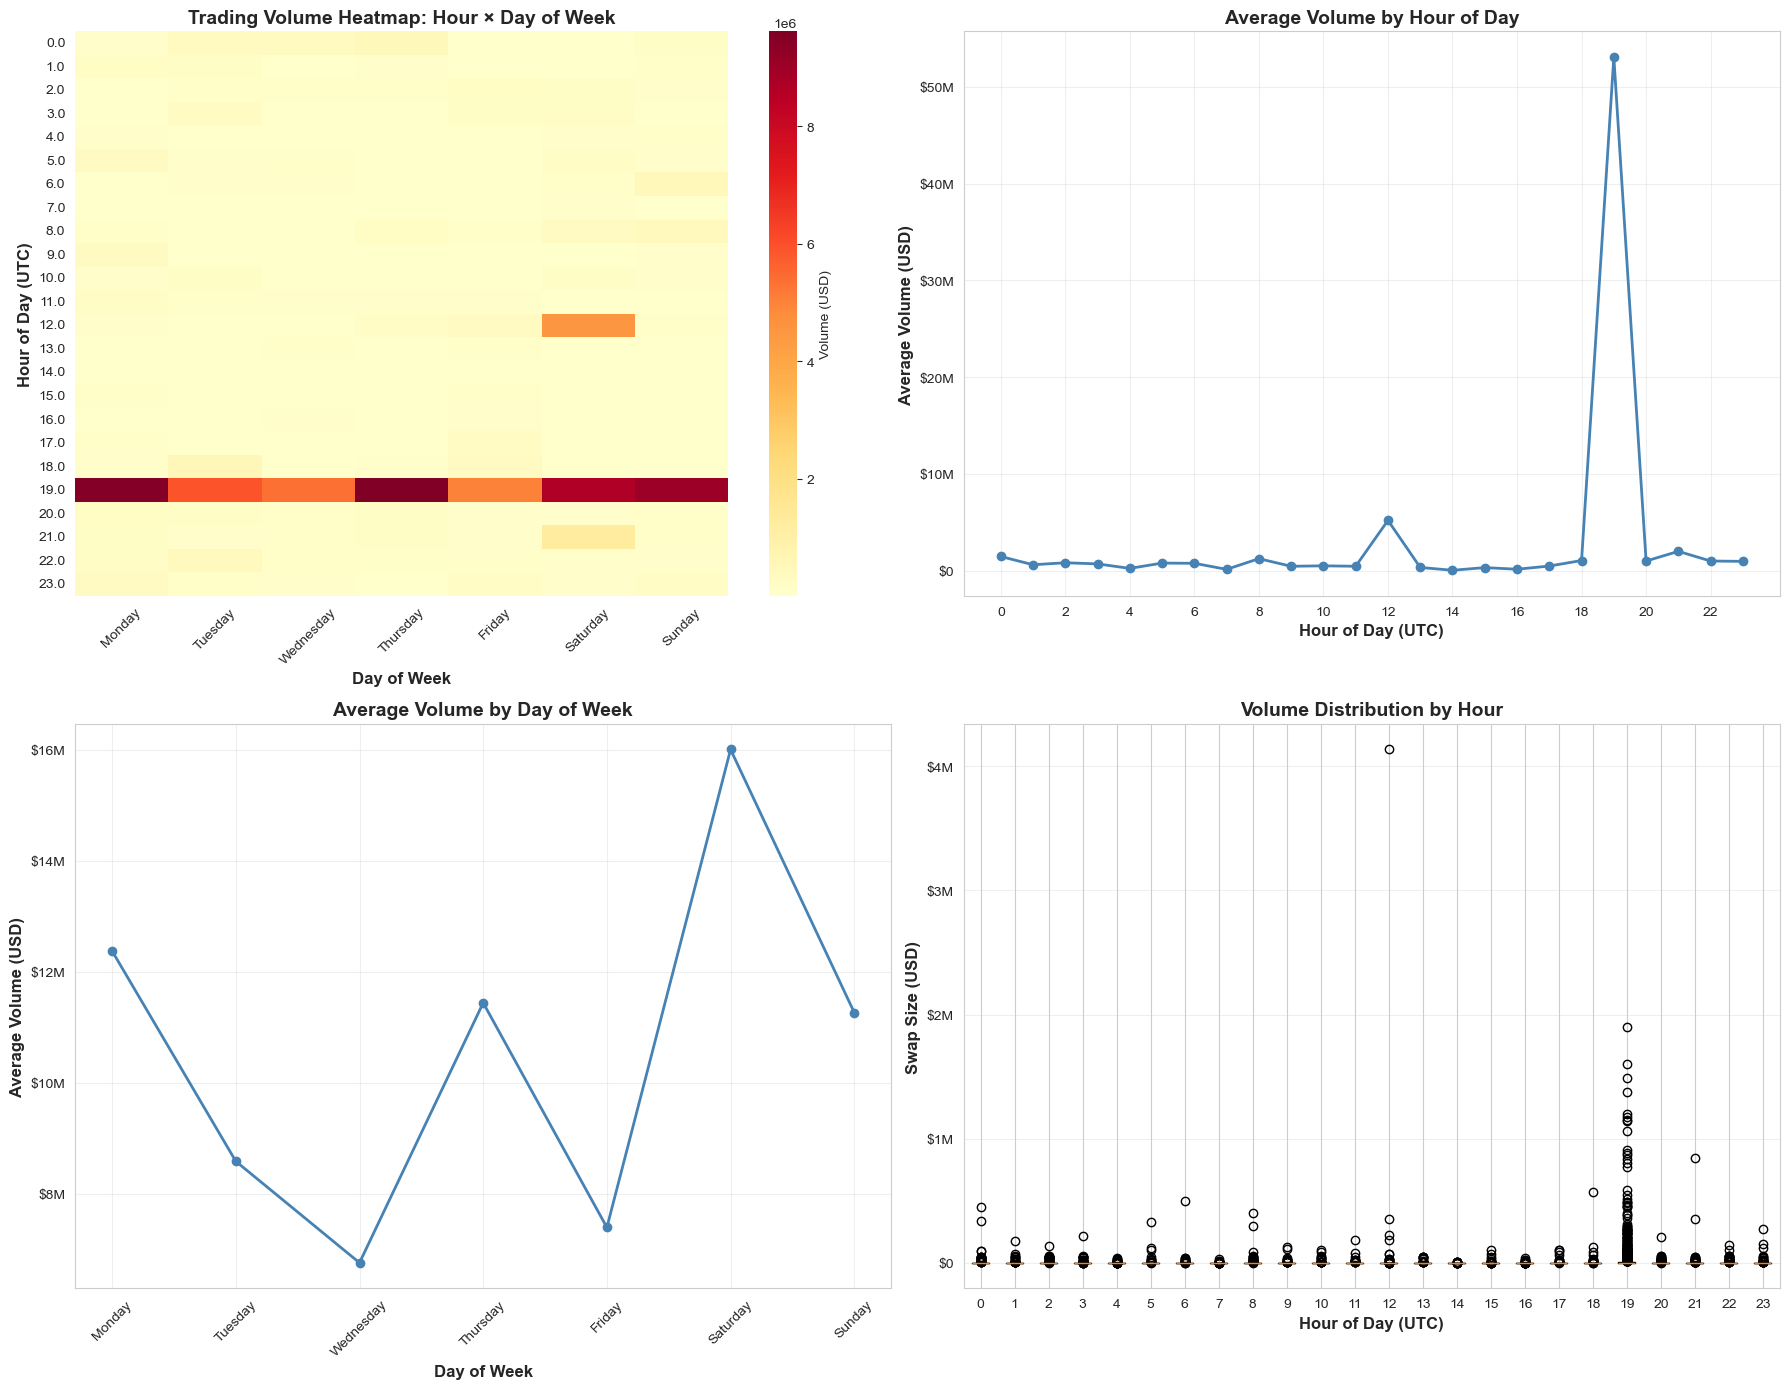

In [27]:
# Seasonality & Time-Based Trading Patterns
print("=" * 70)
print("SEASONALITY & TIME-BASED TRADING PATTERNS")
print("=" * 70)

required_cols = ['timestamp', 'swap_size', 'fee_usd']
if all(col in combined_df.columns for col in required_cols):
    # 1. Extract time features
    time_df = combined_df.copy()
    time_df['hour'] = pd.to_datetime(time_df['timestamp']).dt.hour
    time_df['day_of_week'] = pd.to_datetime(time_df['timestamp']).dt.day_name()
    time_df['day_of_month'] = pd.to_datetime(time_df['timestamp']).dt.day
    time_df['week_of_year'] = pd.to_datetime(time_df['timestamp']).dt.isocalendar().week
    
    # 2. Aggregate by each time dimension
    # Hour analysis
    hourly_stats = time_df.groupby('hour').agg({
        'swap_size': ['sum', 'count', 'mean'],
        'fee_usd': 'sum'
    }).round(2)
    hourly_stats.columns = ['volume', 'swap_count', 'avg_size', 'revenue']
    hourly_stats = hourly_stats.reset_index()
    
    # Day of week analysis
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_stats = time_df.groupby('day_of_week').agg({
        'swap_size': ['sum', 'count', 'mean'],
        'fee_usd': 'sum'
    }).round(2)
    daily_stats.columns = ['volume', 'swap_count', 'avg_size', 'revenue']
    daily_stats = daily_stats.reset_index()
    daily_stats['day_num'] = daily_stats['day_of_week'].map({day: i for i, day in enumerate(day_order)})
    daily_stats = daily_stats.sort_values('day_num')
    
    # Day of month analysis
    dom_stats = time_df.groupby('day_of_month').agg({
        'swap_size': ['sum', 'count', 'mean'],
        'fee_usd': 'sum'
    }).round(2)
    dom_stats.columns = ['volume', 'swap_count', 'avg_size', 'revenue']
    dom_stats = dom_stats.reset_index()
    
    # Week of year analysis
    woy_stats = time_df.groupby('week_of_year').agg({
        'swap_size': ['sum', 'count', 'mean'],
        'fee_usd': 'sum'
    }).round(2)
    woy_stats.columns = ['volume', 'swap_count', 'avg_size', 'revenue']
    woy_stats = woy_stats.reset_index()
    
    # Calculate avg fee bps
    hourly_stats['avg_fee_bps'] = (hourly_stats['revenue'] / hourly_stats['volume'] * 10000).fillna(0)
    daily_stats['avg_fee_bps'] = (daily_stats['revenue'] / daily_stats['volume'] * 10000).fillna(0)
    
    # 3. Identify patterns
    peak_hour = hourly_stats.loc[hourly_stats['volume'].idxmax(), 'hour']
    peak_hour_volume = hourly_stats.loc[hourly_stats['volume'].idxmax(), 'volume']
    
    peak_day = daily_stats.loc[daily_stats['volume'].idxmax(), 'day_of_week']
    peak_day_volume = daily_stats.loc[daily_stats['volume'].idxmax(), 'volume']
    
    avg_volume = hourly_stats['volume'].mean()
    off_peak_hour = hourly_stats.loc[hourly_stats['volume'].idxmin(), 'hour']
    off_peak_volume = hourly_stats.loc[hourly_stats['volume'].idxmin(), 'volume']
    off_peak_pct = (off_peak_volume / peak_hour_volume * 100) if peak_hour_volume > 0 else 0
    
    # Best hour × day combo
    hour_day_combo = time_df.groupby(['hour', 'day_of_week'])['swap_size'].sum().reset_index()
    best_combo = hour_day_combo.loc[hour_day_combo['swap_size'].idxmax()]
    
    print("\nTime-Based Patterns:")
    print(f"  Peak hour: {peak_hour}:00 UTC with ${peak_hour_volume:,.2f} volume")
    print(f"  Peak day: {peak_day} with ${peak_day_volume:,.2f} volume")
    print(f"  Off-peak hour: {off_peak_hour}:00 UTC ({off_peak_pct:.1f}% of peak)")
    print(f"  Best hour×day combo: {best_combo['day_of_week']} {best_combo['hour']}:00 UTC")
    
    # Weekend vs weekday
    time_df['is_weekend'] = pd.to_datetime(time_df['timestamp']).dt.dayofweek >= 5
    weekend_stats = time_df.groupby('is_weekend')['swap_size'].sum()
    weekend_pct = (weekend_stats[True] / (weekend_stats[True] + weekend_stats[False]) * 100) if len(weekend_stats) > 1 else 0
    weekday_pct = 100 - weekend_pct
    print(f"  Weekend volume: {weekend_pct:.1f}%, Weekday volume: {weekday_pct:.1f}%")
    
    # Start/end of month patterns
    start_month = dom_stats[dom_stats['day_of_month'] <= 7]['volume'].sum()
    mid_month = dom_stats[(dom_stats['day_of_month'] > 7) & (dom_stats['day_of_month'] <= 23)]['volume'].sum()
    end_month = dom_stats[dom_stats['day_of_month'] > 23]['volume'].sum()
    total_month = start_month + mid_month + end_month
    
    if total_month > 0:
        start_pct = (start_month / total_month * 100)
        end_pct = (end_month / total_month * 100)
        print(f"  Start of month (1-7): {start_pct:.1f}% of volume")
        print(f"  End of month (24+): {end_pct:.1f}% of volume")
    
    # 4. Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Heatmap: hour × day_of_week
    hour_day_pivot = time_df.groupby(['hour', 'day_of_week'])['swap_size'].sum().reset_index()
    hour_day_pivot = hour_day_pivot.pivot(index='hour', columns='day_of_week', values='swap_size').fillna(0)
    hour_day_pivot = hour_day_pivot[day_order]  # Reorder columns
    sns.heatmap(hour_day_pivot, annot=False, fmt='.0f', cmap='YlOrRd', ax=axes[0, 0], 
               cbar_kws={'label': 'Volume (USD)'})
    axes[0, 0].set_xlabel('Day of Week', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Hour of Day (UTC)', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Trading Volume Heatmap: Hour × Day of Week', fontsize=14, fontweight='bold')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Line chart: avg volume by hour
    axes[0, 1].plot(hourly_stats['hour'], hourly_stats['volume'], marker='o', linewidth=2, color='steelblue')
    axes[0, 1].set_xlabel('Hour of Day (UTC)', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Average Volume (USD)', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Average Volume by Hour of Day', fontsize=14, fontweight='bold')
    axes[0, 1].set_xticks(range(0, 24, 2))
    axes[0, 1].yaxis.set_major_formatter(plt.FuncFormatter(currency_formatter))
    axes[0, 1].grid(True, alpha=0.3)
    
    # Line chart: avg volume by day of week
    axes[1, 0].plot(range(len(daily_stats)), daily_stats['volume'], marker='o', linewidth=2, color='steelblue')
    axes[1, 0].set_xticks(range(len(daily_stats)))
    axes[1, 0].set_xticklabels(daily_stats['day_of_week'], rotation=45)
    axes[1, 0].set_xlabel('Day of Week', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Average Volume (USD)', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Average Volume by Day of Week', fontsize=14, fontweight='bold')
    axes[1, 0].yaxis.set_major_formatter(plt.FuncFormatter(currency_formatter))
    axes[1, 0].grid(True, alpha=0.3)
    
    # Box plot: volume distribution by hour
    hour_data = [time_df[time_df['hour'] == h]['swap_size'].values for h in range(24)]
    axes[1, 1].boxplot(hour_data, labels=range(24))
    axes[1, 1].set_xlabel('Hour of Day (UTC)', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Swap Size (USD)', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Volume Distribution by Hour', fontsize=14, fontweight='bold')
    axes[1, 1].yaxis.set_major_formatter(plt.FuncFormatter(currency_formatter))
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
else:
    print("⚠ Missing required columns for seasonality analysis")


## Step 19: Improvement 9 - Revenue Forecast & Growth Projections


REVENUE FORECAST & GROWTH PROJECTIONS

Current Revenue Metrics:
  Total revenue: $130,351.44
  Daily average: $357.13
  Weekly average: $2,327.70
  Month-to-date: $1,951.26

Growth Rates:
  Average daily growth: 730.65%
  Average weekly growth: 172.02%


Revenue Forecasts:

  Next 30 days:
    Linear model: $24,487.38
    Exponential model: $12,958.07
    Moving average: $7,115.92

  Next 60 days:
    Linear model: $51,066.94
    Exponential model: $30,315.58
    Moving average: $14,231.83

  Next 90 days:
    Linear model: $79,738.69
    Exponential model: $53,566.21
    Moving average: $21,347.75
    Linear forecast ±95% CI: $10,472.51 to $38,502.24
    Linear forecast ±95% CI: $31,246.93 to $70,886.96
    Linear forecast ±95% CI: $55,464.24 to $104,013.15


Scenario Analysis (30 days):
  Base case: $24,487.38
  Bull case (+20%): $29,384.85
  Bear case (-20%): $19,589.90


Inflection Points:
  At current growth rate (730.65% daily), revenue will double in 0 days


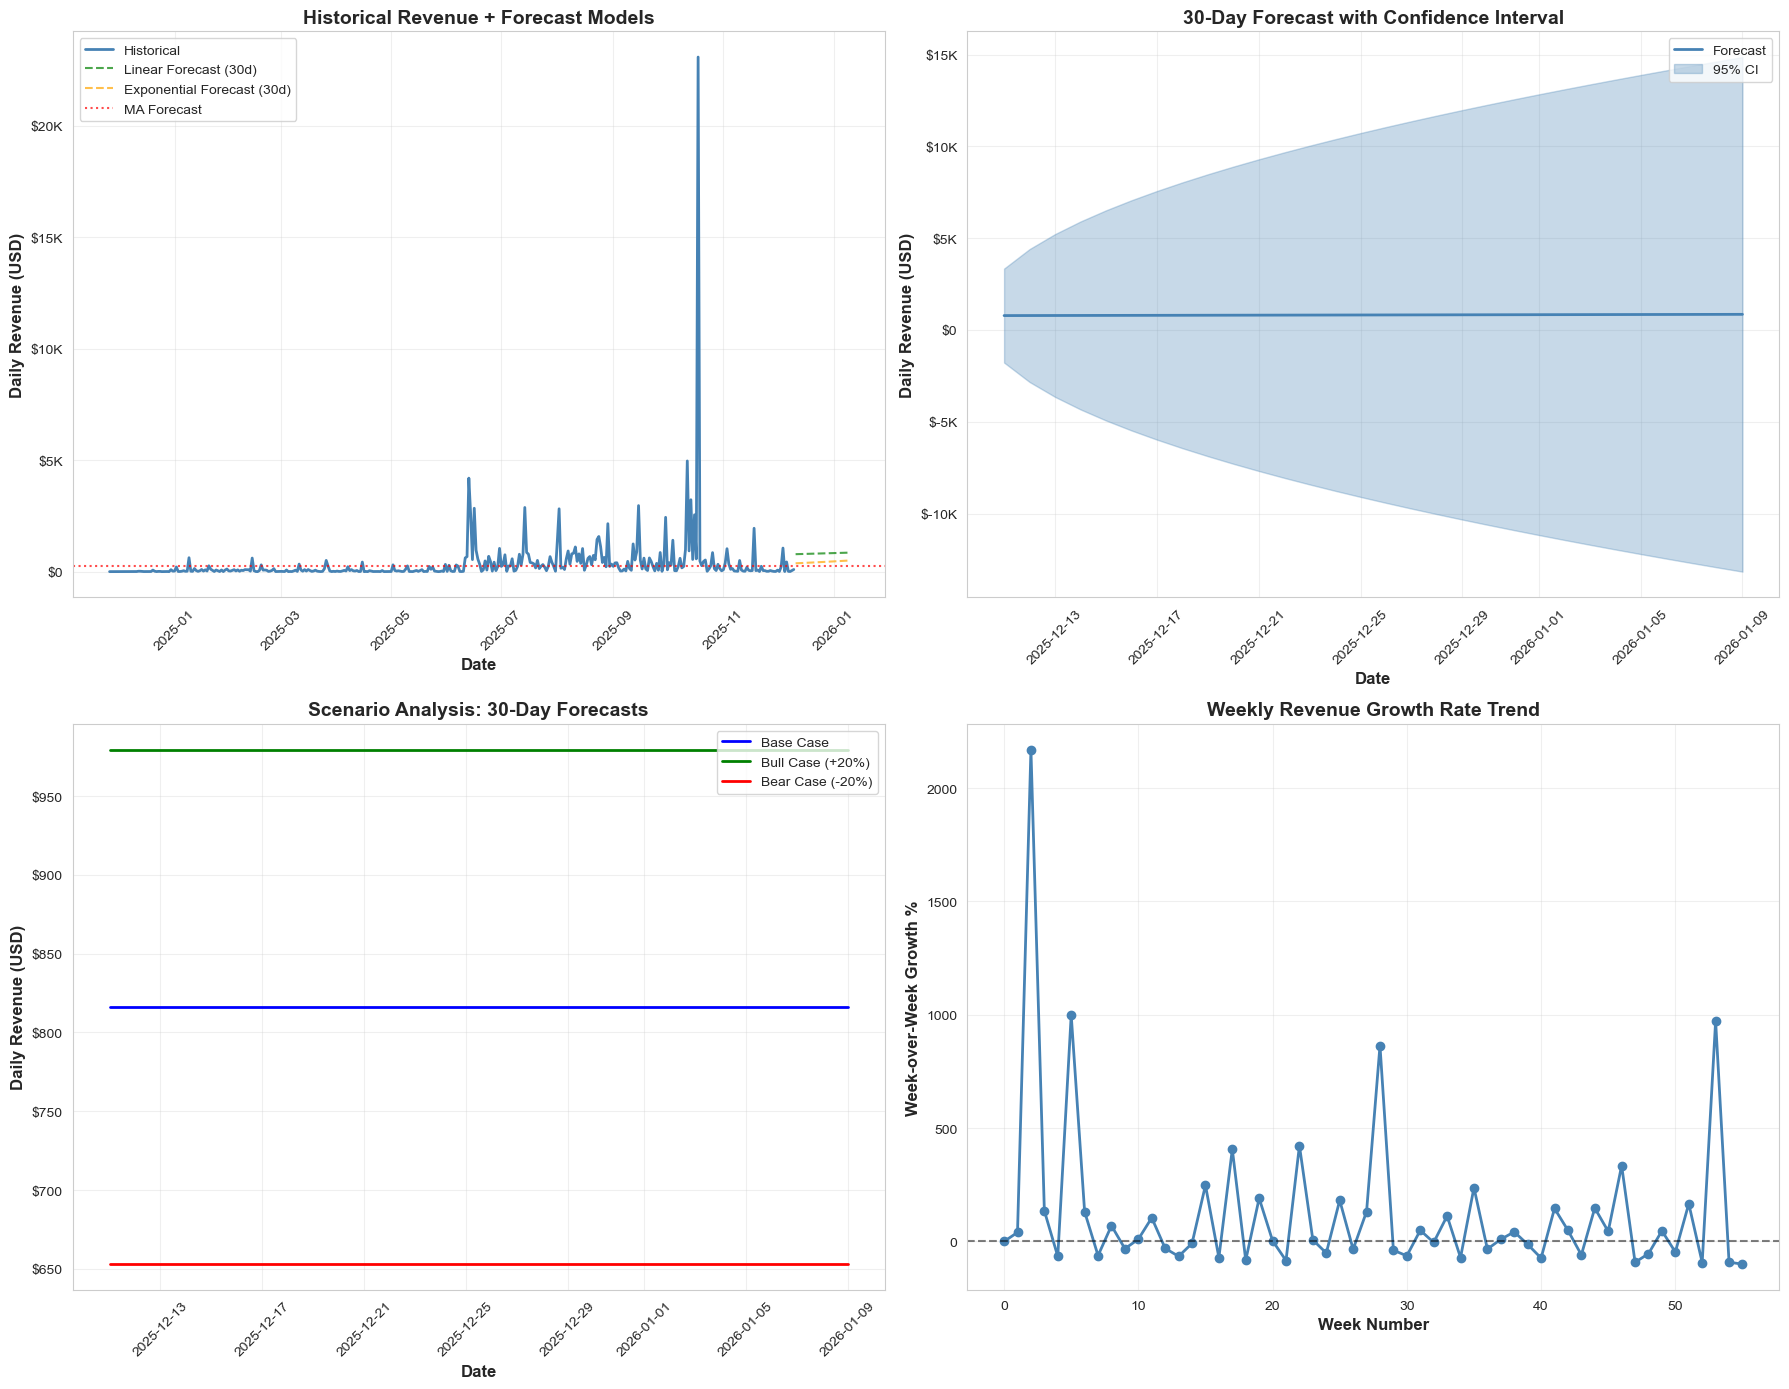

In [28]:
# Revenue Forecast & Growth Projections
print("=" * 70)
print("REVENUE FORECAST & GROWTH PROJECTIONS")
print("=" * 70)

required_cols = ['timestamp', 'fee_usd']
if all(col in combined_df.columns for col in required_cols):
    # 1. Aggregate daily/weekly revenue
    combined_df['date'] = pd.to_datetime(combined_df['timestamp']).dt.date
    daily_revenue = combined_df.groupby('date')['fee_usd'].sum().reset_index()
    daily_revenue.columns = ['date', 'daily_revenue']
    daily_revenue = daily_revenue.sort_values('date')
    
    # Also aggregate by week
    combined_df['week'] = pd.to_datetime(combined_df['timestamp']).dt.to_period('W').astype(str)
    weekly_revenue = combined_df.groupby('week')['fee_usd'].sum().reset_index()
    weekly_revenue.columns = ['week', 'weekly_revenue']
    weekly_revenue = weekly_revenue.sort_values('week')
    
    # 2. Calculate metrics
    total_revenue = combined_df['fee_usd'].sum()
    daily_avg = daily_revenue['daily_revenue'].mean()
    weekly_avg = weekly_revenue['weekly_revenue'].mean()
    
    # Month-to-date (if we have current month data)
    current_month = pd.to_datetime(combined_df['timestamp'].max()).to_period('M')
    mtd_revenue = combined_df[pd.to_datetime(combined_df['timestamp']).dt.to_period('M') == current_month]['fee_usd'].sum()
    
    print(f"\nCurrent Revenue Metrics:")
    print(f"  Total revenue: ${total_revenue:,.2f}")
    print(f"  Daily average: ${daily_avg:,.2f}")
    print(f"  Weekly average: ${weekly_avg:,.2f}")
    print(f"  Month-to-date: ${mtd_revenue:,.2f}")
    
    # 3. Calculate growth rates
    daily_revenue['prev_day'] = daily_revenue['daily_revenue'].shift(1)
    daily_revenue['daily_growth_pct'] = ((daily_revenue['daily_revenue'] - daily_revenue['prev_day']) / 
                                         daily_revenue['prev_day'] * 100).fillna(0)
    
    weekly_revenue['prev_week'] = weekly_revenue['weekly_revenue'].shift(1)
    weekly_revenue['weekly_growth_pct'] = ((weekly_revenue['weekly_revenue'] - weekly_revenue['prev_week']) / 
                                          weekly_revenue['prev_week'] * 100).fillna(0)
    
    avg_daily_growth = daily_revenue['daily_growth_pct'].tail(30).mean()
    avg_weekly_growth = weekly_revenue['weekly_growth_pct'].tail(4).mean()
    
    print(f"\nGrowth Rates:")
    print(f"  Average daily growth: {avg_daily_growth:.2f}%")
    print(f"  Average weekly growth: {avg_weekly_growth:.2f}%")
    
    # 4. Fit forecast models
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import PolynomialFeatures
    
    # Prepare data for forecasting
    daily_revenue['day_num'] = range(len(daily_revenue))
    X = daily_revenue[['day_num']].values
    y = daily_revenue['daily_revenue'].values
    
    # Linear regression forecast
    lr_model = LinearRegression()
    lr_model.fit(X, y)
    
    # Exponential growth (log-linear)
    daily_revenue['log_revenue'] = np.log(daily_revenue['daily_revenue'].replace(0, 1))
    lr_log = LinearRegression()
    lr_log.fit(X, daily_revenue['log_revenue'].values)
    
    # Moving average (7-day)
    daily_revenue['ma_7d'] = daily_revenue['daily_revenue'].rolling(window=7, min_periods=1).mean()
    
    # 5. Project forward 30, 60, 90 days
    forecast_days = [30, 60, 90]
    last_day_num = daily_revenue['day_num'].max()
    
    forecasts = {}
    for days in forecast_days:
        future_days = np.array([[last_day_num + i] for i in range(1, days + 1)])
        
        # Linear forecast
        linear_forecast = lr_model.predict(future_days)
        linear_total = linear_forecast.sum()
        
        # Exponential forecast
        exp_forecast = np.exp(lr_log.predict(future_days))
        exp_total = exp_forecast.sum()
        
        # Moving average forecast (use last MA value)
        ma_value = daily_revenue['ma_7d'].iloc[-1]
        ma_total = ma_value * days
        
        forecasts[days] = {
            'linear': linear_total,
            'exponential': exp_total,
            'moving_avg': ma_total
        }
    
    print(f"\n\nRevenue Forecasts:")
    for days in forecast_days:
        print(f"\n  Next {days} days:")
        print(f"    Linear model: ${forecasts[days]['linear']:,.2f}")
        print(f"    Exponential model: ${forecasts[days]['exponential']:,.2f}")
        print(f"    Moving average: ${forecasts[days]['moving_avg']:,.2f}")
    
    # Calculate confidence intervals (simplified - using std dev of residuals)
    linear_residuals = y - lr_model.predict(X)
    std_error = np.std(linear_residuals)
    
    # 95% confidence interval (±1.96 * std_error * sqrt(days))
    for days in forecast_days:
        ci_range = 1.96 * std_error * np.sqrt(days)
        base_forecast = forecasts[days]['linear']
        print(f"    Linear forecast ±95% CI: ${base_forecast - ci_range:,.2f} to ${base_forecast + ci_range:,.2f}")
    
    # 6. Scenario analysis
    base_30d = forecasts[30]['linear']
    bull_30d = base_30d * 1.2  # +20% growth
    bear_30d = base_30d * 0.8  # -20% growth
    
    print(f"\n\nScenario Analysis (30 days):")
    print(f"  Base case: ${base_30d:,.2f}")
    print(f"  Bull case (+20%): ${bull_30d:,.2f}")
    print(f"  Bear case (-20%): ${bear_30d:,.2f}")
    
    # 7. Calculate inflection points
    # When will revenue double?
    current_daily = daily_revenue['daily_revenue'].iloc[-1]
    target_daily = current_daily * 2
    
    if avg_daily_growth > 0:
        days_to_double = np.log(2) / np.log(1 + avg_daily_growth / 100) if avg_daily_growth > 0 else float('inf')
        print(f"\n\nInflection Points:")
        print(f"  At current growth rate ({avg_daily_growth:.2f}% daily), revenue will double in {days_to_double:.0f} days")
    
    # 8. Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Historical revenue + forecast models
    dates = pd.to_datetime(daily_revenue['date'])
    axes[0, 0].plot(dates, daily_revenue['daily_revenue'], label='Historical', linewidth=2, color='steelblue')
    
    # Add forecast lines
    future_dates_30 = pd.date_range(start=dates.max() + pd.Timedelta(days=1), periods=30, freq='D')
    future_days_30 = np.array([[last_day_num + i] for i in range(1, 31)])
    linear_30 = lr_model.predict(future_days_30)
    exp_30 = np.exp(lr_log.predict(future_days_30))
    
    axes[0, 0].plot(future_dates_30, linear_30, '--', label='Linear Forecast (30d)', alpha=0.7, color='green')
    axes[0, 0].plot(future_dates_30, exp_30, '--', label='Exponential Forecast (30d)', alpha=0.7, color='orange')
    axes[0, 0].axhline(y=daily_revenue['ma_7d'].iloc[-1], linestyle=':', label='MA Forecast', alpha=0.7, color='red')
    axes[0, 0].set_xlabel('Date', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Daily Revenue (USD)', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Historical Revenue + Forecast Models', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(currency_formatter))
    axes[0, 0].grid(True, alpha=0.3)
    
    # Confidence band
    ci_upper_30 = linear_30 + (1.96 * std_error * np.sqrt(np.arange(1, 31)))
    ci_lower_30 = linear_30 - (1.96 * std_error * np.sqrt(np.arange(1, 31)))
    axes[0, 1].plot(future_dates_30, linear_30, linewidth=2, color='steelblue', label='Forecast')
    axes[0, 1].fill_between(future_dates_30, ci_lower_30, ci_upper_30, alpha=0.3, color='steelblue', label='95% CI')
    axes[0, 1].set_xlabel('Date', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Daily Revenue (USD)', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('30-Day Forecast with Confidence Interval', fontsize=14, fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].yaxis.set_major_formatter(plt.FuncFormatter(currency_formatter))
    axes[0, 1].grid(True, alpha=0.3)
    
    # Scenario lines
    bull_30_daily = [bull_30d / 30] * 30
    bear_30_daily = [bear_30d / 30] * 30
    base_30_daily = [base_30d / 30] * 30
    axes[1, 0].plot(future_dates_30, base_30_daily, linewidth=2, label='Base Case', color='blue')
    axes[1, 0].plot(future_dates_30, bull_30_daily, linewidth=2, label='Bull Case (+20%)', color='green')
    axes[1, 0].plot(future_dates_30, bear_30_daily, linewidth=2, label='Bear Case (-20%)', color='red')
    axes[1, 0].set_xlabel('Date', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Daily Revenue (USD)', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('Scenario Analysis: 30-Day Forecasts', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].yaxis.set_major_formatter(plt.FuncFormatter(currency_formatter))
    axes[1, 0].grid(True, alpha=0.3)
    
    # Growth rate trend
    weekly_revenue['week_num'] = range(len(weekly_revenue))
    axes[1, 1].plot(weekly_revenue['week_num'], weekly_revenue['weekly_growth_pct'], 
                   marker='o', linewidth=2, color='steelblue')
    axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 1].set_xlabel('Week Number', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Week-over-Week Growth %', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Weekly Revenue Growth Rate Trend', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
else:
    print("⚠ Missing required columns for revenue forecast")


## Step 20: Improvement 10 - Cross-Platform Arbitrage Detection & Bot Activity


CROSS-PLATFORM ARBITRAGE DETECTION & BOT ACTIVITY

No arbitrage patterns detected


Bot Detection:
  Suspected bots: 2,511 users
  Bot volume: $54,685,798.70 (74.08% of total)
  Real volume (excluding bots): $19,134,239.95 (25.92%)

  Bot Indicators:
    High frequency (>50 trades/day): 0 users
    Pair farmers (80%+ same pair): 2,474 users
    Systematic size (low variance): 130 users
    Midnight clustering (10+ trades): 0 users


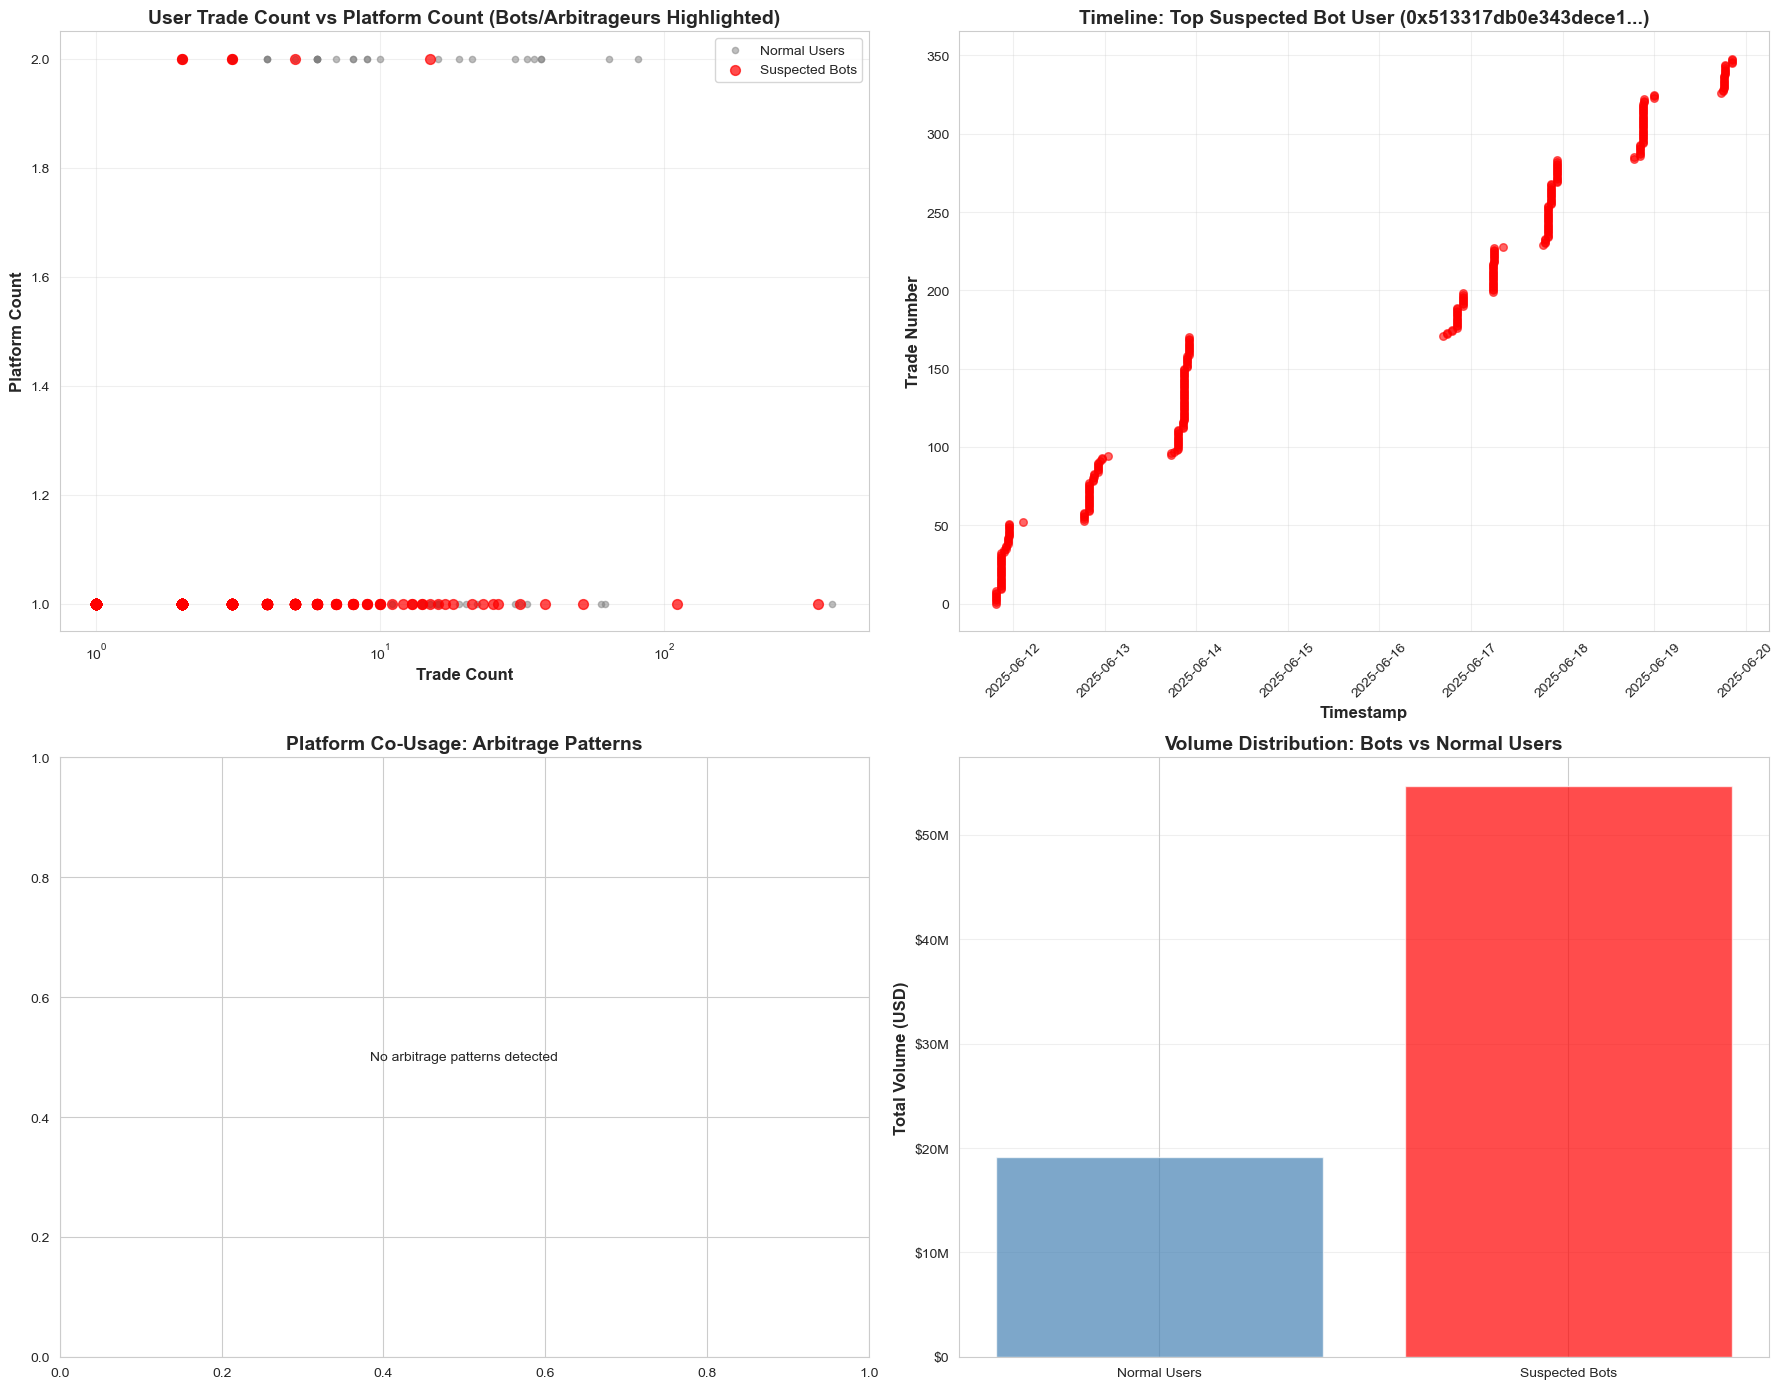

In [29]:
# Cross-Platform Arbitrage Detection & Bot Activity
print("=" * 70)
print("CROSS-PLATFORM ARBITRAGE DETECTION & BOT ACTIVITY")
print("=" * 70)

required_cols = ['user_address', 'platform', 'asset_pair', 'timestamp', 'swap_size']
if all(col in combined_df.columns for col in required_cols):
    # 1. For each user, identify platforms used and sequence
    user_trades = combined_df.sort_values('timestamp').copy()
    user_trades['trade_num'] = user_trades.groupby('user_address').cumcount() + 1
    
    # Calculate time between trades
    user_trades['prev_timestamp'] = user_trades.groupby('user_address')['timestamp'].shift(1)
    user_trades['time_between_trades'] = (user_trades['timestamp'] - user_trades['prev_timestamp']).dt.total_seconds() / 60  # minutes
    
    # 2. Detect arbitrage patterns
    # Same user, same asset_pair, different platforms within 5 minutes
    arbitrage_candidates = []
    for user_addr in user_trades['user_address'].unique():
        user_data = user_trades[user_trades['user_address'] == user_addr].sort_values('timestamp')
        
        for i in range(len(user_data)):
            for j in range(i + 1, len(user_data)):
                trade1 = user_data.iloc[i]
                trade2 = user_data.iloc[j]
                
                # Check if same pair, different platforms, within 5 minutes
                time_diff = (trade2['timestamp'] - trade1['timestamp']).total_seconds() / 60
                if (trade1['asset_pair'] == trade2['asset_pair'] and 
                    trade1['platform'] != trade2['platform'] and 
                    time_diff <= 5):
                    arbitrage_candidates.append({
                        'user_address': user_addr,
                        'asset_pair': trade1['asset_pair'],
                        'platform1': trade1['platform'],
                        'platform2': trade2['platform'],
                        'time_diff_minutes': time_diff
                    })
    
    arbitrage_df = pd.DataFrame(arbitrage_candidates)
    
    if len(arbitrage_df) > 0:
        arbitrage_users = arbitrage_df.groupby('user_address').size().reset_index(name='arbitrage_count')
        print(f"\nArbitrage Detection:")
        print(f"  Potential arbitrage trades: {len(arbitrage_df)}")
        print(f"  Unique arbitrageurs: {len(arbitrage_users)}")
        print(f"\n  Top arbitrage patterns:")
        print(arbitrage_df.groupby(['platform1', 'platform2', 'asset_pair']).size().reset_index(name='count')
              .sort_values('count', ascending=False).head(10).to_string(index=False))
    else:
        arbitrage_users = pd.DataFrame(columns=['user_address', 'arbitrage_count'])
        print("\nNo arbitrage patterns detected")
    
    # 3. Detect bot patterns
    user_stats = combined_df.groupby('user_address').agg({
        'timestamp': ['min', 'max', 'count'],
        'platform': lambda x: x.nunique(),
        'asset_pair': lambda x: x.value_counts().iloc[0] if len(x.value_counts()) > 0 else 0,
        'swap_size': ['mean', 'std']
    })
    user_stats.columns = ['first_trade', 'last_trade', 'trade_count', 'platform_count', 'most_common_pair_count', 'avg_size', 'std_size']
    user_stats = user_stats.reset_index()
    
    # Calculate trading days
    user_stats['trading_days'] = (pd.to_datetime(user_stats['last_trade']) - 
                                  pd.to_datetime(user_stats['first_trade'])).dt.days + 1
    user_stats['trades_per_day'] = user_stats['trade_count'] / user_stats['trading_days'].replace(0, 1)
    
    # Bot indicators
    user_stats['is_high_frequency'] = user_stats['trades_per_day'] > 50
    user_stats['is_pair_farmer'] = (user_stats['most_common_pair_count'] / user_stats['trade_count']) > 0.8  # 80%+ same pair
    user_stats['is_systematic_size'] = (user_stats['std_size'] / user_stats['avg_size'].replace(0, 1)) < 0.1  # Low variance
    
    # Midnight UTC clustering (trades at 00:00-00:05 UTC)
    user_trades['hour'] = pd.to_datetime(user_trades['timestamp']).dt.hour
    user_trades['minute'] = pd.to_datetime(user_trades['timestamp']).dt.minute
    midnight_trades = user_trades[(user_trades['hour'] == 0) & (user_trades['minute'] <= 5)]
    midnight_users = midnight_trades.groupby('user_address').size().reset_index(name='midnight_trade_count')
    midnight_users['is_midnight_cluster'] = midnight_users['midnight_trade_count'] >= 10
    
    user_stats = user_stats.merge(midnight_users[['user_address', 'is_midnight_cluster']], on='user_address', how='left')
    user_stats['is_midnight_cluster'] = user_stats['is_midnight_cluster'].fillna(False)
    
    # Classify as bot if any indicator is true
    user_stats['is_suspected_bot'] = (user_stats['is_high_frequency'] | 
                                     user_stats['is_pair_farmer'] | 
                                     user_stats['is_systematic_size'] | 
                                     user_stats['is_midnight_cluster'])
    
    # 4. Calculate bot metrics
    suspected_bots = user_stats[user_stats['is_suspected_bot']]
    bot_volume = combined_df[combined_df['user_address'].isin(suspected_bots['user_address'])]['swap_size'].sum()
    total_volume = combined_df['swap_size'].sum()
    bot_volume_pct = (bot_volume / total_volume * 100) if total_volume > 0 else 0
    
    print(f"\n\nBot Detection:")
    print(f"  Suspected bots: {len(suspected_bots):,} users")
    print(f"  Bot volume: ${bot_volume:,.2f} ({bot_volume_pct:.2f}% of total)")
    print(f"  Real volume (excluding bots): ${total_volume - bot_volume:,.2f} ({100 - bot_volume_pct:.2f}%)")
    
    print(f"\n  Bot Indicators:")
    print(f"    High frequency (>50 trades/day): {user_stats['is_high_frequency'].sum():,} users")
    print(f"    Pair farmers (80%+ same pair): {user_stats['is_pair_farmer'].sum():,} users")
    print(f"    Systematic size (low variance): {user_stats['is_systematic_size'].sum():,} users")
    print(f"    Midnight clustering (10+ trades): {user_stats['is_midnight_cluster'].sum():,} users")
    
    # Arbitrage edge calculation (if we have price data)
    if len(arbitrage_df) > 0 and 'to_amount_usd' in combined_df.columns:
        # Simplified: assume arbitrage profit is difference in execution
        # In reality, would need to compare actual prices received
        print(f"\n\nArbitrage Analysis:")
        print(f"  Average arbitrageurs: {len(arbitrage_users):,} users")
        if len(arbitrage_users) > 0:
            avg_arbitrage_trades = arbitrage_users['arbitrage_count'].mean()
            print(f"  Average arbitrage trades per user: {avg_arbitrage_trades:.1f}")
    
    # 5. Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    
    # Scatter: user trade_count vs platform_count (highlight bots/arbitrageurs)
    axes[0, 0].scatter(user_stats[~user_stats['is_suspected_bot']]['trade_count'], 
                      user_stats[~user_stats['is_suspected_bot']]['platform_count'],
                      alpha=0.5, color='gray', label='Normal Users', s=20)
    axes[0, 0].scatter(user_stats[user_stats['is_suspected_bot']]['trade_count'],
                      user_stats[user_stats['is_suspected_bot']]['platform_count'],
                      alpha=0.7, color='red', label='Suspected Bots', s=50)
    if len(arbitrage_users) > 0:
        arbitrage_user_data = user_stats[user_stats['user_address'].isin(arbitrage_users['user_address'])]
        axes[0, 0].scatter(arbitrage_user_data['trade_count'],
                          arbitrage_user_data['platform_count'],
                          alpha=0.8, color='orange', marker='^', label='Arbitrageurs', s=100)
    axes[0, 0].set_xlabel('Trade Count', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Platform Count', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('User Trade Count vs Platform Count (Bots/Arbitrageurs Highlighted)', fontsize=14, fontweight='bold')
    axes[0, 0].legend()
    axes[0, 0].set_xscale('log')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Timeline: suspicious user trades (show clustering)
    if len(suspected_bots) > 0:
        top_bot = suspected_bots.nlargest(1, 'trade_count')['user_address'].iloc[0]
        bot_trades = user_trades[user_trades['user_address'] == top_bot].sort_values('timestamp')
        axes[0, 1].scatter(pd.to_datetime(bot_trades['timestamp']), 
                          range(len(bot_trades)), 
                          alpha=0.6, s=30, color='red')
        axes[0, 1].set_xlabel('Timestamp', fontsize=12, fontweight='bold')
        axes[0, 1].set_ylabel('Trade Number', fontsize=12, fontweight='bold')
        axes[0, 1].set_title(f'Timeline: Top Suspected Bot User ({top_bot[:20]}...)', fontsize=14, fontweight='bold')
        axes[0, 1].tick_params(axis='x', rotation=45)
        axes[0, 1].grid(True, alpha=0.3)
    else:
        axes[0, 1].text(0.5, 0.5, 'No bot activity detected', ha='center', va='center', transform=axes[0, 1].transAxes)
        axes[0, 1].set_title('Bot Activity Timeline', fontsize=14, fontweight='bold')
    
    # Heatmap: platform co-usage timing (for arbitrage detection)
    if len(arbitrage_df) > 0:
        arbitrage_platforms = arbitrage_df.groupby(['platform1', 'platform2']).size().reset_index(name='count')
        arbitrage_pivot = arbitrage_platforms.pivot(index='platform1', columns='platform2', values='count').fillna(0)
        sns.heatmap(arbitrage_pivot, annot=True, fmt='.0f', cmap='YlOrRd', ax=axes[1, 0], cbar_kws={'label': 'Arbitrage Count'})
        axes[1, 0].set_title('Platform Co-Usage: Arbitrage Patterns', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('To Platform', fontsize=12, fontweight='bold')
        axes[1, 0].set_ylabel('From Platform', fontsize=12, fontweight='bold')
    else:
        axes[1, 0].text(0.5, 0.5, 'No arbitrage patterns detected', ha='center', va='center', transform=axes[1, 0].transAxes)
        axes[1, 0].set_title('Platform Co-Usage: Arbitrage Patterns', fontsize=14, fontweight='bold')
    
    # Bot vs normal user distribution
    bot_summary = pd.DataFrame({
        'Category': ['Normal Users', 'Suspected Bots'],
        'User Count': [len(user_stats) - len(suspected_bots), len(suspected_bots)],
        'Volume': [total_volume - bot_volume, bot_volume]
    })
    axes[1, 1].bar(bot_summary['Category'], bot_summary['Volume'], color=['steelblue', 'red'], alpha=0.7)
    axes[1, 1].set_ylabel('Total Volume (USD)', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('Volume Distribution: Bots vs Normal Users', fontsize=14, fontweight='bold')
    axes[1, 1].yaxis.set_major_formatter(plt.FuncFormatter(currency_formatter))
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)
else:
    print("⚠ Missing required columns for arbitrage/bot detection")
